# Plot basic classification event selecttion cuts

last edit Apr-1, 2023

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

In [3]:
figures_path = "/Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/"
import ROOT 

Welcome to JupyROOT 6.26/04


In [4]:
pd.options.display.precision = 1

# Auxiliary

In [5]:
def compute_cut_impact_on_statistics(df_pips, df_pims, Npips_noCuts=1,Npims_noCuts=1):
    # Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events,Npips_noCuts=1,Npims_noCuts=1)
    Npips,Npims = len(df_pips),len(df_pims)
    
    fpips  = 100.*Npips/Npips_noCuts
    dfpips = fpips * np.sqrt(1./np.max([Npips,1])+1./Npips_noCuts)
    fpims  = 100.*Npims/Npims_noCuts
    dfpims = fpims * np.sqrt(1./np.max([Npims,1])+1./Npims_noCuts)

    return Npips,Npims,fpips,dfpips,fpims,dfpims 

# (1) Load data and cut values

## (1.1) Load cut variables

In [6]:
cuts = pd.read_csv( '/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/macros/cuts/BANDcutValues.csv' );

## (1.2) Load data

In [7]:
data_path = '/Users/erezcohen/Desktop/data/BAND/inclusive_no_cuts/Mar24_2023/';

In [64]:
NeventsMax        = 1e6
Nruns             = 3;
Nevntries_per_run = 'all';
rgb_runs_filename = "good_runs_10-2-final.txt"
rgb_runs = read_run_nunmbers( runs_filename=rgb_runs_filename, Nruns=Nruns )

In [65]:
rgb_runs = np.array([6422,6426,6429])

In [66]:

e_Sector, pi_Sector = dict(),dict()
Ve_z,     Vpi_z     = dict(),dict()
W,Q2,y              = dict(),dict(),dict()
e_P,pi_P,e_Theta    = dict(),dict(),dict()
pi_Theta,e_Phi      = dict(),dict()
pi_Phi              = dict()
e_E_PCAL, e_E_ECIN  = dict(),dict()
e_E_ECOUT, e_PCAL_W = dict(),dict()
e_PCAL_V            = dict()
pi_chi2PID          = dict()
Zpi                 = dict()
Npions              = dict()
Npips, Npims        = dict(), dict()
e_DC_x,e_DC_y       = dict(), dict()
pi_DC_x,pi_DC_y     = dict(), dict()
omega               = dict() 
Mx                  = dict()

Ve = ROOT.TVector3()
Vpi = ROOT.TVector3()
e  = ROOT.TLorentzVector()
pi = ROOT.TLorentzVector()
q  = ROOT.TLorentzVector()
p_rest = ROOT.TLorentzVector(); p_rest.SetXYZM(0, 0, 0, 0.938272);

Nevts = dict()
for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
    W[pi_ch],Q2[pi_ch],y[pi_ch]      = [],[],[]
    e_P[pi_ch],     pi_P[pi_ch]      = [],[]
    e_Theta[pi_ch], pi_Theta[pi_ch]  = [],[]  
    e_Phi[pi_ch],   pi_Phi[pi_ch]    = [],[]
    e_Sector[pi_ch],pi_Sector[pi_ch] = [],[]    
    Ve_z[pi_ch],    Vpi_z[pi_ch]     = [],[]
    e_E_PCAL[pi_ch], e_E_ECIN[pi_ch] = [],[]
    e_E_ECOUT[pi_ch], e_PCAL_W[pi_ch]= [],[]
    e_PCAL_V[pi_ch]                  = []  
    Zpi[pi_ch]                       = []
    pi_chi2PID[pi_ch]                = []
    Npips[pi_ch], Npims[pi_ch]       = [], []
    Nevts[pi_ch]                     = 0
    
    e_DC_x[pi_ch]                    = []
    e_DC_y[pi_ch]                    = []
    pi_DC_x[pi_ch]                   = []
    pi_DC_y[pi_ch]                   = []
    omega[pi_ch]                     = []
    Mx[pi_ch]                        = []
    
for runnum,runIdx in zip(rgb_runs,range(Nruns)):#{

    for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
        filename = data_path + 'skimmed_SIDIS_sidisdvcs_00%d_e_%s.root'%(runnum,pi_ch)
        f = ROOT.TFile(filename)
        tree = f.Get("tree")

        for entryNum in range(0,tree.GetEntries()):
            # print(pi_ch,runnum,entryNum)
            if ((Nevntries_per_run!='all') and (entryNum >= Nevntries_per_run) or (Nevts[pi_ch] >= NeventsMax)): break;
            
            tree.GetEntry(entryNum)
            Npi = getattr(tree,"Npi")
            Npips[pi_ch] = getattr(tree,"Npips")
            Npims[pi_ch] = getattr(tree,"Npims")

            if pi_ch=='piplus'  and Npips[pi_ch]==0: continue
            if pi_ch=='piminus' and Npims[pi_ch]==0: continue

            e_E_PCAL[pi_ch] .append( getattr(tree,"e_E_PCAL") ) 
            e_E_ECIN[pi_ch] .append( getattr(tree,"e_E_ECIN") )
            e_E_ECOUT[pi_ch].append( getattr(tree,"e_E_ECOUT"))
            e_PCAL_W[pi_ch] .append( getattr(tree,"e_PCAL_W") )
            e_PCAL_V[pi_ch] .append( getattr(tree,"e_PCAL_V") )
            e_Sector[pi_ch] .append( getattr(tree,"e_DC_sector") )

            e_DC_x_arr      = getattr(tree,"e_DC_x")
            e_DC_y_arr      = getattr(tree,"e_DC_y")

            # Three layers for the electron DC 
            e_DC_x[pi_ch].append([e_DC_x_arr[0],e_DC_x_arr[1],e_DC_x_arr[2]])
            e_DC_y[pi_ch].append([e_DC_y_arr[0],e_DC_y_arr[1],e_DC_y_arr[2]])


            e  = getattr(tree,"e") 
            Ve =  getattr(tree,"Ve") 
            Ve_z[pi_ch]    .append(Ve.Z()) 
            e_P[pi_ch]     .append(e.P()) 
            e_Theta[pi_ch] .append(e.Theta()) 
            e_Phi[pi_ch]   .append(e.Phi()) 
            y[pi_ch]       .append(getattr(tree,"y"))
            W[pi_ch]       .append(getattr(tree,"W"))
            Q2[pi_ch]      .append(getattr(tree,"Q2"))
            omega[pi_ch]   .append(getattr(tree,"omega"))


            q               = getattr(tree,"q") 
            pi              = getattr(tree,"pi") 
            Vpi             = getattr(tree,"Vpi") 
            pi_DC_sector    = getattr(tree,"pi_DC_sector")
            pi_chi2PID_arr  = getattr(tree,"pi_chi2PID")
            pi_DC_x_arr     = getattr(tree,"pi_DC_x")
            pi_DC_y_arr     = getattr(tree,"pi_DC_y")


            Zpi[pi_ch]      .append( getattr(tree,"Z") )
            pi_P[pi_ch]     .append(pi[0].P()) 
            pi_Theta[pi_ch] .append(pi[0].Theta()) 
            pi_Phi[pi_ch]   .append(pi[0].Phi()) 
            pi_Sector[pi_ch].append(pi_DC_sector[0]) 
            # Three layers for the pion DC 
            pi_DC_x[pi_ch].append([pi_DC_x_arr[0],pi_DC_x_arr[1],pi_DC_x_arr[2]])
            pi_DC_y[pi_ch].append([pi_DC_y_arr[0],pi_DC_y_arr[1],pi_DC_y_arr[2]])


            Vpi_z[pi_ch]    .append(Vpi[0].Z()) 
            pi_chi2PID[pi_ch].append(pi_chi2PID_arr[0] )
            Mx[pi_ch]       .append(( q + p_rest - pi[0] ).Mag());
            Nevts[pi_ch] = Nevts[pi_ch]+1 
            #print('event',entryNum,', Npips:',getattr(tree,"Npips"),', pi_chi2PID:',pi_chi2PID_arr[0])
            # print('Nevts[',pi_ch,']:',Nevts[pi_ch]);
        #}
        f.Close()
        # print("Collected %d "%entryNum+" events from run %d."%runnum)
    #}
#}
print('Done.')
for pi_ch,pi_idx in zip(pi_charge_names,[1,2]): print("Collected %d d(e,e'"%Nevts[pi_ch]+pi_ch+") events in total.")


KeyboardInterrupt



In [ ]:
Events = dict()
for pi_ch in pi_charge_names:
    Events[pi_ch] = pd.DataFrame({'e_E_PCAL' :e_E_PCAL[pi_ch],
                                  'e_E_ECIN' :e_E_ECIN[pi_ch],                                
                                  'e_E_ECOUT':e_E_ECOUT[pi_ch],
                                  'e_PCAL_W' :e_PCAL_W[pi_ch],
                                  'e_PCAL_V' :e_PCAL_V[pi_ch],
                                  
                                  'Ve_z'     :Ve_z[pi_ch],
                                  'e_P'      :e_P[pi_ch],
                                  'e_Theta'  :e_Theta[pi_ch],
                                  'e_Phi'    :e_Phi[pi_ch],
                                  'e_Sector' :e_Sector[pi_ch],
                                  'e_DC_x_l0'   :np.array(e_DC_x[pi_ch])[:,0],
                                  'e_DC_x_l1'   :np.array(e_DC_x[pi_ch])[:,2],
                                  'e_DC_x_l2'   :np.array(e_DC_x[pi_ch])[:,1],

                                  'e_DC_y_l0'   :np.array(e_DC_y[pi_ch])[:,0],
                                  'e_DC_y_l1'   :np.array(e_DC_y[pi_ch])[:,2],
                                  'e_DC_y_l2'   :np.array(e_DC_y[pi_ch])[:,1],

                                  'y'        :y[pi_ch],
                                  'W'        :W[pi_ch],
                                  'Q2'       :Q2[pi_ch],
                                  'omega'    :omega[pi_ch],
                                  'Mx'       :Mx[pi_ch],



                                  'Vpi_z'    :Vpi_z[pi_ch],
                                  'pi_P'     :pi_P[pi_ch],
                                  'pi_Theta' :pi_Theta[pi_ch],
                                  'pi_Phi'   :pi_Phi[pi_ch],
                                  'pi_Sector':pi_Sector[pi_ch],   
                                  'pi_DC_x_l0'   :np.array(pi_DC_x[pi_ch])[:,0],
                                  'pi_DC_x_l1'   :np.array(pi_DC_x[pi_ch])[:,2],
                                  'pi_DC_x_l2'   :np.array(pi_DC_x[pi_ch])[:,1],

                                  'pi_DC_y_l0'   :np.array(pi_DC_y[pi_ch])[:,0],
                                  'pi_DC_y_l1'   :np.array(pi_DC_y[pi_ch])[:,2],
                                  'pi_DC_y_l2'   :np.array(pi_DC_y[pi_ch])[:,1],

                                  'Zpi'      :Zpi[pi_ch],
                                  'pi_chi2PID':pi_chi2PID[pi_ch],
                                  'Npips'    :Npips[pi_ch],
                                  'Npims'    :Npims[pi_ch],
                                 })
print('Created dataFrames')


## (1.3) Create a data-frame to count the statistics per cut
#### !!!ToDo: Add the first requirement: $(e,e'\pi)$ event where the pion is detected by the forward detector!!!!

In [ ]:
cols=['Cut','$N_{\pi^+}$','$N_{\pi^-}$',
                              '$f_{\pi^+}$ [%]','$\Delta f_{\pi^+}$ [%]',
                              '$f_{\pi^-}$ [%]','$\Delta f_{\pi^-}$ [%]']
Nevents = pd.DataFrame(columns=cols)

In [ ]:
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus'],Events['piminus'], Npips_noCuts=len(Events['piplus']),Npims_noCuts=len(Events['piminus']))
Npips_noCuts,Npims_noCuts = Npips, Npims
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:'No cut',cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},index=[0])])
Nevents

# (2) Apply event-selection cuts

The order of cuts:
1. PCAL fiducial cuts $V_{PCAL} > 19 $ cm and $W_{PCAL} > 19 $ cm 
        
2. PCAL minimum energy deposition cut $PCAL_{dep} > 70$ MeV

3. Calorimetry sampling fraction cut  $\Delta E_{dep}(PCAL + ECIN + ECOUT) / p_e > 0.17$ 

4. $ \frac{E_{ECIN}}{p} > 0.2 - \frac{E_{PCAL}}{p}$ 

5. Vertex $z$ position $-13.0 \mathrm{cm} < v_z < + 12.0 \mathrm{cm}$ 

6. Difference between vertex $z$-position of the electron and the pion $|v_z(e) - v_z(\pi)| < 20.0$ cm 

7. Cut on $\chi^2_{PID}$ from the Event Builder for the pions 

8. DC fiducial cuts 

9. Enhance DIS contribution $W > 2.5$ GeV/c$^2$  

10. Enhance DIS contribution $Q > 2$ (GeV/c)$^2$

11. Suppress QE contribution $y < 0.75$  

12. Reduce the contamination from exclusive processes $M_x > 1.7$ GeV/c$^2$

13. Suppress Kaon contamination in the pion sample $1.25 < p_\pi < 5$ GeV/c  

14. Focus on high acceptance the HTCC $5^\circ < \theta_e < 35^\circ$ and $5^\circ < \theta_\pi < 35^\circ$  

15. Leading outgoing pions $z_\pi>0.3$ 

16. $\pi^+$ and $\pi^-$ acceptance matching cut 


### 2.1. PCAL V and W

In [17]:
previous_cut_label = ''
Events_previous_cuts = dict()

Vmin = float(cuts[cuts.parameter=='e_PCAL_V_min'].value)
Wmin = float(cuts[cuts.parameter=='e_PCAL_V_min'].value)

cut_idx = 1
cut_label = 'PCAL %d<V & %d<W'%(Vmin,Wmin)
for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch]
    Events[pi_ch+' '+cut_label] = Events[pi_ch][ (Vmin < Events[pi_ch].e_PCAL_V) 
                                                &(Wmin < Events[pi_ch].e_PCAL_W) ]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  $f_{\pi^+}$ [%]  \
0            No cut     1000000     1000000            100.0   
1  PCAL 19<V & 19<W      569181      559388             56.9   

   $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01            100.0                 1.4e-01  
1                 9.5e-02             55.9                 9.3e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_PCAL_W_vs_e_PCAL_V.pdf


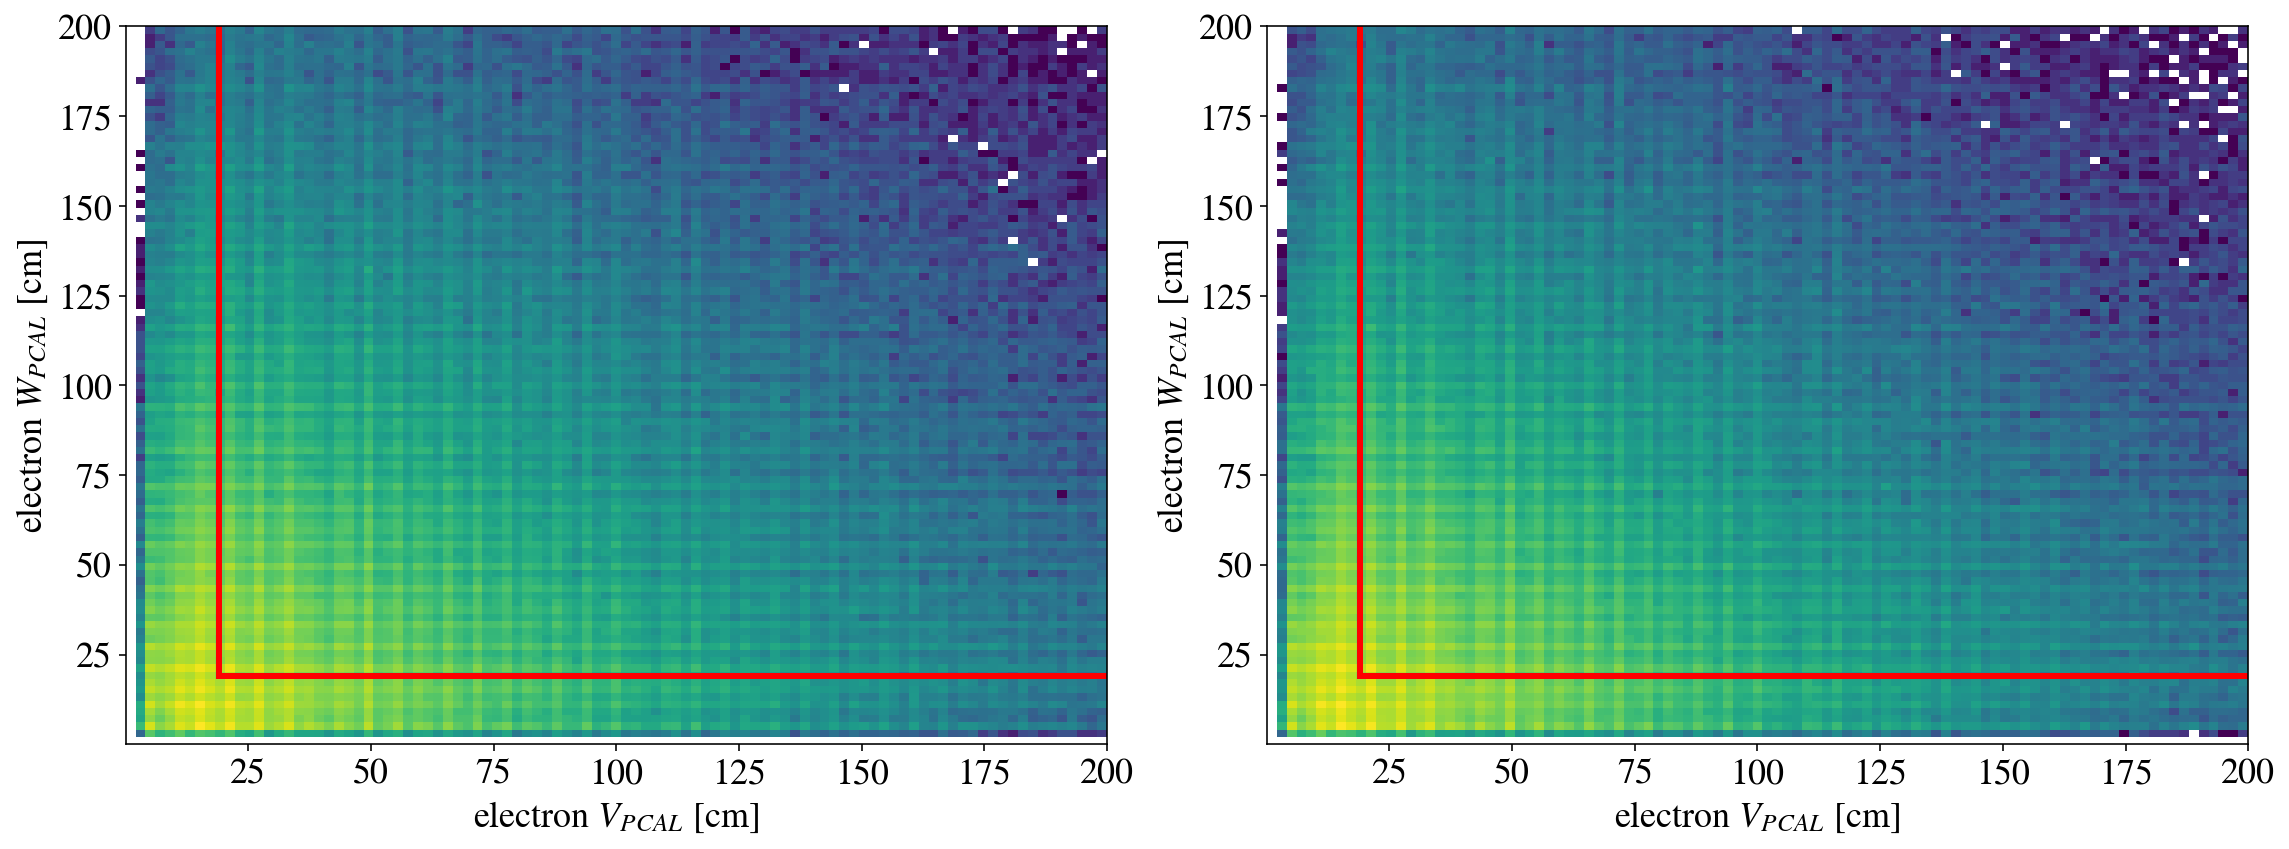

In [18]:
Vminlim,Vmaxlim,Wminlim,Wmaxlim,Nbins = 0.01,200,0.01,200,100
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
    
    x = Events_previous_cuts[pi_ch].e_PCAL_V
    y = Events_previous_cuts[pi_ch].e_PCAL_W
    ax = fig.add_subplot(1,2,pi_idx)

    plt.hist2d( x, y, bins=(np.linspace(Vminlim,Vmaxlim,Nbins),np.linspace(Wminlim,Wmaxlim,Nbins)) ,norm=LogNorm() )
    set_axes(ax,'electron $V_{PCAL}$ [cm]','electron $W_{PCAL}$ [cm]',fontsize=18, xlim=(Vminlim,Vmaxlim),ylim=(Wminlim,Wmaxlim),do_add_grid=False)
    
    plt.plot([Vmin,   Vmin],[Wmin, Wmaxlim],'-r',linewidth=3);
    plt.plot([Vmin,Vmaxlim],[Wmin, Wmin],'-r',linewidth=3);

save_figure(filename = figures_path + 'e_PCAL_W_vs_e_PCAL_V' + '.pdf')

### 2.2 PCAL minimum energy deposition cut $PCAL_{dep} > 70$ MeV

In [19]:
previous_cut_label = 'PCAL %d<V & %d<W'%(Vmin,Wmin)
Events_previous_cuts = dict()

cut_idx = 2
e_E_PCALmin = float(cuts[cuts.parameter=='e_E_PCAL_min'].value)
cut_label = '%.0f MeV < PCAL Edep'%(e_E_PCALmin*1e3)

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (e_E_PCALmin < Events_previous_cuts[pi_ch].e_E_PCAL)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  $f_{\pi^+}$ [%]  \
0              No cut     1000000     1000000            100.0   
1    PCAL 19<V & 19<W      569181      559388             56.9   
2  70 MeV < PCAL Edep      568644      558978             56.9   

   $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01            100.0                 1.4e-01  
1                 9.5e-02             55.9                 9.3e-02  
2                 9.4e-02             55.9                 9.3e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_E_PCAL.pdf


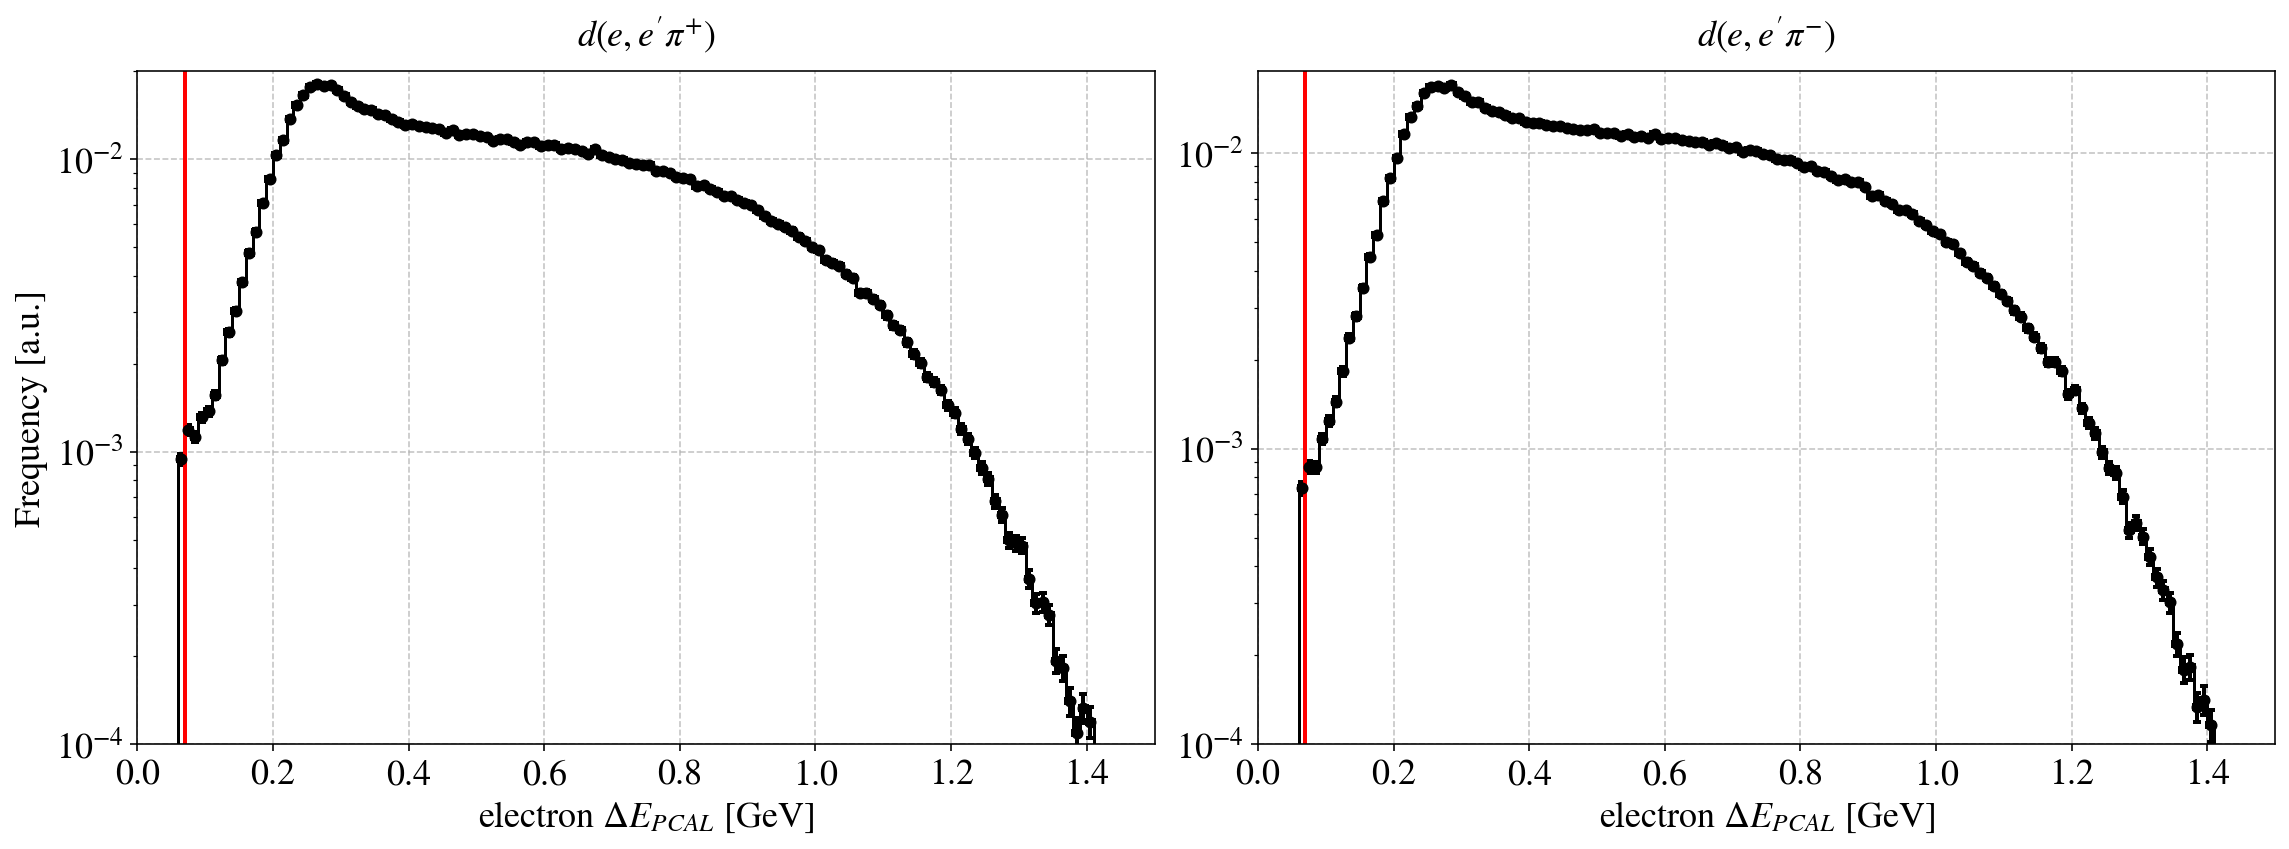

In [20]:
xmin,xmax,Nbins = 0.0,1.5,75*2+1
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = Events_previous_cuts[pi_ch].e_E_PCAL
    ax = fig.add_subplot(1,2,pi_idx)
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True,color='k')
    ymax = 1.1*np.max(h+h_err)
    set_axes(ax,'electron $\Delta E_{PCAL}$ [GeV]',
             'Frequency [a.u.]' if pi_idx==1 else '',
             title="$d(e,e'"+pi_label+")$",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([e_E_PCALmin,e_E_PCALmin],[1e-7,ymax],'-r',linewidth=2);

save_figure(filename = figures_path + 'e_E_PCAL' + '.pdf')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_ECAL_vs_e_PCAL.pdf


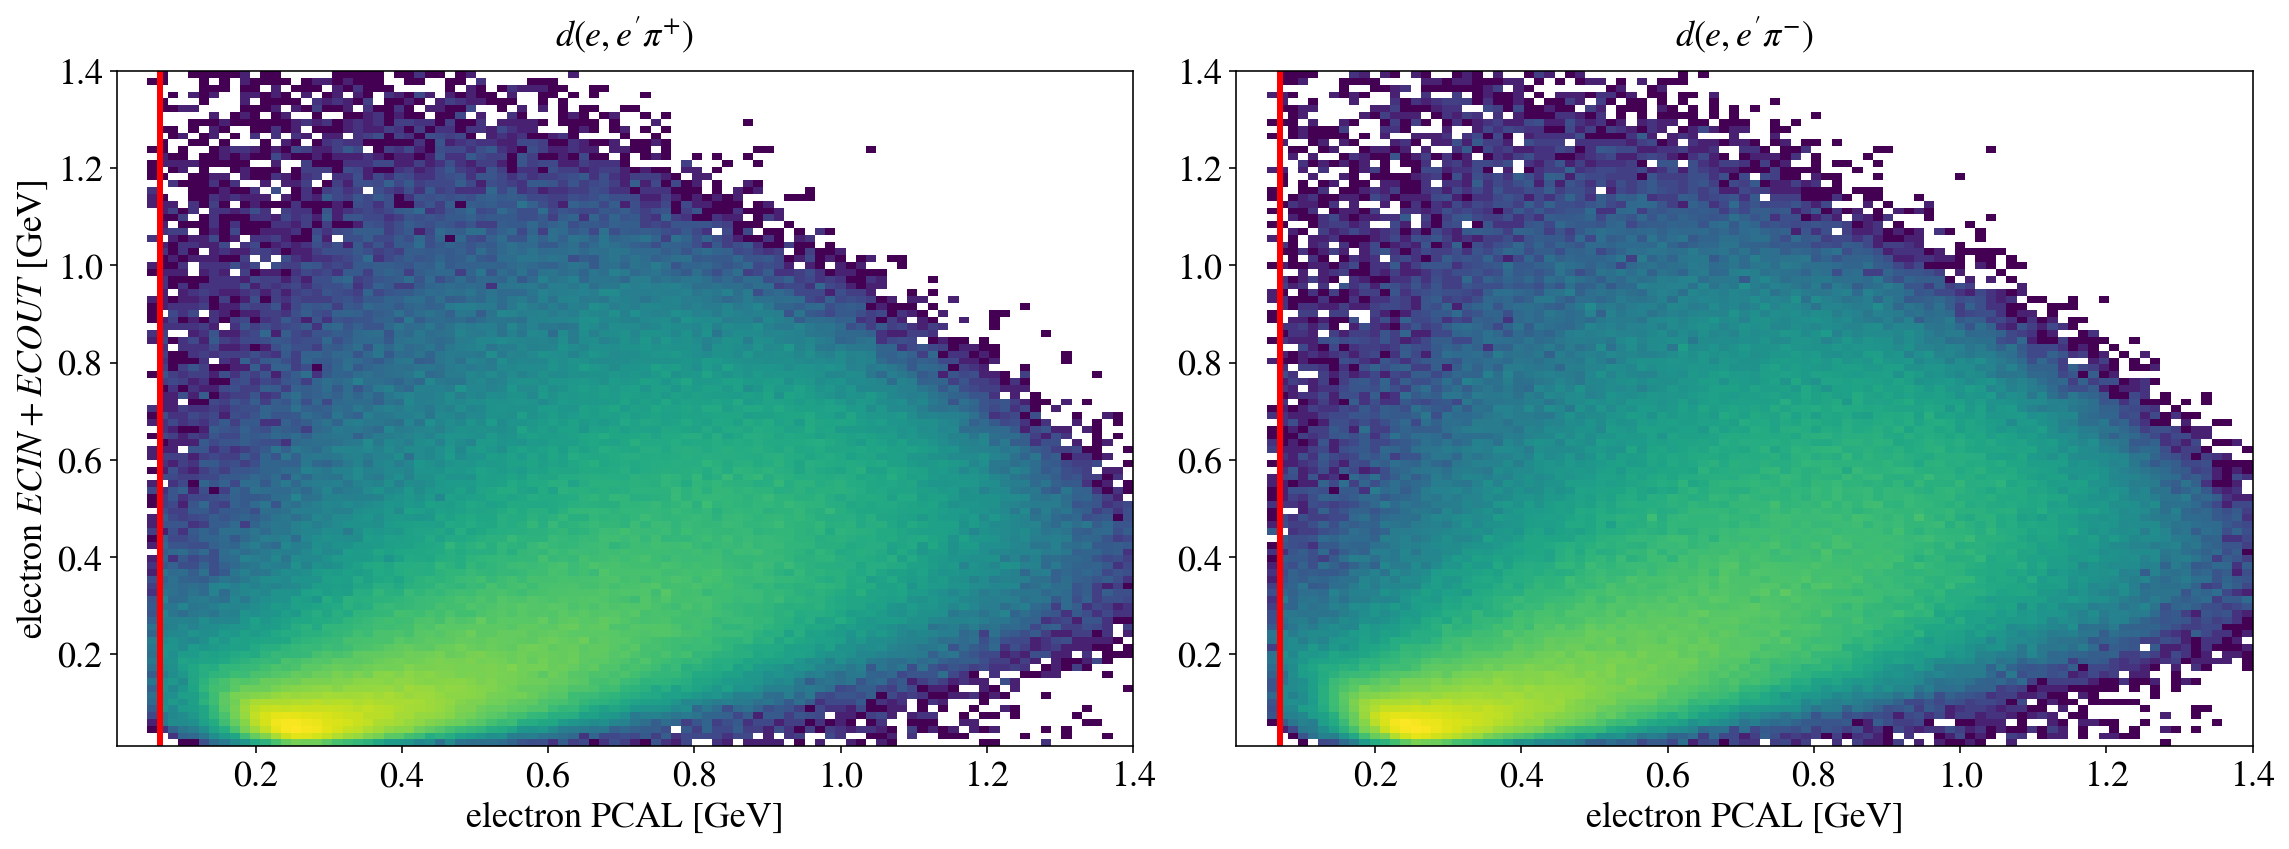

In [21]:
xmin,xmax,ymin,ymax,Nbins = 0.01,1.4,0.01,1.4,100
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = Events_previous_cuts[pi_ch].e_E_PCAL
    y = Events_previous_cuts[pi_ch].e_E_ECIN + Events_previous_cuts[pi_ch].e_E_ECOUT

    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)), 
               norm=LogNorm() );
    set_axes(ax,'electron PCAL [GeV]','electron $ECIN + ECOUT$ [GeV]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18)
    plt.plot([e_E_PCALmin,e_E_PCALmin],ax.get_ylim(),'-r',linewidth=3);
    
save_figure(filename = figures_path + 'e_ECAL_vs_e_PCAL' + '.pdf')

### 2.3 Calorimetry sampling fraction cut  $\Delta E_{dep}(PCAL + ECIN + ECOUT) / p_e > 0.17$ 

In [22]:
previous_cut_label = '%.0f MeV < PCAL Edep'%(e_E_PCALmin*1e3)
Events_previous_cuts = dict()

cut_idx = 3
SamplingFraction_min = float(cuts[cuts.parameter=='SamplingFraction_min'].value)
cut_label = '$(PCAL + ECIN + ECOUT)/p_e > %.2f$'%SamplingFraction_min

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ SamplingFraction_min < (Events_previous_cuts[pi_ch].e_E_PCAL 
                                                                                       + Events_previous_cuts[pi_ch].e_E_ECIN
                                                                                       + Events_previous_cuts[pi_ch].e_E_ECOUT)/(Events_previous_cuts[pi_ch].e_P)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                              No cut     1000000     1000000   
1                    PCAL 19<V & 19<W      569181      559388   
2                  70 MeV < PCAL Edep      568644      558978   
3  $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/SamplingFraction_vs_e_P.pdf


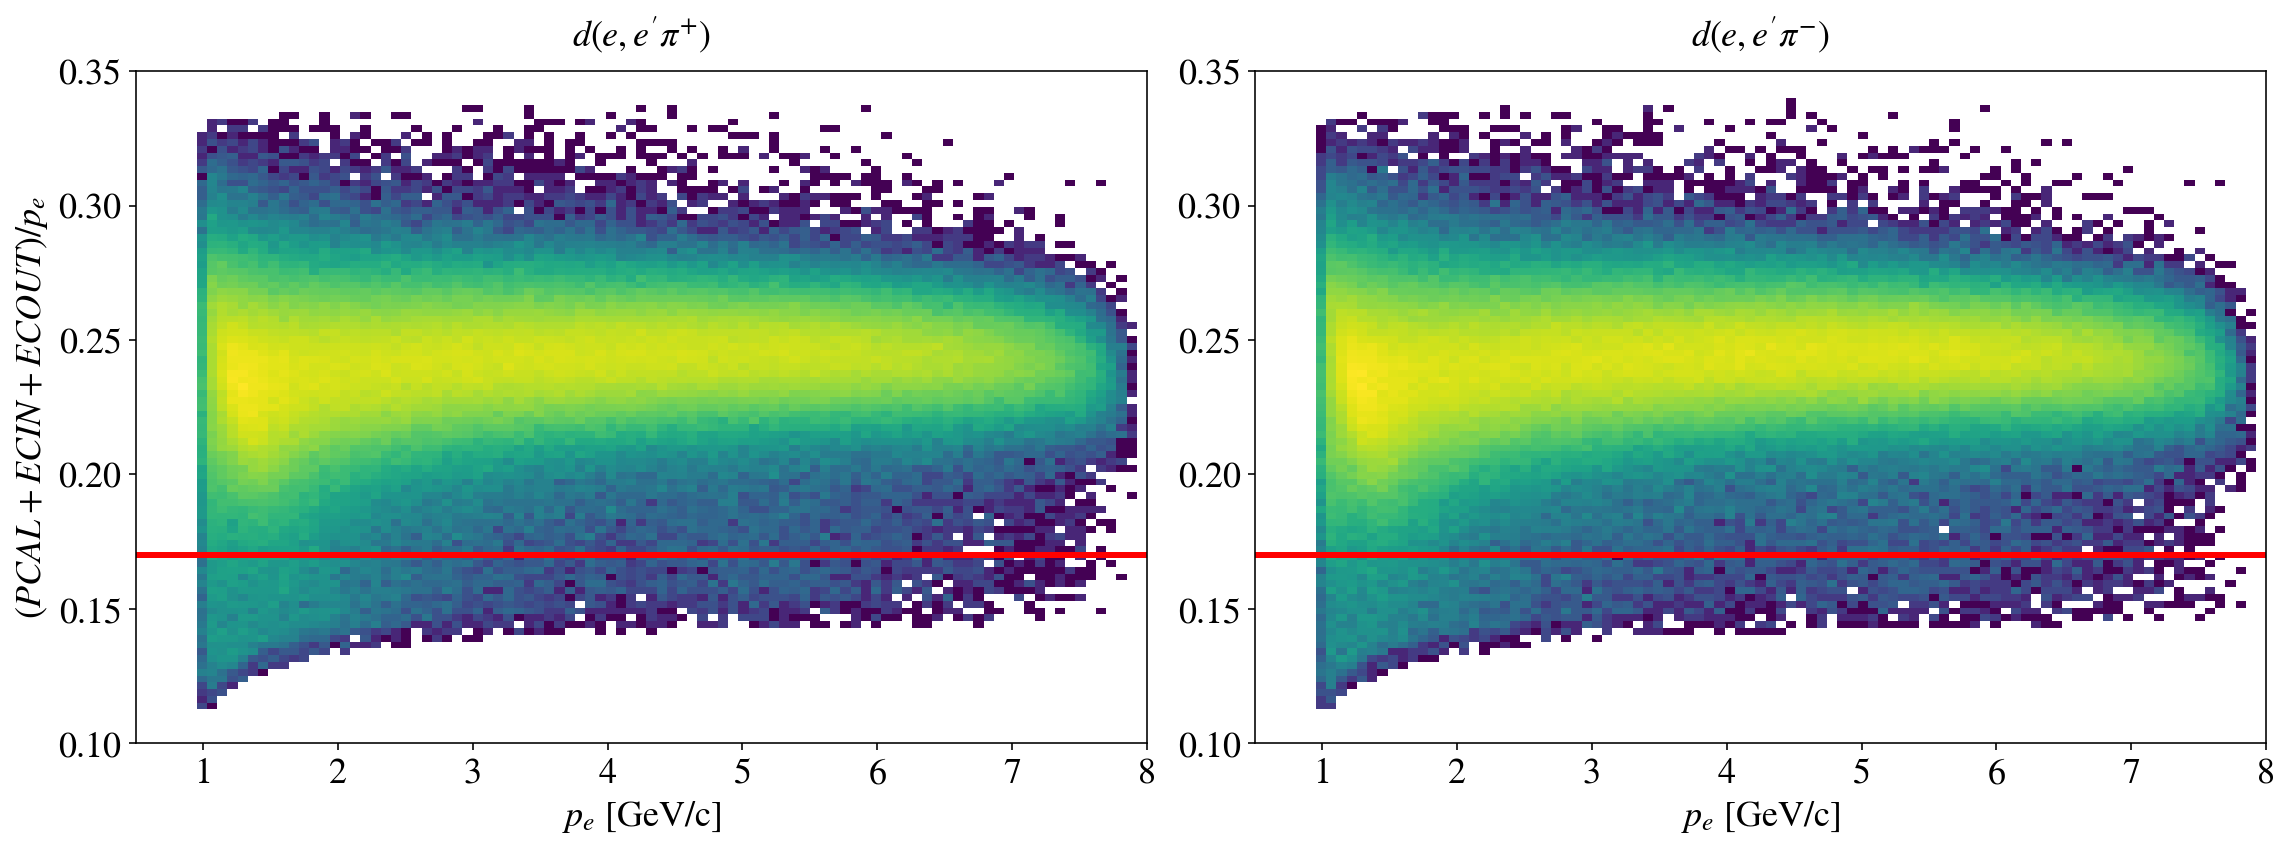

In [23]:
xmin,xmax,ymin,ymax,Nbins = .5,8,0.1,0.35,100

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].e_P
    y = (Events_previous_cuts[pi_ch].e_E_PCAL + Events_previous_cuts[pi_ch].e_E_ECIN + Events_previous_cuts[pi_ch].e_E_ECOUT)/Events_previous_cuts[pi_ch].e_P

    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)), 
           norm=LogNorm() );
    plt.plot([0,10],[SamplingFraction_min,SamplingFraction_min],'-r',linewidth=3);
    set_axes(ax,'$p_e$ [GeV/c]','$(PCAL + ECIN + ECOUT)/p_e$' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18)
# cbar=plt.colorbar()
# cbar.ax.tick_params(axis="both", labelsize=21)
save_figure(filename = figures_path + 'SamplingFraction_vs_e_P' + '.pdf')

### 2.4 $ \frac{E_{ECIN}}{p} > 0.2 - \frac{E_{PCAL}}{p}$ 

In [24]:
previous_cut_label = '$(PCAL + ECIN + ECOUT)/p_e > %.2f$'%SamplingFraction_min
Events_previous_cuts = dict()

cut_idx = 4
cut_label = '$\\frac{ECIN}{p} > 0.2 - \\frac{PCAL}{p}$' 

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ Events_previous_cuts[pi_ch].e_E_ECIN/Events_previous_cuts[pi_ch].e_P > 
                                                              (0.2 - Events_previous_cuts[pi_ch].e_E_PCAL/Events_previous_cuts[pi_ch].e_P)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                   No cut     1000000     1000000   
1                         PCAL 19<V & 19<W      569181      559388   
2                       70 MeV < PCAL Edep      568644      558978   
3       $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4  $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   
4             52.1                 8.9e-02             51.4   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02  
4                 8.8e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_ECIN_vs_e_PCAL.pdf


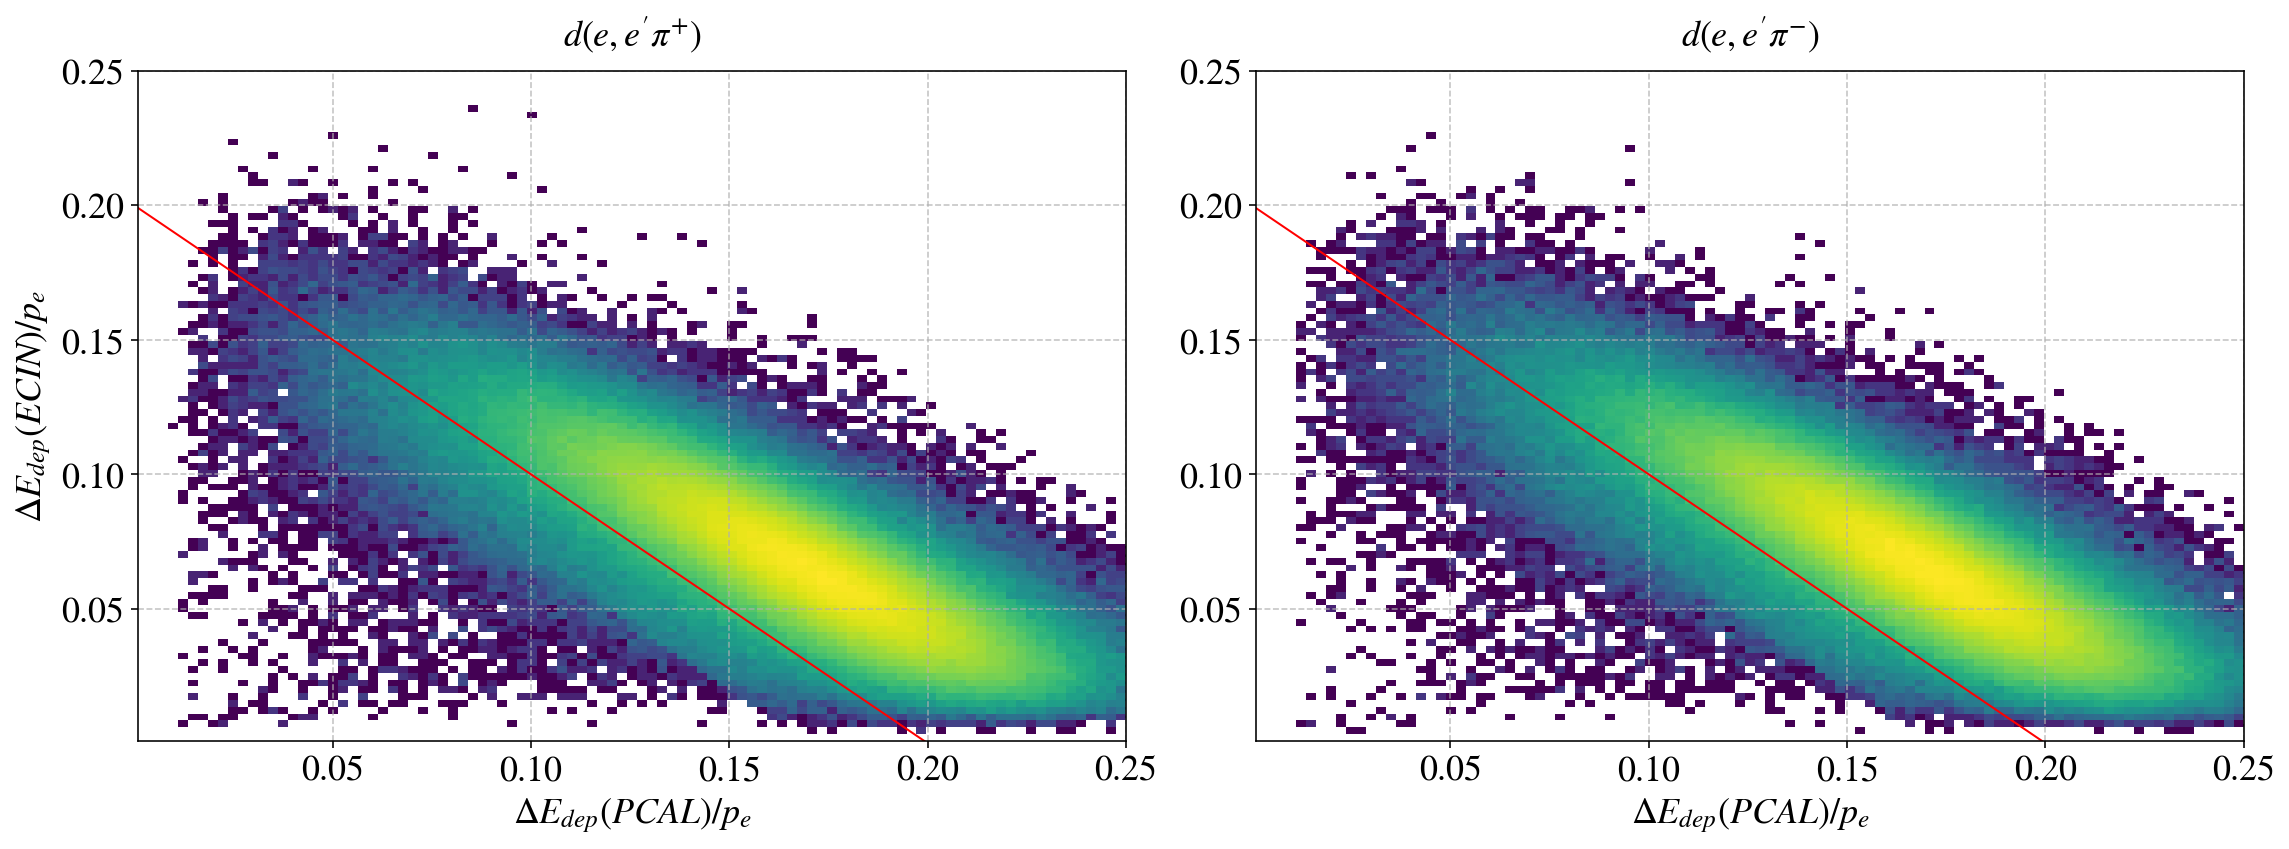

In [25]:
xmin,xmax,ymin,ymax,Nbins = 0.001,0.25,0.001,0.25,100
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].e_E_PCAL/Events_previous_cuts[pi_ch].e_P
    y = Events_previous_cuts[pi_ch].e_E_ECIN/Events_previous_cuts[pi_ch].e_P
    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)),  norm=LogNorm() );
    plt.plot([0,0.2],[0.2,0],'-r',linewidth=1);
    set_axes(ax,'$\Delta E_{dep}(PCAL) / p_e$','$\Delta E_{dep}(ECIN) / p_e$' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, do_add_grid=True)
# cbar=plt.colorbar()
# cbar.ax.tick_params(axis="both", labelsize=21)

save_figure(filename = figures_path + 'e_ECIN_vs_e_PCAL' + '.pdf')

### 2.5 Vertex $z$ position $-13.0 \mathrm{cm} < v_z < + 12.0 \mathrm{cm}$ 

In [26]:
previous_cut_label = '$\\frac{ECIN}{p} > 0.2 - \\frac{PCAL}{p}$' 
Events_previous_cuts = dict()

cut_idx = 5
Ve_z_min = -13.0
Ve_z_max = 12.0
cut_label = '$-13.0< v^e_z < +12.0$' 

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (Ve_z_min < Events_previous_cuts[pi_ch].Ve_z) & (Events_previous_cuts[pi_ch].Ve_z < Ve_z_max)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                   No cut     1000000     1000000   
1                         PCAL 19<V & 19<W      569181      559388   
2                       70 MeV < PCAL Edep      568644      558978   
3       $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4  $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                   $-13.0< v^e_z < +12.0$      517404      510703   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   
4             52.1                 8.9e-02             51.4   
5             51.7                 8.9e-02             51.1   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02  
4                 8.8e-02  
5                 8.8e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Ve_z.pdf


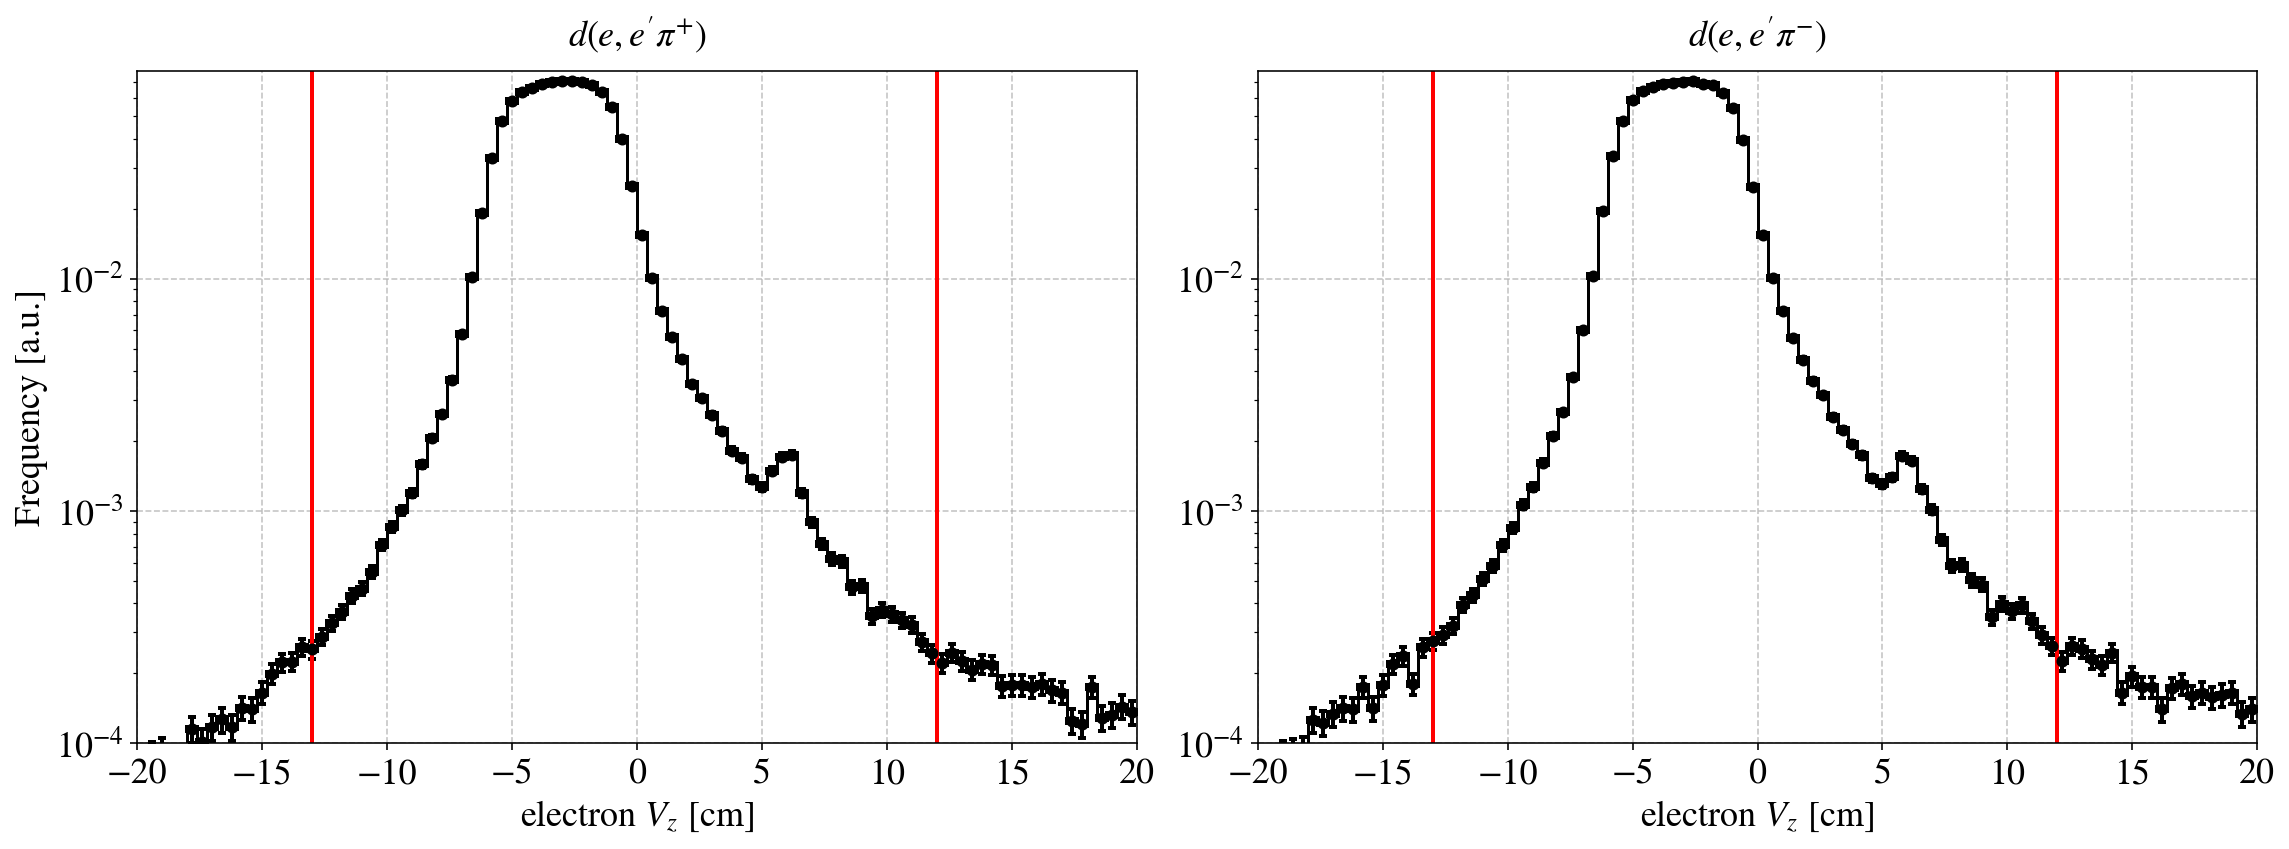

In [27]:
# electron vertex z-position
xmin,xmax,Nbins = -20,20,101

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].Ve_z
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'electron $V_z$ [cm]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([Ve_z_min,Ve_z_min],[1e-4,ymax],'-r',linewidth=2);
    plt.plot([Ve_z_max,Ve_z_max],[1e-4,ymax],'-r',linewidth=2);

save_figure(filename = figures_path + 'Ve_z' + '.pdf')

### 2.6 $|v_z(e) - v_z(\pi)| < 20.0$ cm 

In [28]:
previous_cut_label = '$-13.0< v^e_z < +12.0$' 
Events_previous_cuts = dict()

cut_idx = 6
dVe_z_max = float(cuts[cuts.parameter=='(Ve-Vpi)_z_max'].value)
cut_label = '$|v_z(e) - v_z(\pi)| < %.1f$ cm'%dVe_z_max

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ np.abs(Events_previous_cuts[pi_ch].Vpi_z - Events_previous_cuts[pi_ch].Ve_z) < dVe_z_max ]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                   No cut     1000000     1000000   
1                         PCAL 19<V & 19<W      569181      559388   
2                       70 MeV < PCAL Edep      568644      558978   
3       $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4  $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                   $-13.0< v^e_z < +12.0$      517404      510703   
6          $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   
4             52.1                 8.9e-02             51.4   
5             51.7                 8.9e-02             51.1   
6             48.8                 8.5e-02             49.1   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02  
4                 8.8e-02  
5                 8.8e-02  
6                 8.6e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Vpi_z_diff_Ve_z.pdf


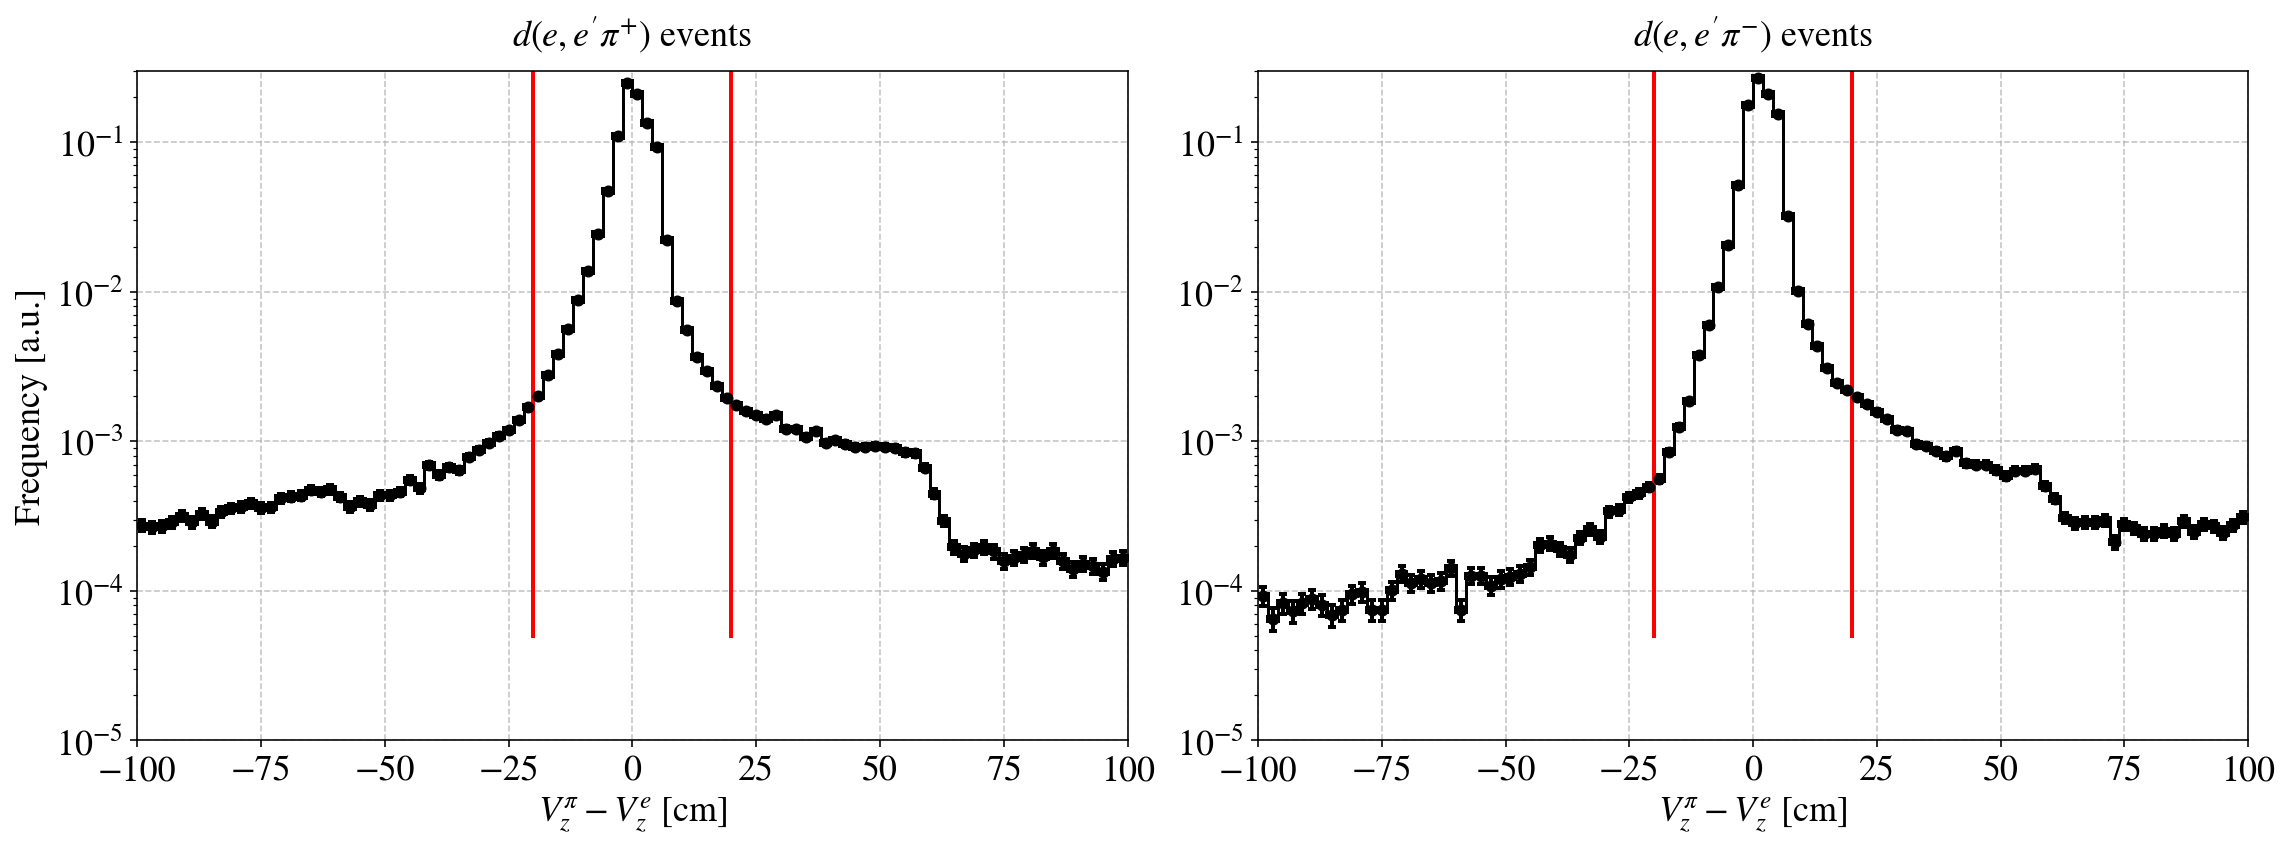

In [29]:
# Difference between electron and pion vertex z-position
fig = plt.figure(figsize=(16,6),tight_layout=True)
xmin,xmax,Nbins = -100,100,101


for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    x = np.array(Events_previous_cuts[pi_ch].Vpi_z - Events_previous_cuts[pi_ch].Ve_z)

    ax = fig.add_subplot(1,2,pi_idx)
    #plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    plot_step_hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    set_axes(ax,'$V^\pi_z - V^e_z$ [cm]',
             'Frequency [a.u.]' if pi_idx==1 else '',
             remove_ticks_y=False if pi_idx==1 else True,
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18, xlim=(xmin,xmax),ylim=(1e-5,3e-1),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([dVe_z_max,dVe_z_max],[5e-5,1],'-r',linewidth=2);
    plt.plot([-dVe_z_max,-dVe_z_max],[5e-5,1],'-r',linewidth=2);

save_figure(filename = figures_path + 'Vpi_z_diff_Ve_z' + '.pdf')

### 2.7 Cut on $\chi^2_{PID}$

In [30]:
def chi2min(p_arr, pi_ch='piplus'):
    if (pi_ch=="piplus"):     C = 0.88;
    elif (pi_ch=="piminus") : C = 0.93;        
    chi2min_arr = []
    for p in p_arr: chi2min_arr.append(-C*3);
    return np.array(chi2min_arr)
    
def chi2max(p_arr, pi_ch='piplus'):
    if (pi_ch=="piplus"):    C = 0.88;
    elif (pi_ch=="piminus"): C = 0.93;
    
    chi2max_arr = []
    for p in p_arr:
        if (p<2.44):         chi2max_arr.append(C*3);
        elif (p<4.6):        chi2max_arr.append(C*( 0.00869 + 14.98587*np.exp(-p/1.18236)+1.81751*np.exp(-p/4.86394) )   );
        else:                chi2max_arr.append(C*( -1.14099 + 24.14992*np.exp(-p/1.36554) + 2.66876*np.exp(-p/6.80552)) );
    return np.array(chi2max_arr)


In [31]:
previous_cut_label = '$|v_z(e) - v_z(\pi)| < %.1f$ cm'%dVe_z_max
Events_previous_cuts = dict()

cut_idx = 7
cut_label = 'Cut on $\chi^2_{PID}$'

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    df = Events_previous_cuts[pi_ch]
    df_after_cut = df[ (chi2min(df.pi_P,pi_ch) <= df.pi_chi2PID)                                 
                      & (df.pi_chi2PID <= chi2max(df.pi_P,pi_ch)) ]

    Events[pi_ch+' '+cut_label] = df_after_cut
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                   No cut     1000000     1000000   
1                         PCAL 19<V & 19<W      569181      559388   
2                       70 MeV < PCAL Edep      568644      558978   
3       $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4  $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                   $-13.0< v^e_z < +12.0$      517404      510703   
6          $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                    Cut on $\chi^2_{PID}$      304425      213501   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   
4             52.1                 8.9e-02             51.4   
5             51.7                 8.9e-02             51.1   
6             48.8                 8.5e-02             49.1   
7             30.4                 6.3e-02             21.4   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02  
4                 8.8e-02  
5                 8.8e-02  
6                 8.6e-02  
7                 5.1e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/pi_chi2PID_vs_pi_P.pdf
Note: here we do not show some 50% of the pions for which the chi2 is very poor 


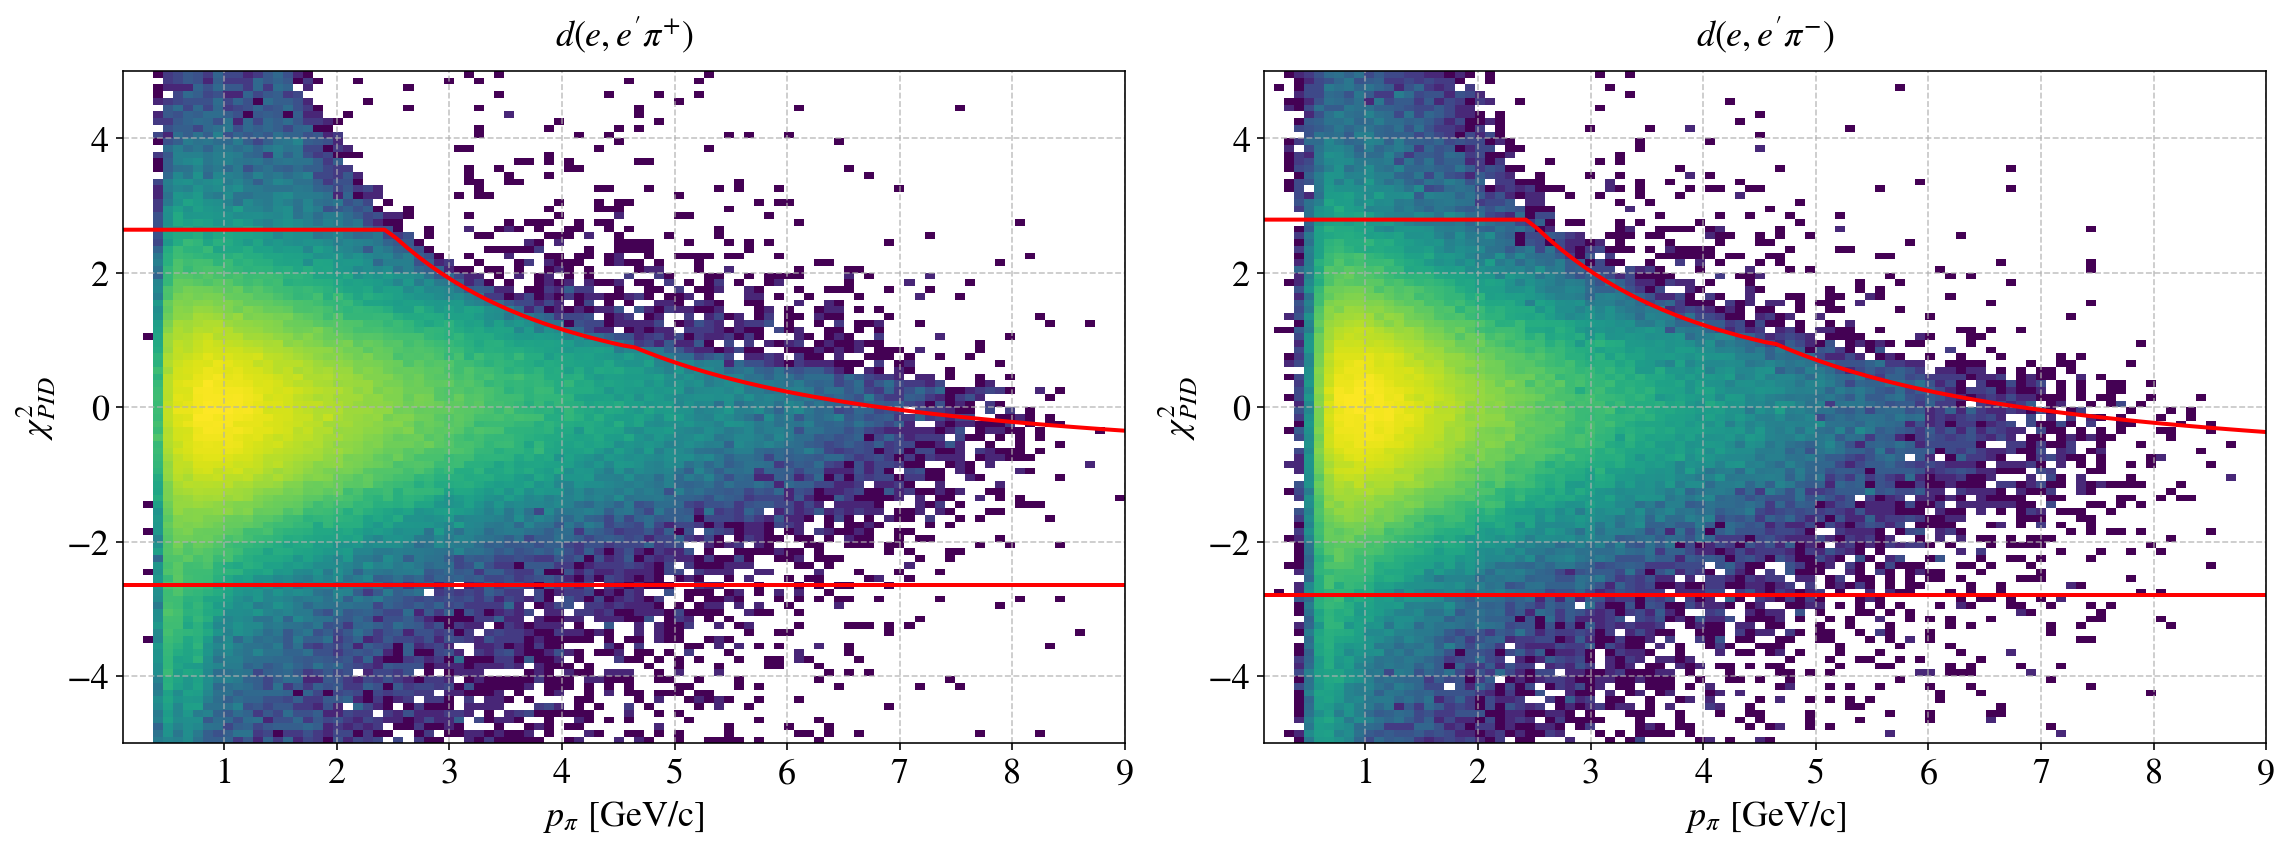

In [32]:
xmin,xmax,ymin,ymax,Nbins = 0.1,9,-5,5,101
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):

    ax = fig.add_subplot(1,2,pi_idx)
    
    x = np.array(Events_previous_cuts[pi_ch].pi_P)
    y = np.array(Events_previous_cuts[pi_ch].pi_chi2PID)
    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)),  norm=LogNorm() );    
    set_axes(ax,'$p_\pi$ [GeV/c]','$\chi^2_{PID}$',title="$d(e,e'"+pi_label+")$",ylim=(ymin,ymax),fontsize=18, do_add_grid=True)
    
    # The event-selection limit
    p_e_fit = np.linspace(0,10,100)
    plt.plot(p_e_fit, chi2min(p_e_fit,pi_ch),'-r', linewidth=2)
    plt.plot(p_e_fit, chi2max(p_e_fit,pi_ch),'-r', linewidth=2)    

    # cbar=plt.colorbar()
    # cbar.ax.tick_params(axis="both", labelsize=21)
save_figure(filename = figures_path + 'pi_chi2PID_vs_pi_P' + '.pdf')
print('Note: here we do not show some 50% of the pions for which the chi2 is very poor ')

### 2.8 DC fiducial cuts

In [33]:
#// Electron in-bending: Using XY cut
#// Elctron out-bending: Using XY cut
#// Hadron in-bending: Using Theta_phi cut
#// Hadron out-bending: Using XY cut

maxparams_xy_in = [[[[-14.563, 0.60032], [-19.6768, 0.58729], [-22.2531, 0.544896]],
     [[-12.7486, 0.587631], [-18.8093, 0.571584], [-19.077, 0.519895]],
     [[-11.3481, 0.536385], [-18.8912, 0.58099], [-18.8584, 0.515956]],
     [[-10.7248, 0.52678], [-18.2058, 0.559429], [-22.0058, 0.53808]],
     [[-16.9644, 0.688637], [-17.1012, 0.543961], [-21.3974, 0.495489]],
     [[-13.4454, 0.594051], [-19.4173, 0.58875], [-22.8771, 0.558029]]],
    [[[-6.2928, 0.541828], [-16.7759, 0.57962], [-32.5232, 0.599023]],
     [[-6.3996, 0.543619], [-16.7429, 0.578472], [-32.5408, 0.600826]],
     [[-5.49712, 0.53463], [-16.1294, 0.576928], [-32.5171, 0.597735]],
     [[-6.4374, 0.54839], [-16.9511, 0.582143], [-33.0501, 0.59995]],
     [[-5.30128, 0.529377], [-16.1229, 0.579019], [-30.7768, 0.593861]],
     [[-5.89201, 0.541124], [-16.1245, 0.575001], [-32.2617, 0.601506]]],
    [[[-6.3618, 0.546384], [-17.0277, 0.582344], [-34.9276, 0.612875]],
     [[-6.36432, 0.546268], [-15.8404, 0.574102], [-33.0627, 0.599142]],
     [[-6.34357, 0.548411], [-16.0496, 0.575913], [-34.8535, 0.610211]],
     [[-5.8568, 0.541784], [-16.1124, 0.576473], [-32.8547, 0.599033]],
     [[-5.91941, 0.536801], [-15.726, 0.575211], [-34.0964, 0.606777]],
     [[-5.55498, 0.536609], [-15.9853, 0.579705], [-33.4886, 0.606439]]],
    [[[-12.594, 0.613062], [-18.4504, 0.588136], [-16.3157, 0.529461]],
     [[-12.3417, 0.61231], [-18.1498, 0.590748], [-13.8106, 0.52335]],
     [[-12.1761, 0.609307], [-15.919, 0.572156], [-13.0598, 0.5194]],
     [[-12.5467, 0.612645], [-16.2129, 0.572974], [-12.8611, 0.51252]],
     [[-13.0976, 0.615928], [-16.9233, 0.580972], [-13.0906, 0.519738]],
     [[-12.884, 0.622133], [-17.2566, 0.585572], [-12.1874, 0.510124]]],
    [[[-6.51157, 0.545763], [-16.4246, 0.583603], [-32.2001, 0.60425]],
     [[-6.21169, 0.541872], [-16.8484, 0.591172], [-31.7785, 0.606234]],
     [[-5.89452, 0.54464], [-16.612, 0.591506], [-29.9143, 0.589656]],
     [[-6.68908, 0.553374], [-16.2993, 0.585165], [-30.252, 0.59519]],
     [[-6.17185, 0.540496], [-16.7197, 0.591664], [-31.619, 0.608306]],
     [[-5.7526, 0.541761], [-16.2054, 0.587326], [-31.3653, 0.604081]]],
    [[[-11.8798, 0.62389], [-20.2212, 0.610786], [-16.4137, 0.51337]],
     [[-12.0817, 0.631621], [-20.7511, 0.610844], [-16.9407, 0.522958]],
     [[-9.72746, 0.605471], [-20.4903, 0.622337], [-15.3363, 0.520589]],
     [[-12.4566, 0.627481], [-20.238, 0.606098], [-20.7651, 0.56974]],
     [[-11.6712, 0.622265], [-18.2649, 0.591062], [-19.2569, 0.580894]],
     [[-12.0943, 0.630674], [-22.4432, 0.633366], [-17.2197, 0.537965]]]];

minparams_xy_in = [ #][6][6][3][2]
    [[[12.2692, -0.583057], [17.6233, -0.605722], [19.7018, -0.518429]],
     [[12.1191, -0.582662], [16.8692, -0.56719], [20.9153, -0.534871]],
     [[11.4562, -0.53549], [19.3201, -0.590815], [20.1025, -0.511234]],
     [[13.202, -0.563346], [20.3542, -0.575843], [23.6495, -0.54525]],
     [[12.0907, -0.547413], [17.1319, -0.537551], [17.861, -0.493782]],
     [[13.2856, -0.594915], [18.5707, -0.597428], [21.6804, -0.552287]]],
    [[[5.35616, -0.531295], [16.9702, -0.583819], [36.3388, -0.612192]],
     [[6.41665, -0.543249], [17.3455, -0.584322], [37.1294, -0.61791]],
     [[6.86336, -0.550492], [17.2747, -0.575263], [39.6389, -0.625934]],
     [[6.82938, -0.558897], [17.8618, -0.599931], [39.3376, -0.631517]],
     [[6.05547, -0.54347], [15.7765, -0.569165], [35.6589, -0.611349]],
     [[6.3468, -0.544882], [16.7144, -0.578363], [38.2501, -0.617055]]],
    [[[6.70668, -0.558853], [17.0627, -0.587751], [36.1194, -0.617417]],
     [[6.3848, -0.542992], [16.6355, -0.581708], [34.6781, -0.609794]],
     [[6.36802, -0.539521], [15.9829, -0.569165], [32.5691, -0.59588]],
     [[5.94912, -0.546191], [18.0321, -0.601764], [36.5238, -0.619185]],
     [[5.65108, -0.541684], [15.5009, -0.567131], [34.0489, -0.602048]],
     [[6.71064, -0.547956], [16.4449, -0.577051], [34.4375, -0.602515]]],
    [[[12.4734, -0.608063], [16.1064, -0.575034], [16.0751, -0.536452]],
     [[12.1936, -0.6034], [15.9302, -0.571271], [14.2791, -0.520157]],
     [[12.216, -0.600017], [14.8741, -0.56304], [11.1766, -0.498955]],
     [[12.7941, -0.616044], [17.1516, -0.583616], [11.6077, -0.500028]],
     [[12.7448, -0.611315], [16.2814, -0.572461], [13.1033, -0.506663]],
     [[12.7949, -0.612051], [16.1565, -0.569143], [12.9295, -0.504203]]],
    [[[7.19022, -0.562083], [16.5946, -0.591266], [31.9033, -0.589167]],
     [[7.80002, -0.571429], [17.8587, -0.595543], [36.5772, -0.630136]],
     [[7.96121, -0.569485], [17.8085, -0.592936], [37.553, -0.632848]],
     [[7.52041, -0.566112], [17.3385, -0.603462], [33.7712, -0.606047]],
     [[7.35796, -0.562782], [15.2865, -0.57433], [29.8283, -0.574685]],
     [[7.80003, -0.571429], [16.1751, -0.583286], [39.1972, -0.642803]]],
    [[[13.4466, -0.633911], [22.0097, -0.62205], [18.8862, -0.519652]],
     [[13.0534, -0.626648], [20.2994, -0.60581], [19.3973, -0.573994]],
     [[12.547, -0.62145], [18.9322, -0.596491], [16.2331, -0.546036]],
     [[14.5339, -0.64585], [20.0211, -0.608462], [19.0405, -0.563914]],
     [[12.7388, -0.617954], [21.1677, -0.621012], [15.4502, -0.525165]],
     [[13.4019, -0.63075], [16.6584, -0.554797], [19.0302, -0.55004]]]];

maxparams_xy_out= [ # [6][6][3][2] 
    [[[-9.86221, 0.565985], [-16.4397, 0.569087], [-29.7787, 0.586842]],
     [[-10.2065, 0.565541], [-16.5554, 0.571394], [-28.933, 0.582078]],
     [[-8.48034, 0.550706], [-16.4397, 0.569087], [-27.1037, 0.563767]],
     [[-6.77188, 0.53062], [-16.4397, 0.569087], [-30.485, 0.587534]],
     [[-8.00705, 0.543502], [-16.4038, 0.571178], [-27.7934, 0.573472]],
     [[-10.3328, 0.571942], [-16.69, 0.575252], [-30.8177, 0.592418]]],
    [[[-5.43811, 0.550931], [-17.1906, 0.57936], [-18.552, 0.546789]],
     [[-5.46281, 0.549659], [-18.0351, 0.588876], [-17.6981, 0.549803]],
     [[-3.26087, 0.531677], [-16.3762, 0.578005], [-17.6831, 0.55049]],
     [[-4.5985, 0.542017], [-17.2735, 0.581566], [-16.7013, 0.538853]],
     [[-6.83053, 0.561019], [-16.5082, 0.579816], [-18.0846, 0.553592]],
     [[-5.67358, 0.5558], [-18.8196, 0.594965], [-19.4333, 0.560965]]],
    [[[-12.6317, 0.611023], [-16.5644, 0.578978], [-11.5882, 0.496324]],
     [[-12.8886, 0.614807], [-17.0847, 0.584072], [-14.9561, 0.532125]],
     [[-11.4504, 0.600574], [-16.3862, 0.57885], [-12.3309, 0.515431]],
     [[-12.2256, 0.609801], [-16.2134, 0.574306], [-12.7661, 0.515787]],
     [[-12.6311, 0.611069], [-16.2486, 0.577577], [-12.6783, 0.519597]],
     [[-12.6937, 0.615423], [-16.1427, 0.57847], [-11.5156, 0.509458]]],
    [[[-5.95834, 0.538479], [-15.8909, 0.570164], [-30.2922, 0.586335]],
     [[-6.15277, 0.542134], [-16.1129, 0.573794], [-31.6024, 0.592681]],
     [[-6.12341, 0.542023], [-16.1611, 0.575971], [-29.8604, 0.581528]],
     [[-6.37691, 0.546536], [-16.8501, 0.580239], [-30.0623, 0.580497]],
     [[-5.96605, 0.537402], [-15.7154, 0.5704], [-31.2955, 0.594146]],
     [[-5.86704, 0.539556], [-16.2268, 0.580945], [-31.2345, 0.590849]]],
    [[[-11.7796, 0.614043], [-19.0763, 0.595015], [-18.804, 0.559538]],
     [[-12.4399, 0.623126], [-19.1733, 0.600646], [-17.675, 0.557016]],
     [[-10.4158, 0.605483], [-18.0044, 0.595497], [-17.5441, 0.556504]],
     [[-12.1552, 0.617782], [-19.7134, 0.603519], [-17.3756, 0.549676]],
     [[-11.3901, 0.612121], [-18.2429, 0.596796], [-10.0097, 0.482578]],
     [[-12.5004, 0.626384], [-19.9266, 0.60993], [-16.4668, 0.543148]]],
    [[[-5.60572, 0.537153], [-16.3196, 0.582537], [-32.4336, 0.601487]],
     [[-5.52369, 0.532985], [-15.2055, 0.568935], [-31.9046, 0.600079]],
     [[-5.78558, 0.546316], [-16.3328, 0.583765], [-36.0074, 0.617008]],
     [[-5.82321, 0.542839], [-15.9551, 0.580441], [-31.4304, 0.597132]],
     [[-5.36526, 0.535923], [-15.9219, 0.586886], [-30.4245, 0.599613]],
     [[-5.14766, 0.53037], [-14.1986, 0.561504], [-31.7548, 0.60233]]]];

minparams_xy_out= [ # [6][6][3][2]
    [[[8.07831, -0.548881], [16.4382, -0.569075], [33.7768, -0.607402]],
     [[8.51057, -0.551773], [16.7782, -0.571381], [32.2613, -0.600686]],
     [[8.5232, -0.552628], [16.4274, -0.56775], [31.1516, -0.584708]],
     [[7.98845, -0.544571], [16.4381, -0.569077], [31.8093, -0.595237]],
     [[7.46705, -0.538557], [16.7414, -0.573345], [31.1888, -0.586751]],
     [[7.82627, -0.538957], [16.2409, -0.565872], [32.1089, -0.596846]]],
    [[[7.1519, -0.563678], [16.1038, -0.571795], [20.0449, -0.559802]],
     [[6.38228, -0.553174], [16.4526, -0.576382], [19.3523, -0.556484]],
     [[7.11359, -0.561586], [17.2815, -0.578095], [14.9667, -0.53314]],
     [[5.89053, -0.556406], [17.4946, -0.585038], [17.3607, -0.545739]],
     [[7.08253, -0.562099], [15.1516, -0.569192], [16.9665, -0.545949]],
     [[5.53089, -0.546315], [16.4962, -0.574014], [17.9593, -0.545788]]],
    [[[12.4879, -0.610527], [16.7782, -0.575065], [11.7704, -0.511182]],
     [[12.1931, -0.604779], [15.6443, -0.560967], [12.7304, -0.515606]],
     [[12.206, -0.602999], [16.5979, -0.573274], [12.3971, -0.513795]],
     [[11.5538, -0.604186], [16.6974, -0.576753], [12.7385, -0.517811]],
     [[12.9718, -0.611968], [17.7233, -0.583943], [10.6601, -0.49233]],
     [[12.2966, -0.607592], [15.923, -0.564133], [13.9314, -0.525363]]],
    [[[5.92493, -0.539308], [17.4444, -0.586183], [31.6974, -0.591988]],
     [[5.467, -0.525876], [16.0649, -0.570869], [30.5937, -0.590071]],
     [[5.67798, -0.531096], [16.5072, -0.57205], [30.7922, -0.586727]],
     [[6.85795, -0.558336], [14.9425, -0.545596], [31.3159, -0.592865]],
     [[6.0155, -0.545283], [16.0649, -0.570869], [30.6644, -0.587002]],
     [[6.18343, -0.539055], [17.4516, -0.583221], [32.6264, -0.594317]]],
    [[[12.9118, -0.618907], [19.7061, -0.60171], [18.9352, -0.559461]],
     [[13.0612, -0.618743], [19.0954, -0.595406], [19.7019, -0.568119]],
     [[12.4007, -0.613459], [17.544, -0.581147], [12.8175, -0.511017]],
     [[13.3144, -0.625596], [18.9225, -0.594001], [15.1524, -0.530046]],
     [[13.101, -0.620887], [18.5616, -0.595279], [14.8807, -0.533111]],
     [[12.2964, -0.613529], [19.0686, -0.595276], [19.2596, -0.562706]]],
    [[[5.34118, -0.530584], [16.3015, -0.585185], [38.7808, -0.641362]],
     [[6.68051, -0.548747], [16.4236, -0.583598], [38.4718, -0.630423]],
     [[6.87, -0.552602], [16.4285, -0.57977], [36.8889, -0.624053]],
     [[7.15338, -0.565067], [16.9387, -0.595922], [37.2398, -0.624177]],
     [[6.06995, -0.550001], [15.7376, -0.577755], [32.6004, -0.601595]],
     [[6.20459, -0.543148], [14.6326, -0.561623], [39.2154, -0.631762]]]];

#
#//=====Theta_Phi parameters for in-bending =============//
#
maxparams_th_ph_in = [ # [6][6][3][4]
    [[[-37.5489, 27.4543, -1.11484, 0.00522935],
      [-29.7228, 26.7512, -1.52592, 0.0122397],
      [-20.3559, 23.1586, -1.47441, 0.0133898]],
     [[-36.2719, 25.1427, -0.817973, 0.00233912],
      [-28.2118, 25.0664, -1.29748, 0.00947493],
      [-20.6015, 22.9639, -1.39759, 0.012069]],
     [[-34.1013, 25.9343, -1.23555, 0.00959955],
      [-24.0285, 22.9346, -1.165, 0.00846331],
      [-8.04969, 12.5436, -0.268326, 9.03561e-11]],
     [[-48.5546, 36.1076, -2.07362, 0.0161268],
      [-24.7284, 22.9355, -1.12754, 0.00796403],
      [-22.5292, 24.1624, -1.52361, 0.0137042]],
     [[-40.4295, 30.8386, -1.77195, 0.0156563],
      [-26.7149, 23.5322, -1.1011, 0.00715825],
      [-10.9822, 13.8127, -0.312534, 1.32292e-05]],
     [[-38.1396, 28.0524, -1.19166, 0.00613986],
      [-26.1238, 24.3235, -1.28254, 0.00950751],
      [-19.0376, 22.042, -1.32482, 0.0113948]]],
    [[[-1.67037e-08, 12.8334, -0.820443, 0.00818882],
      [-6.23823, 14.8659, -0.776403, 0.00624484],
      [-5.75713, 11.4787, -0.227124, 6.61281e-10]],
     [[-6.09637e-07, 12.7972, -0.813133, 0.00808401],
      [-5.51055, 13.9682, -0.639287, 0.00441366],
      [-7.90046, 12.5383, -0.271117, 1.86929e-10]],
     [[-2.84217e-14, 13.0836, -0.864047, 0.00869759],
      [-6.78639, 15.3367, -0.827197, 0.00677168],
      [-4.8928, 11.1884, -0.221965, 1.51263e-10]],
     [[-3.8595e-09, 12.9673, -0.841224, 0.0083938],
      [-4.01784, 12.9989, -0.557548, 0.00367493],
      [-1.95023, 9.69687, -0.157901, 5.33239e-09]],
     [[-6.43496e-10, 12.9804, -0.850651, 0.00863353],
      [-5.10299, 13.9958, -0.671087, 0.00489619],
      [-6.03313, 11.7973, -0.249435, 1.2754e-11]],
     [[-2.94932e-10, 13.1054, -0.859032, 0.00848181],
      [-6.05945, 14.7331, -0.742818, 0.00558374],
      [-5.63811, 11.6686, -0.247509, 2.33147e-13]]],
    [[[-2.68279e-07, 12.99, -0.846226, 0.00845788],
      [-14.6317, 19.3874, -1.09244, 0.00899541],
      [-38.1915, 29.8688, -1.59229, 0.0120089]],
     [[-0.996514, 13.9379, -0.964686, 0.00982941],
      [-15.9613, 20.2461, -1.16106, 0.00955431],
      [-35.9455, 29.0996, -1.586, 0.0122175]],
     [[-1.14284e-07, 13.6015, -0.966952, 0.0101523],
      [-15.5288, 20.3045, -1.20523, 0.0102808],
      [-34.2682, 26.4216, -1.20609, 0.0078434]],
     [[-1.70075e-08, 13.0005, -0.832325, 0.00817159],
      [-7.66776, 15.4526, -0.779727, 0.00585967],
      [-26.8035, 23.9995, -1.2322, 0.00942061]],
     [[-9.53804e-10, 13.2563, -0.898206, 0.00917629],
      [-6.85083, 14.8485, -0.722803, 0.0053221],
      [-39.3606, 31.5412, -1.83015, 0.0148302]],
     [[-7.66835e-07, 13.937, -1.05153, 0.0118223],
      [-9.7913, 16.925, -0.913158, 0.00712552],
      [-27.722, 23.9412, -1.1314, 0.00761088]]],
    [[[-22.1832, 20.4134, -0.764848, 0.00310923],
      [-31.0844, 28.2369, -1.715, 0.0145145],
      [-9.52175, 18.7932, -1.38896, 0.0150233]],
     [[-21.5849, 20.2457, -0.762109, 0.00305359],
      [-19.5601, 21.5945, -1.18955, 0.00939109],
      [-1.57084, 13.3989, -0.823161, 0.00795227]],
     [[-16.052, 16.6264, -0.444308, 2.82701e-06],
      [-13.8291, 18.6541, -1.01549, 0.00825776],
      [-1.92223e-05, 13.0305, -0.881089, 0.00925281]],
     [[-19.821, 18.4301, -0.516168, 2.17199e-10],
      [-30.6295, 28.0989, -1.71897, 0.0146585],
      [-9.23709, 17.1589, -1.03955, 0.00943673]],
     [[-16.1795, 16.7121, -0.448883, 1.53774e-11],
      [-23.6418, 24.5748, -1.48652, 0.01254],
      [-4.2626e-09, 12.899, -0.845374, 0.00872171]],
     [[-9.74791, 15.0287, -0.531727, 0.00192371],
      [-41.0848, 33.1802, -1.97671, 0.0158148],
      [-4.12428, 14.3361, -0.820483, 0.00725632]]],
    [[[-1.05499e-08, 12.7347, -0.800158, 0.00789171],
      [-3.78358, 13.3272, -0.620589, 0.0043452],
      [-31.0947, 26.2276, -1.33783, 0.00961276]],
     [[-3.20108e-05, 13.2084, -0.89232, 0.00907651],
      [-11.5913, 18.4403, -1.08132, 0.00895511],
      [-26.4998, 23.4434, -1.09015, 0.00695521]],
     [[-1.54979e-07, 13.3849, -0.912541, 0.00919697],
      [-4.77271, 14.366, -0.750675, 0.00582608],
      [-31.7881, 27.2978, -1.49603, 0.0115217]],
     [[-8.46957e-07, 13.135, -0.863007, 0.00850261],
      [-5.91254, 14.7345, -0.748863, 0.00564354],
      [-27.2818, 24.4544, -1.24541, 0.009006]],
     [[-8.97242e-09, 12.8923, -0.825914, 0.00815967],
      [-6.91507, 16.0014, -0.917916, 0.00756705],
      [-18.1359, 18.5543, -0.695074, 0.00311518]],
     [[-2.50141e-08, 13.1356, -0.864227, 0.00854005],
      [-6.62648, 15.5703, -0.861224, 0.00697927],
      [-19.9356, 18.969, -0.647219, 0.00209364]]],
    [[[-31.056, 26.1595, -1.20596, 0.00643836],
      [-44.4944, 36.2986, -2.35276, 0.020162],
      [-12.2855, 21.0109, -1.61628, 0.0172125]],
     [[-27.3898, 25.1282, -1.2366, 0.00728902],
      [-24.9794, 23.2357, -1.09342, 0.00656412],
      [-16.9519, 23.8236, -1.78734, 0.017541]],
     [[-28.7906, 26.9219, -1.49542, 0.0104976],
      [-22.0922, 23.6046, -1.37835, 0.0110503],
      [-5.24383, 16.5267, -1.15701, 0.0113067]],
     [[-3.92728, 12.0692, -0.372323, 0.0011559],
      [-23.5702, 22.3459, -1.04378, 0.00649998],
      [-17.3561, 24.4119, -1.93535, 0.0204532]],
     [[-30.442, 26.0012, -1.2191, 0.00674908],
      [-54.5014, 42.354, -2.8256, 0.0242569],
      [-0.751452, 13.9234, -0.958253, 0.00952713]],
     [[-31.216, 26.1169, -1.20087, 0.00650951],
      [-31.0314, 28.4075, -1.70479, 0.0137299],
      [-13.8981, 22.326, -1.72999, 0.0176742]]]];

minparams_th_ph_in = [ # [6][6][3][4] =
    [[[45.6964, -33.9555, 1.83632, -0.0133721],
      [16.3132, -19.1709, 0.95922, -0.00719164],
      [17.4745, -21.3091, 1.29658, -0.0114378]],
     [[34.063, -25.5129, 0.992129, -0.00445872],
      [22.4188, -23.1898, 1.33328, -0.011079],
      [15.558, -20.779, 1.32969, -0.0122892]],
     [[28.8399, -21.4732, 0.662977, -0.00227941],
      [15.2776, -18.4944, 0.917128, -0.00703012],
      [25.9277, -26.2555, 1.70407, -0.0154587]],
     [[43.4091, -32.329, 1.78095, -0.0143066],
      [34.8052, -27.7186, 1.43403, -0.0108989],
      [26.384, -24.813, 1.4364, -0.0123938]],
     [[42.094, -32.8674, 2.12321, -0.0208007],
      [39.6248, -33.4591, 2.1938, -0.0196953],
      [17.5854, -17.6921, 0.617536, -0.00282672]],
     [[24.4957, -19.3118, 0.481099, -6.0729e-07],
      [22.7714, -23.2117, 1.31478, -0.0107808],
      [16.2955, -21.0448, 1.33876, -0.0123879]]],
    [[[2.01913e-05, -13.2206, 0.868885, -0.00845047],
      [6.86331, -15.0105, 0.765473, -0.00602765],
      [5.15884, -11.18, 0.21433, -1.79763e-09]],
     [[3.24593, -15.5188, 1.12128, -0.011555],
      [8.61633, -16.3281, 0.913374, -0.00783236],
      [4.51456, -11.0507, 0.243113, -0.000607925]],
     [[0.905676, -13.3623, 0.85485, -0.00835569],
      [6.87062, -14.5731, 0.694399, -0.00526577],
      [3.8283, -10.4277, 0.178245, -4.2334e-10]],
     [[5.54817e-07, -12.6609, 0.744683, -0.00664861],
      [6.25817, -14.6969, 0.728253, -0.00543273],
      [6.01169, -11.8105, 0.251251, -3.71394e-10]],
     [[9.30801e-09, -13.3207, 0.888792, -0.00873133],
      [8.41797, -16.4985, 0.956897, -0.00841779],
      [4.36256, -10.8341, 0.202655, -3.44186e-09]],
     [[0.27863, -13.1208, 0.833431, -0.0079631],
      [7.38412, -15.4188, 0.82054, -0.00681735],
      [4.48567, -10.7376, 0.190611, -9.77392e-10]]],
    [[[1.59369e-06, -13.8294, 0.990918, -0.0103128],
      [20.1273, -23.853, 1.58449, -0.0145959],
      [40.8152, -32.8944, 2.00731, -0.0171007]],
     [[1.4334, -14.5452, 1.04379, -0.0106791],
      [19.9242, -23.3894, 1.5036, -0.0134429],
      [45.1348, -34.9897, 2.11238, -0.0175613]],
     [[4.48276e-06, -12.6688, 0.757818, -0.006981],
      [10.2525, -16.9056, 0.909637, -0.00739798],
      [33.2958, -27.7763, 1.53467, -0.0123488]],
     [[3.817e-06, -13.2285, 0.856439, -0.0081744],
      [12.5356, -19.0801, 1.1686, -0.0102758],
      [37.3388, -29.7344, 1.64296, -0.0130658]],
     [[3.64842e-07, -14.1631, 1.0771, -0.0118569],
      [9.85442, -17.8198, 1.12641, -0.010627],
      [34.7, -28.5335, 1.57226, -0.0124004]],
     [[0.828721, -13.6429, 0.895665, -0.00866683],
      [10.8176, -18.0919, 1.11147, -0.010183],
      [29.9288, -24.3389, 1.08973, -0.00703934]]],
    [[[15.8302, -16.9632, 0.53561, -0.00136216],
      [32.8002, -29.2569, 1.79783, -0.015324],
      [1.98393, -13.0099, 0.70788, -0.00615153]],
     [[16.0367, -16.5901, 0.470678, -0.000728065],
      [32.4005, -29.7403, 1.92286, -0.0171968],
      [2.39707, -13.6612, 0.816883, -0.00770837]],
     [[22.0623, -21.6319, 1.02811, -0.00680893],
      [32.7467, -29.6099, 1.87839, -0.0164223],
      [1.19902e-08, -12.972, 0.863127, -0.00884759]],
     [[21.5883, -21.198, 0.957819, -0.00575361],
      [25.7387, -25.4963, 1.5428, -0.0131855],
      [6.06479, -16.6311, 1.16092, -0.0117194]],
     [[19.6915, -19.1751, 0.704086, -0.00288768],
      [28.6596, -27.3351, 1.70309, -0.0148193],
      [5.30096e-08, -11.8562, 0.621373, -0.00541869]],
     [[20.6594, -19.8704, 0.786033, -0.00394155],
      [20.7612, -22.3774, 1.27116, -0.0104109],
      [2.56196, -14.4159, 0.98009, -0.0100214]]],
    [[[6.84429e-08, -11.7778, 0.558372, -0.00403519],
      [5.88119, -14.1561, 0.630592, -0.00400605],
      [22.9399, -21.6066, 0.97379, -0.00604844]],
     [[5.49686, -16.3382, 1.10037, -0.0105049],
      [9.25791, -16.8955, 0.947447, -0.00774283],
      [19.4826, -18.4694, 0.587601, -0.00147216]],
     [[0.148482, -12.4191, 0.691879, -0.00595948],
      [6.95863, -15.5624, 0.862069, -0.00725014],
      [16.6631, -16.746, 0.461105, -0.000520762]],
     [[2.64705e-10, -11.8828, 0.574528, -0.00419463],
      [5.45746, -13.9134, 0.602948, -0.00360009],
      [31.3252, -27.342, 1.51348, -0.0115756]],
     [[3.46769, -15.3338, 1.02031, -0.00951104],
      [0.368693, -11.8657, 0.574108, -0.0044343],
      [39.7957, -32.8529, 2.02652, -0.016978]],
     [[0.00207118, -12.0447, 0.602167, -0.00447581],
      [3.03476, -12.9176, 0.603586, -0.00440659],
      [32.0315, -26.8451, 1.37417, -0.00966969]]],
    [[[56.9355, -42.3826, 2.61014, -0.0202986],
      [28.8989, -27.1772, 1.63996, -0.0136625],
      [4.30155, -15.1455, 0.995784, -0.0100192]],
     [[13.4916, -17.1287, 0.681434, -0.0031646],
      [32.246, -29.0499, 1.77696, -0.0148718],
      [2.22052, -9.65178, 0.133616, -9.0964e-05]],
     [[41.8686, -33.5132, 1.92542, -0.0142307],
      [0.0645903, -9.74163, 0.217245, -2.22987e-05],
      [9.58895e-09, -13.2013, 0.926579, -0.00993616]],
     [[34.8087, -28.1804, 1.3547, -0.00784213],
      [31.3059, -28.7057, 1.76134, -0.0146575],
      [8.66833, -17.8896, 1.20937, -0.0116248]],
     [[42.0802, -33.525, 1.91492, -0.0140721],
      [36.8805, -31.3893, 1.91131, -0.0157056],
      [6.11008, -17.0626, 1.24276, -0.0127673]],
     [[39.6762, -31.6354, 1.73354, -0.0123964],
      [30.2451, -27.8243, 1.67413, -0.0138583],
      [4.78902, -14.9558, 0.912758, -0.00855026]]]];

In [34]:

# def get_fmax_S_L_xy_in( s_arr ,l, x_arr):#{
#     # comments:
#     # ---------
#     # s = sector: 1...,6
#     # l = layer: 0,1,2
#     fmax_S_L_xy = []
    
#     for  s, x in zip( s_arr,x_arr):
#         if (s<1 or 6<s): 
#             fmax_S_L_xy.append(-100) 
#             continue

#         a0 = maxparams_xy_in[pidIdx][s-1][l][0];
#         a1 = maxparams_xy_in[pidIdx][s-1][l][1]        
#         fmax_S_L_xy.append(a0 + a1*x)        
#     return fmax_S_L_xy
# #}

# def get_fmin_S_L_xy_in( s_arr ,l, x_arr):#{
#     # comments:
#     # ---------
#     # s = sector: 1...,6
#     # l = layer: 0,1,2
#     fmin_S_L_xy = []
    
#     for  s, x in zip( s_arr,x_arr):
#         if (s<1 or 6<s): 
#             fmin_S_L_xy.append(-100) 
#             continue

#         a0 = minparams_xy_in[pidIdx][s-1][l][0];
#         a1 = minparams_xy_in[pidIdx][s-1][l][1]        
#         fmin_S_L_xy.append(a0 + a1*x)        
#     return fmin_S_L_xy
# #}

# def get_fmax_S_L_xy_out( pidIdx ,s_arr ,l, x_arr):#{
#     # comments:
#     # ---------
#     # s = sector: 1...,6
#     # l = layer: 0,1,2
#     fmax_S_L_xy = []
    
#     for  s, x in zip( s_arr,x_arr):
#         if (s<1 or 6<s): 
#             fmax_S_L_xy.append(-100) 
#             continue

#         a0 = maxparams_xy_out[pidIdx][s-1][l][0];
#         a1 = maxparams_xy_out[pidIdx][s-1][l][1]        
#         fmax_S_L_xy.append(a0 + a1*x)        
#     return fmax_S_L_xy
# #}

# def get_fmin_S_L_xy_out( pidIdx ,s_arr ,l, x_arr):#{
#     # comments:
#     # ---------
#     # s = sector: 1...,6
#     # l = layer: 0,1,2
#     fmin_S_L_xy = []    
#     for  s, x in zip( s_arr, x_arr ):
#         if (s<1 or 6<s): 
#             fmin_S_L_xy.append(-100) 
#             continue
#         a0 = minparams_xy_out[pidIdx][s-1][l][0];
#         a1 = minparams_xy_out[pidIdx][s-1][l][1]        
#         fmin_S_L_xy.append(a0 + a1*x)        
#     return fmin_S_L_xy
# #}


# def get_fmin_xy_in(pid, sector, layer): #{
#     if ( 0 < sector and sector < 7 and 0 < layer and layer < 4) : 
#         return fmin_S_L_xy_in[pid][sector - 1][layer - 1];
#     else: #{
#         print("Min_in function: sector and layer information are not right: ",sector,layer);
#         return 0;
#  #}
# #}

# def get_fmax_xy_in(pid, sector, layer): #{
#     if ( 0 < sector and sector < 7 and 0 < layer and layer < 4) : 
#         return fmax_S_L_xy_in[pid][sector - 1][layer - 1];
#     else: #{
#         print("Max_in function: sector and layer information are not right: ",sector,layer);
#         return 0;
#  #}
# #}


In [35]:
from ROOT import TVector3

def get_pidIdx_from_pid( pid ):#{
    if pid==11:   pidIdx=0 
    elif pid==2212: pidIdx=1
    elif pid==211:  pidIdx=2
    elif pid==-211: pidIdx=3
    elif pid==321:  pidIdx=4
    elif pid==-321: pidIdx=5
    else: pidIdx=6
    return pidIdx
#}

def get_fxy( pidIdx, s_arr ,l, x_arr, min_or_max='min', bending=0 ):#{
    # comments:
    # ---------
    # s = sector: 1,...,6
    # l = layer:  0,1,2
    # bending:    0 - outbending, 1 - inbending
    fxy = []    
    for s, x in zip( s_arr, x_arr ):
        if (1<=s and s<=6): 
            if (bending):
                if min_or_max=='min': a = minparams_xy_in[pidIdx][s-1][l]
                else:                 a = maxparams_xy_in[pidIdx][s-1][l]
            else:
                if min_or_max=='min': a = minparams_xy_out[pidIdx][s-1][l]
                else:                 a = maxparams_xy_out[pidIdx][s-1][l]
            fxy.append(a[0] + a[1]*x)
        else:
            fxy.append(-100) 
    return fxy
#}


#//====== Define a function to do rotation (XY) from TCS (local) -> SCS
def rotate_XY_from_TCS( x, y, sector, fdebug=0): #{
    # sector: 1,2....,6
    # layer: 0,1,2
    vec = TVector3(x, y, 0);
    if ( 1 <= sector and sector <= 6): #{
        rot_ang = - (sector-1) * 60 * (3.14/180.);
        vec.RotateZ(rot_ang);
        # print(x, y, sector, rot_ang)
    #}
    else: 
        if fdebug>1: print("Sector ID is wrong: ",sector);    
    return vec;
#}


def DC_fid_xy_sidis(PID,x_arr, y_arr, s_arr, l,bending ): #{
    # sector: 1,2....,6
    # layer: 0,1,2
    # bending: 0-out bending, 1-in bending 
    pidIdx = get_pidIdx_from_pid(PID)
    x_new_arr, y_new_arr = [],[]
    for x,y,s in zip(x_arr, y_arr, s_arr):
        vec = rotate_XY_from_TCS(x,y,s);
        x_new_arr.append(vec.X());
        y_new_arr.append(vec.Y());            
    ymin_arr = get_fxy( pidIdx, s_arr ,l, x_new_arr, 'min', bending=bending )
    ymax_arr = get_fxy( pidIdx, s_arr ,l, x_new_arr, 'max', bending=bending )
    return np.array([(ymin < y) and (y < ymax) for y,ymin,ymax in zip(y_new_arr,ymin_arr,ymax_arr)]);
#}

In [36]:
bending = 0  # 0 is out-bending 
PID     = 11 # electron
e_fid_in_layer = dict()
s_arr = np.array(Events[pi_ch].e_Sector).astype(int) #[0:10]
# print(s_arr)
for l in range(3):
    x_arr = np.array(Events[pi_ch]['e_DC_x_l%d'%l])
    y_arr = np.array(Events[pi_ch]['e_DC_y_l%d'%l])
    # print(x_arr,y_arr)
    e_fid_in_layer[l] = DC_fid_xy_sidis( PID, x_arr,y_arr, s_arr, l, bending )
    
e_fid = e_fid_in_layer[0] * e_fid_in_layer[1] * e_fid_in_layer[2]    
# e_fid

In [37]:
bending = 0  # 0 is out-bending 
pi_ch   = 'piplus'
PID     = 211 # pi+
pi_fid_in_layer = dict()
s_arr = np.array(Events[pi_ch].pi_Sector).astype(int) #[0:10]
# print(s_arr)
for l in range(3):
    x_arr = np.array(Events[pi_ch]['pi_DC_x_l%d'%l])
    y_arr = np.array(Events[pi_ch]['pi_DC_y_l%d'%l])
    pi_fid_in_layer[l] = DC_fid_xy_sidis( PID, x_arr,y_arr, s_arr, l, bending )
    
pi_fid = pi_fid_in_layer[0] * pi_fid_in_layer[1] * pi_fid_in_layer[2]    
# pi_fid

In [38]:
previous_cut_label = 'Cut on $\chi^2_{PID}$'
Events_previous_cuts = dict()

cut_idx = 8
cut_label = 'DC fiducial cuts'
bending = 0 # out-bending 


for pi_ch,piPID in zip(pi_charge_names,[211,-211]):
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    df = Events_previous_cuts[pi_ch]
    
    # Electron and pion fiducial cuts
    e_fid_in_layer, pi_fid_in_layer = dict(), dict()
    for l in range(3):#{
        e_fid_in_layer[l] = DC_fid_xy_sidis( 11, np.array(df['e_DC_x_l%d'%l]), np.array(df['e_DC_y_l%d'%l]),
                                            np.array(df.e_Sector).astype(int),  l, bending )
        pi_fid_in_layer[l] = DC_fid_xy_sidis( piPID, np.array(df['pi_DC_x_l%d'%l]), np.array(df['pi_DC_y_l%d'%l]),
                                             np.array(df.pi_Sector).astype(int), l, bending )
    #}
    e_fid  = e_fid_in_layer[0]  * e_fid_in_layer[1]  * e_fid_in_layer[2]    
    pi_fid = pi_fid_in_layer[0] * pi_fid_in_layer[1] * pi_fid_in_layer[2]    
    
    df = df.assign(e_DC_fid = e_fid)
    df = df.assign(pi_DC_fid = pi_fid)
    Events[pi_ch+' '+cut_label] = df[(df.e_DC_fid==True) & (df.pi_DC_fid==True)]

    # Pion fiducial cuts
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                   No cut     1000000     1000000   
1                         PCAL 19<V & 19<W      569181      559388   
2                       70 MeV < PCAL Edep      568644      558978   
3       $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4  $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                   $-13.0< v^e_z < +12.0$      517404      510703   
6          $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                    Cut on $\chi^2_{PID}$      304425      213501   
8                         DC fiducial cuts      235817      147488   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   
4             52.1                 8.9e-02             51.4   
5             51.7                 8.9e-02             51.1   
6             48.8                 8.5e-02             49.1   
7             30.4                 6.3e-02             21.4   
8             23.6                 5.4e-02             14.7   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02  
4                 8.8e-02  
5                 8.8e-02  
6                 8.6e-02  
7                 5.1e-02  
8                 4.1e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_Fiducial_cuts.png


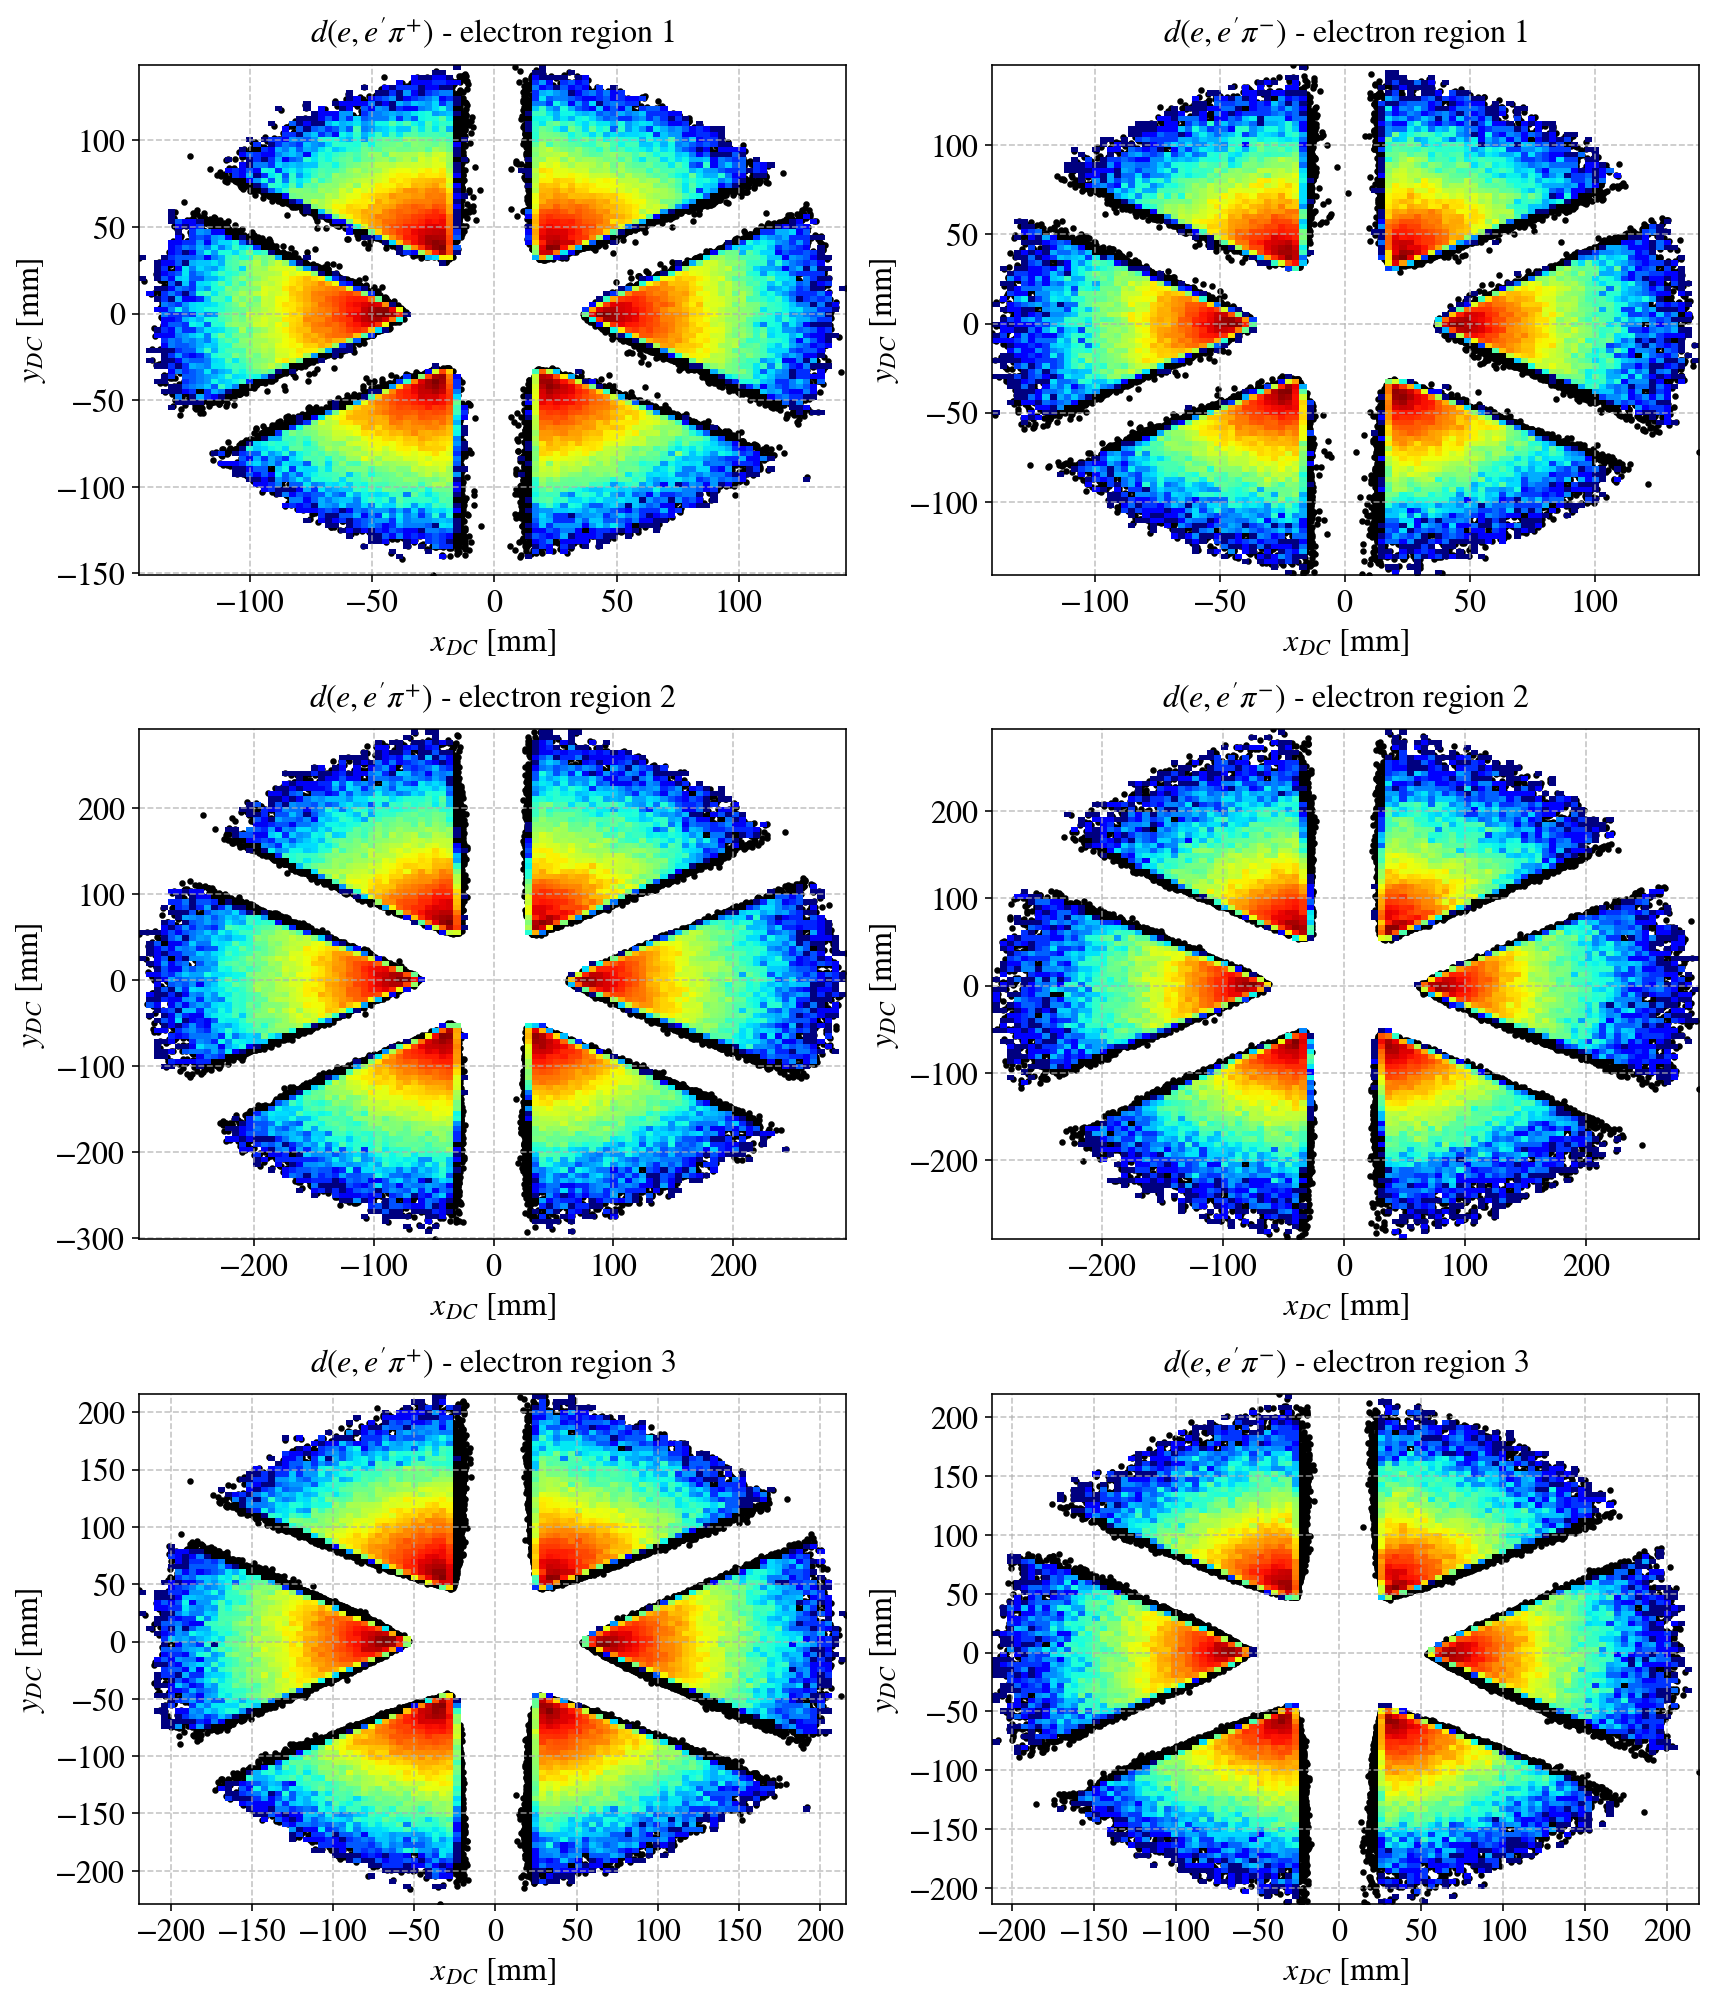

In [39]:
xlim = (-200,200)
fig = plt.figure(figsize=(12,14),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
        
    df_noFid = Events_previous_cuts[pi_ch]
    df_Fid   = Events[pi_ch+' '+cut_label]
    
    for l in range(3):
        ax = fig.add_subplot(3,2,2*l+pi_idx)

        x_noFid = np.array(df_noFid['e_DC_x_l%d'%l])
        y_noFid = np.array(df_noFid['e_DC_y_l%d'%l])
        plt.scatter( x_noFid, y_noFid, s=5 , color='k')

        x_Fid = np.array(df_Fid['e_DC_x_l%d'%l])
        y_Fid = np.array(df_Fid['e_DC_y_l%d'%l])
        plt.hist2d( x_Fid, y_Fid, bins=(np.linspace(np.min(x_noFid),np.max(x_noFid),100),np.linspace(np.min(y_noFid),np.max(y_noFid),100)),  norm=LogNorm(), cmap='jet' );

        set_axes(ax,'$x_{DC}$ [mm]','$y_{DC}$ [mm]',
                 title="$d(e,e'"+pi_label+")$ - electron region %d"%(l+1),
                 # xlim=xlim,
                 # ylim=xlim,
                 fontsize=16, do_add_grid=True)    
save_figure(filename = figures_path + 'e_Fiducial_cuts' + '.png')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/pi_Fiducial_cuts.png


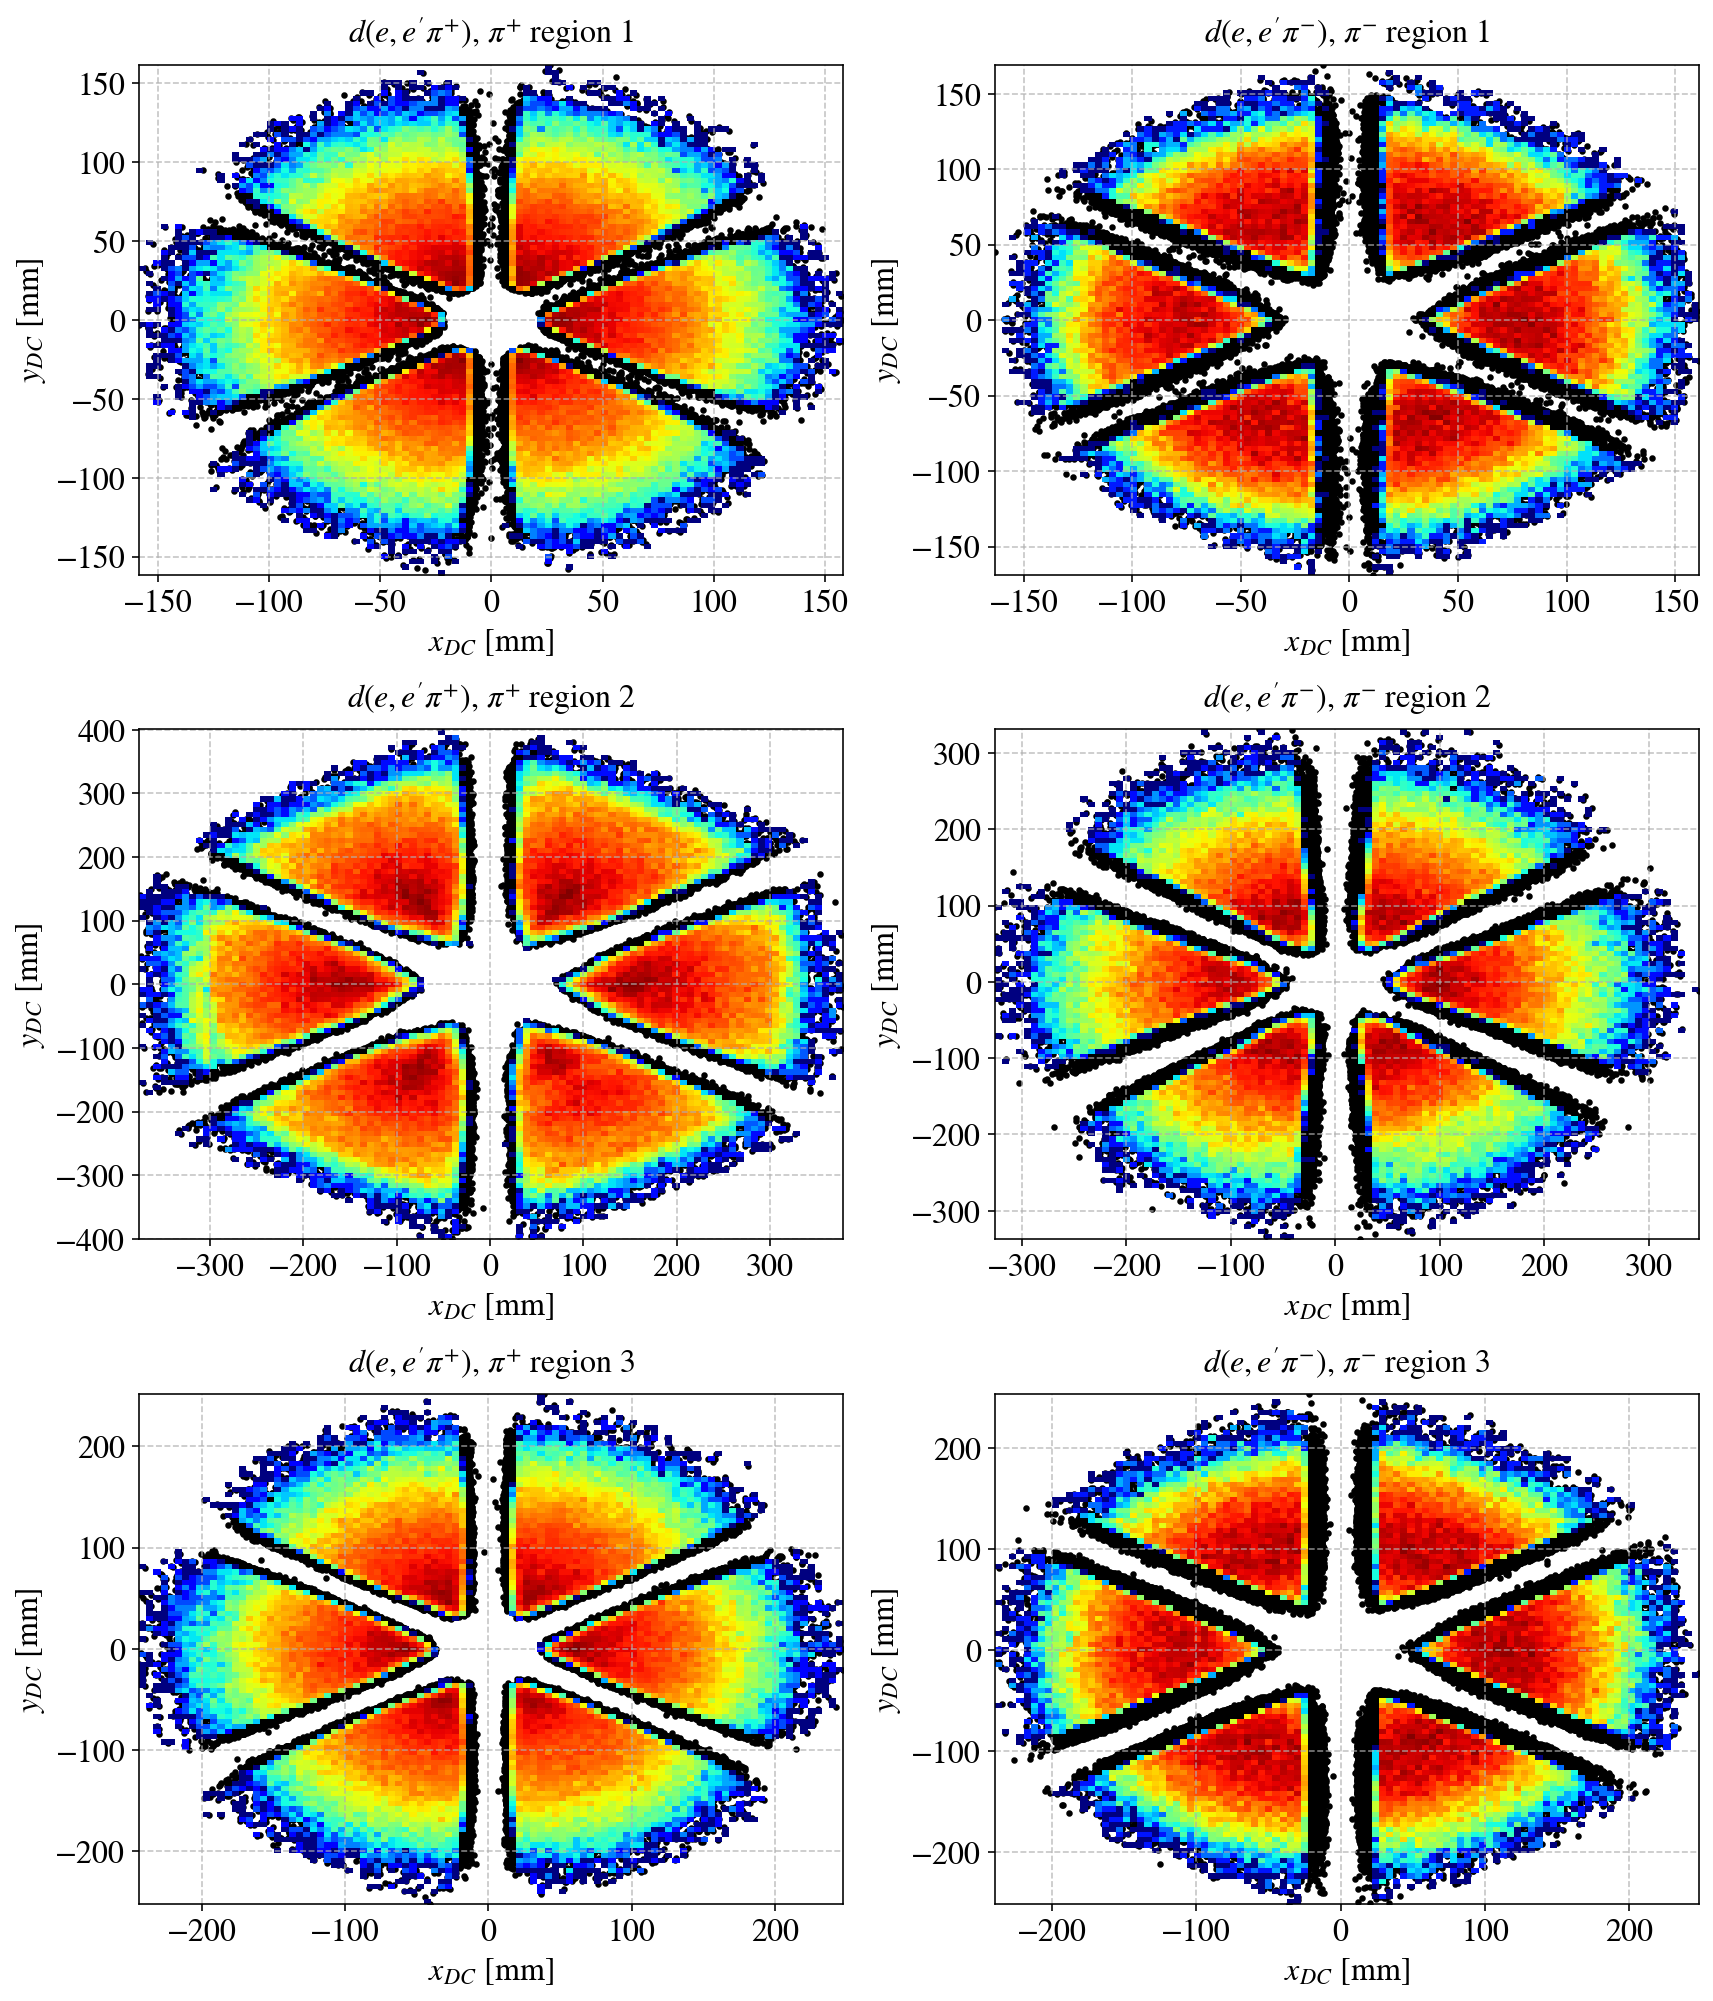

In [40]:
xlim = (-200,200)
fig = plt.figure(figsize=(12,14),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
        
    df_noFid = Events_previous_cuts[pi_ch]
    df_Fid   = Events[pi_ch+' '+cut_label]
    
    for l in range(3):
        ax = fig.add_subplot(3,2,2*l+pi_idx)

        x_noFid = np.array(df_noFid['pi_DC_x_l%d'%l])
        y_noFid = np.array(df_noFid['pi_DC_y_l%d'%l])
        plt.scatter( x_noFid, y_noFid, s=5 , color='k')

        x_Fid = np.array(df_Fid['pi_DC_x_l%d'%l])
        y_Fid = np.array(df_Fid['pi_DC_y_l%d'%l])
        plt.hist2d( x_Fid, y_Fid, bins=(np.linspace(np.min(x_noFid),np.max(x_noFid),100),np.linspace(np.min(y_noFid),np.max(y_noFid),100)),  norm=LogNorm(), cmap='jet' );

        set_axes(ax,'$x_{DC}$ [mm]','$y_{DC}$ [mm]',
                 title="$d(e,e'"+pi_label+")$, $"+pi_label+"$ region %d"%(l+1),
                 # xlim=xlim,
                 # ylim=xlim,
                 fontsize=16, do_add_grid=True)    
save_figure(filename = figures_path + 'pi_Fiducial_cuts' + '.png')

### Intermezzo: Plot $Q^2$ vs. $W$ and $Q^2$ vs. $\omega$ before kinematical cuts

In [41]:
previous_cut_label = 'DC fiducial cuts' 

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Q2_vs_omega_before_Kinematical_cuts.pdf


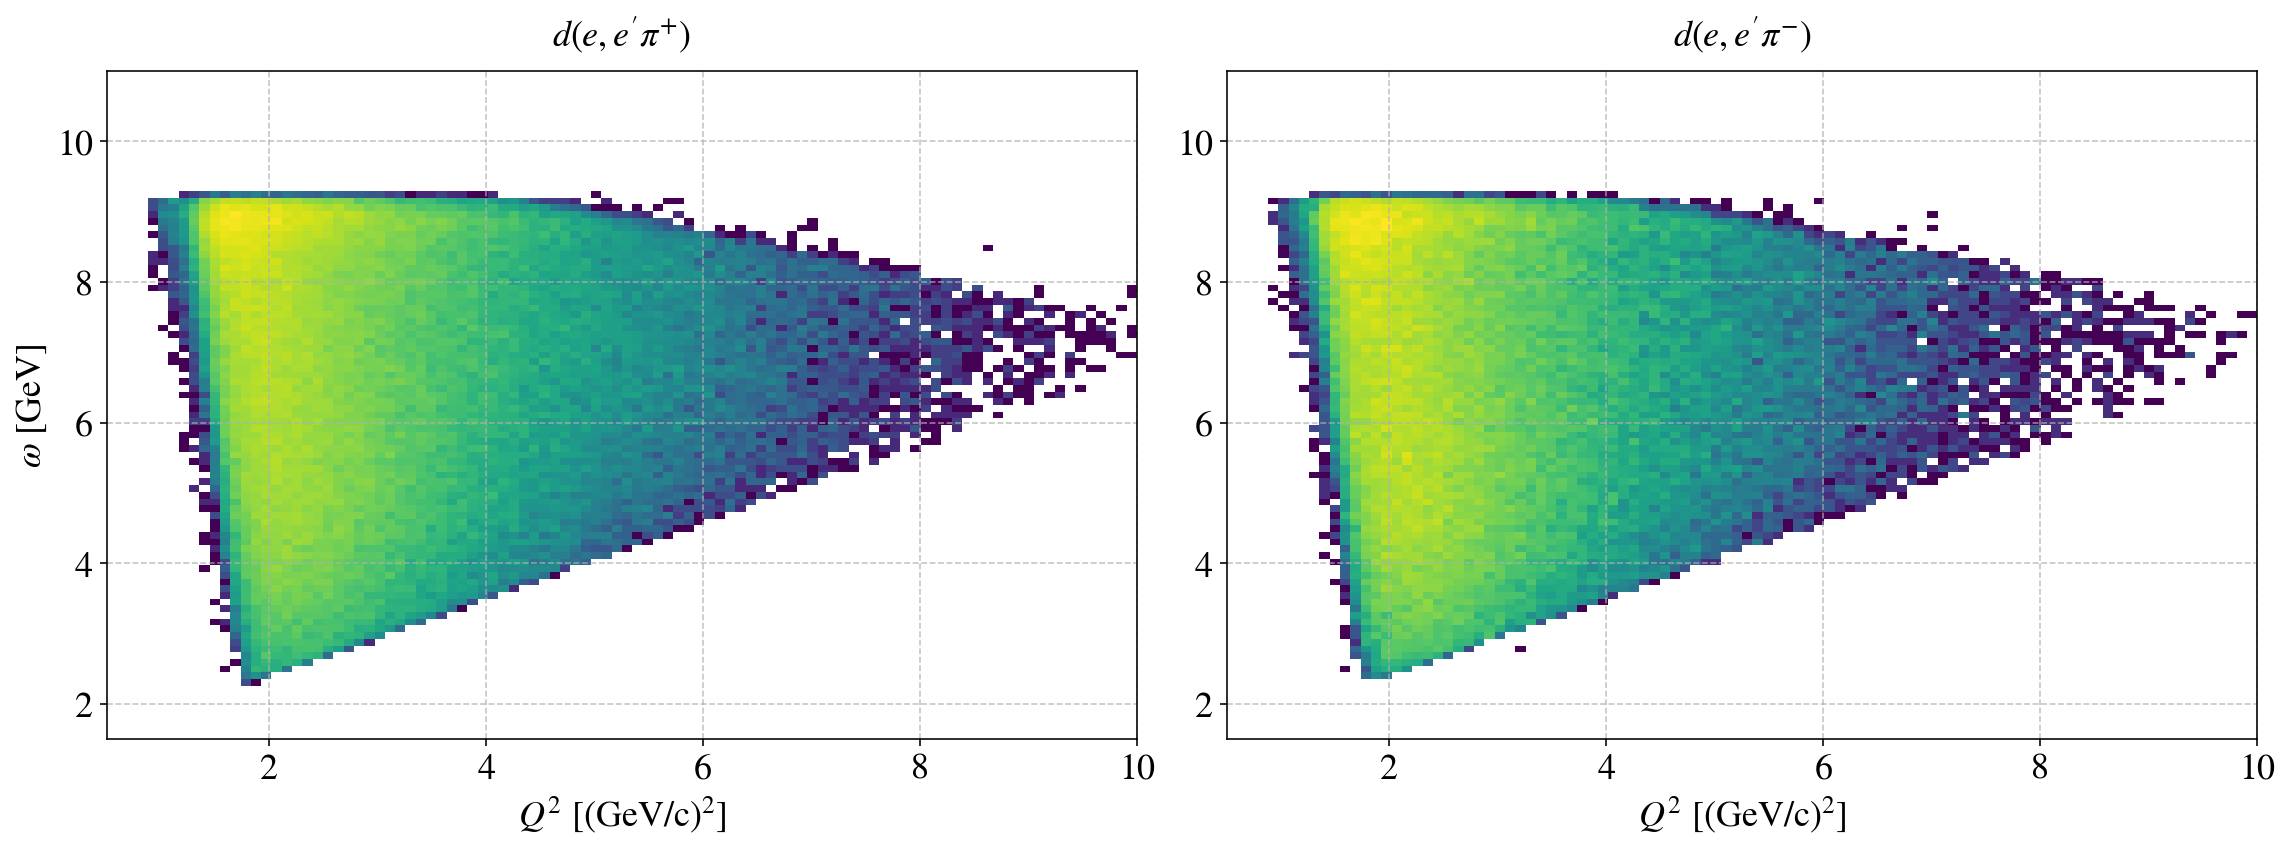

In [42]:
xmin,xmax,ymin,ymax,Nbins =  0.5,10,1.5,11,101
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].Q2
    y = Events_previous_cuts[pi_ch].omega
    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)),  norm=LogNorm() );
    set_axes(ax,'$Q^2$ [(GeV/c)$^2$]','$\omega$ [GeV]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, do_add_grid=True)
save_figure(filename = figures_path + 'Q2_vs_omega_before_Kinematical_cuts' + '.pdf')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Q2_vs_W_before_Kinematical_cuts.pdf


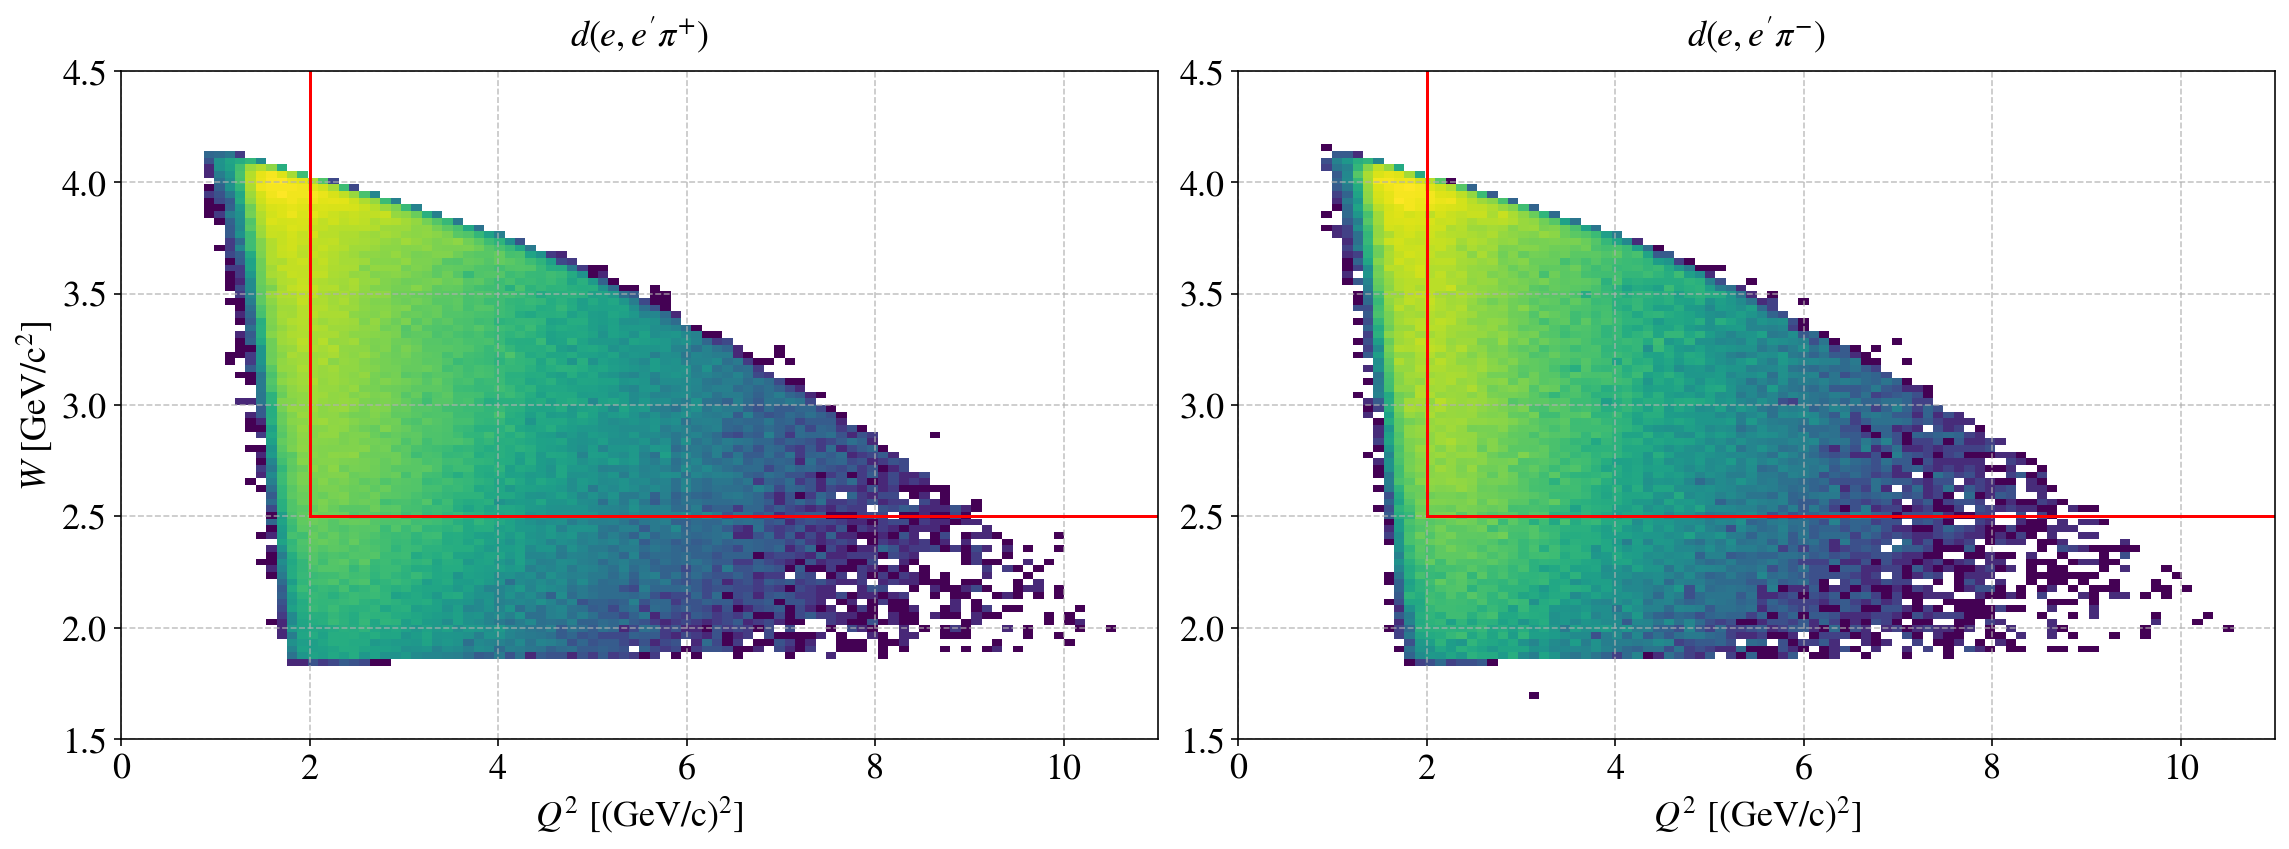

In [43]:
xmin,xmax,ymin,ymax,Nbins =  0.,11,1.5,4.5,101
fig = plt.figure(figsize=(16,6),tight_layout=True)

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].Q2
    y = Events_previous_cuts[pi_ch].W
    plt.hist2d( x, y, bins=(np.linspace(xmin,xmax,Nbins),np.linspace(ymin,ymax,Nbins)),  norm=LogNorm() );
    plt.plot([2,xmax],[2.5,2.5],'-r',[2,2],[2.5,ymax],'-r')
    set_axes(ax,'$Q^2$ [(GeV/c)$^2$]','$W$ [GeV/c$^2$]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, do_add_grid=True)
save_figure(filename = figures_path + 'Q2_vs_W_before_Kinematical_cuts' + '.pdf')

### 2.9 $W > 2.5$ GeV/c$^2$  

In [44]:
previous_cut_label = 'DC fiducial cuts' 
Events_previous_cuts = dict()

cut_idx = 9
Wmin = float(cuts[cuts.parameter=='W_min'].value)
cut_label = '$W > %.1f$ GeV/c$^2$'%Wmin

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (Wmin < Events_previous_cuts[pi_ch].W)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                   No cut     1000000     1000000   
1                         PCAL 19<V & 19<W      569181      559388   
2                       70 MeV < PCAL Edep      568644      558978   
3       $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4  $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                   $-13.0< v^e_z < +12.0$      517404      510703   
6          $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                    Cut on $\chi^2_{PID}$      304425      213501   
8                         DC fiducial cuts      235817      147488   
9                      $W > 2.5$ GeV/c$^2$      205215      125430   

   $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0            100.0                 1.4e-01            100.0   
1             56.9                 9.5e-02             55.9   
2             56.9                 9.4e-02             55.9   
3             55.9                 9.3e-02             55.1   
4             52.1                 8.9e-02             51.4   
5             51.7                 8.9e-02             51.1   
6             48.8                 8.5e-02             49.1   
7             30.4                 6.3e-02             21.4   
8             23.6                 5.4e-02             14.7   
9             20.5                 5.0e-02             12.5   

   $\Delta f_{\pi^-}$ [%]  
0                 1.4e-01  
1                 9.3e-02  
2                 9.3e-02  
3                 9.2e-02  
4                 8.8e-02  
5                 8.8e-02  
6                 8.6e-02  
7                 5.1e-02  
8                 4.1e-02  
9                 3.8e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/W.pdf


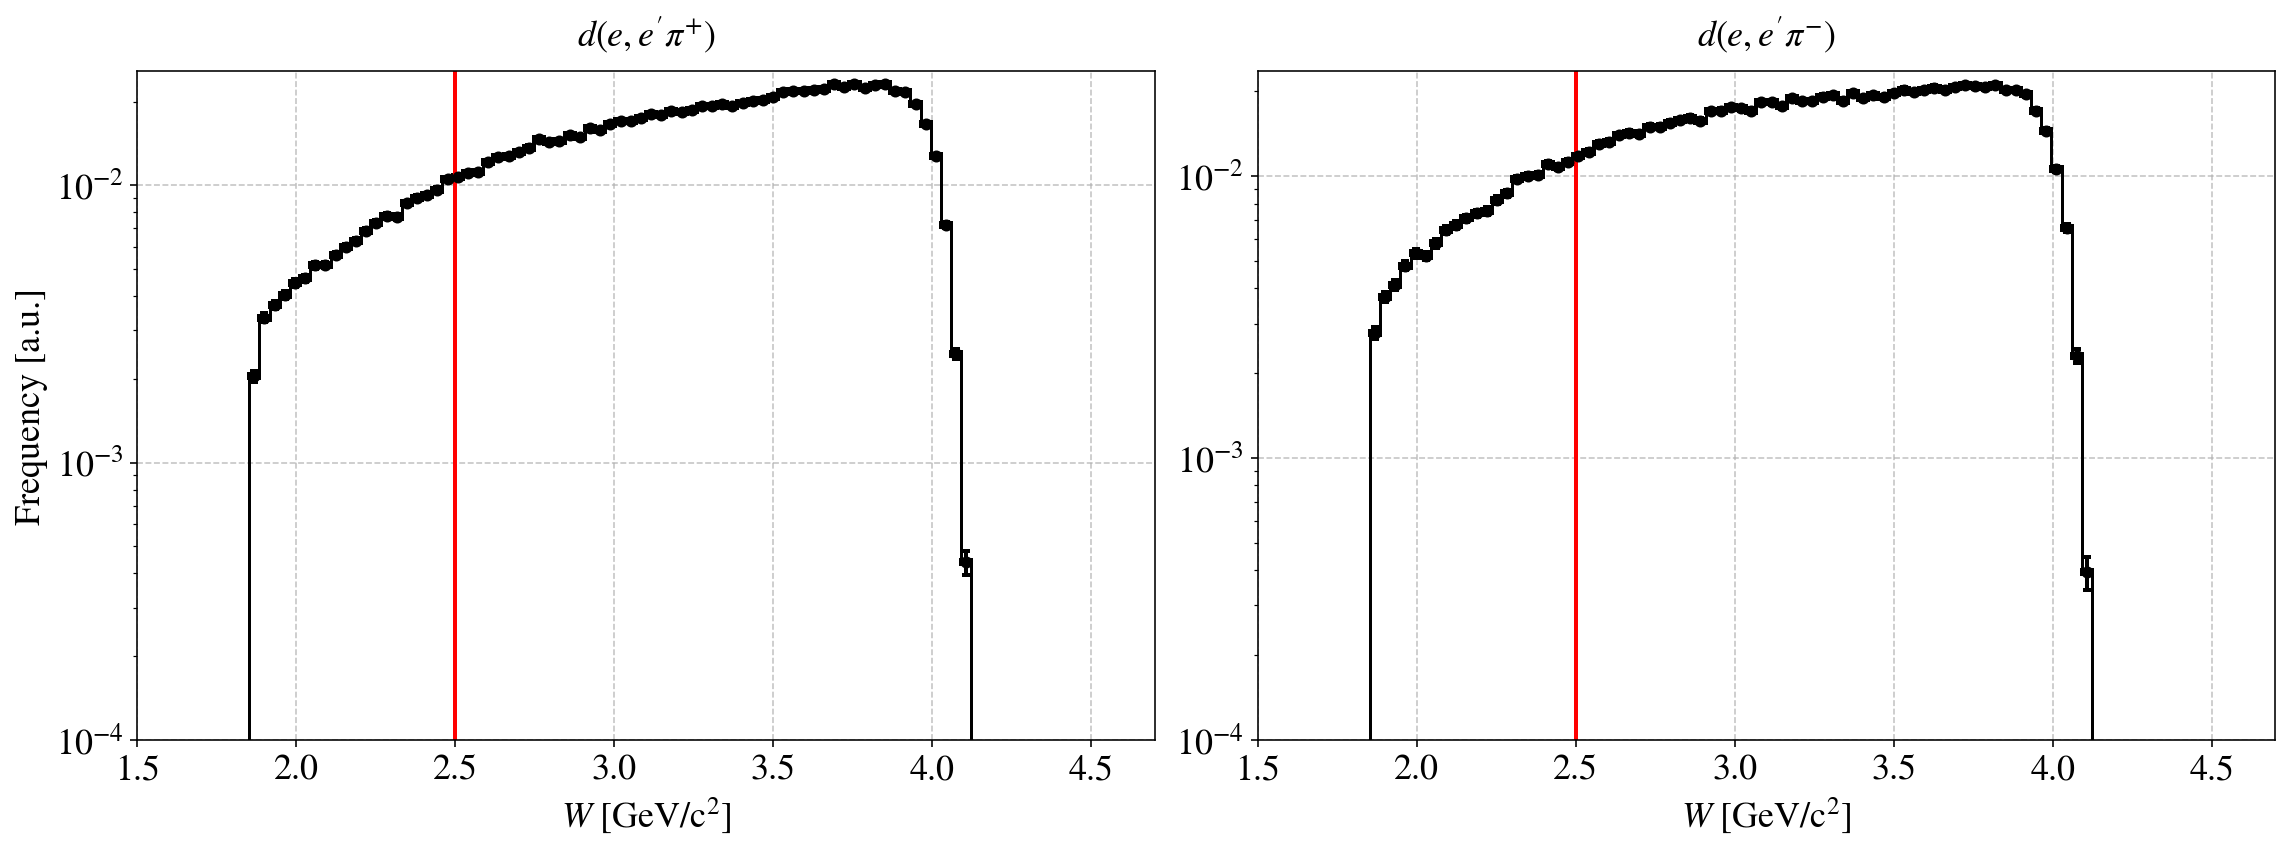

In [45]:
xmin,xmax,Nbins = 1.5,4.7,101
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].W
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$W$ [GeV/c$^2$]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([Wmin,Wmin],[1e-7,ymax],'-r',linewidth=2);
save_figure(filename = figures_path + 'W' + '.pdf')

### 2.10 $Q^2 > 2$ (GeV/c)$^2$  

In [46]:
previous_cut_label = '$W > %.1f$ GeV/c$^2$'%Wmin
Events_previous_cuts = dict()

cut_idx = 10
Q2_min = float(cuts[cuts.parameter=='Q2_min'].value)
cut_label = '$Q^2 > %.1f$ GeV/c$^2$'%Q2_min

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (Q2_min < Events_previous_cuts[pi_ch].Q2)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                    No cut     1000000     1000000   
1                          PCAL 19<V & 19<W      569181      559388   
2                        70 MeV < PCAL Edep      568644      558978   
3        $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4   $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                    $-13.0< v^e_z < +12.0$      517404      510703   
6           $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                     Cut on $\chi^2_{PID}$      304425      213501   
8                          DC fiducial cuts      235817      147488   
9                       $W > 2.5$ GeV/c$^2$      205215      125430   
10                    $Q^2 > 2.0$ GeV/c$^2$      149529       92699   

    $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0             100.0                 1.4e-01            100.0   
1              56.9                 9.5e-02             55.9   
2              56.9                 9.4e-02             55.9   
3              55.9                 9.3e-02             55.1   
4              52.1                 8.9e-02             51.4   
5              51.7                 8.9e-02             51.1   
6              48.8                 8.5e-02             49.1   
7              30.4                 6.3e-02             21.4   
8              23.6                 5.4e-02             14.7   
9              20.5                 5.0e-02             12.5   
10             15.0                 4.1e-02              9.3   

    $\Delta f_{\pi^-}$ [%]  
0                  1.4e-01  
1                  9.3e-02  
2                  9.3e-02  
3                  9.2e-02  
4                  8.8e-02  
5                  8.8e-02  
6                  8.6e-02  
7                  5.1e-02  
8                  4.1e-02  
9                  3.8e-02  
10                 3.2e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Q2.pdf


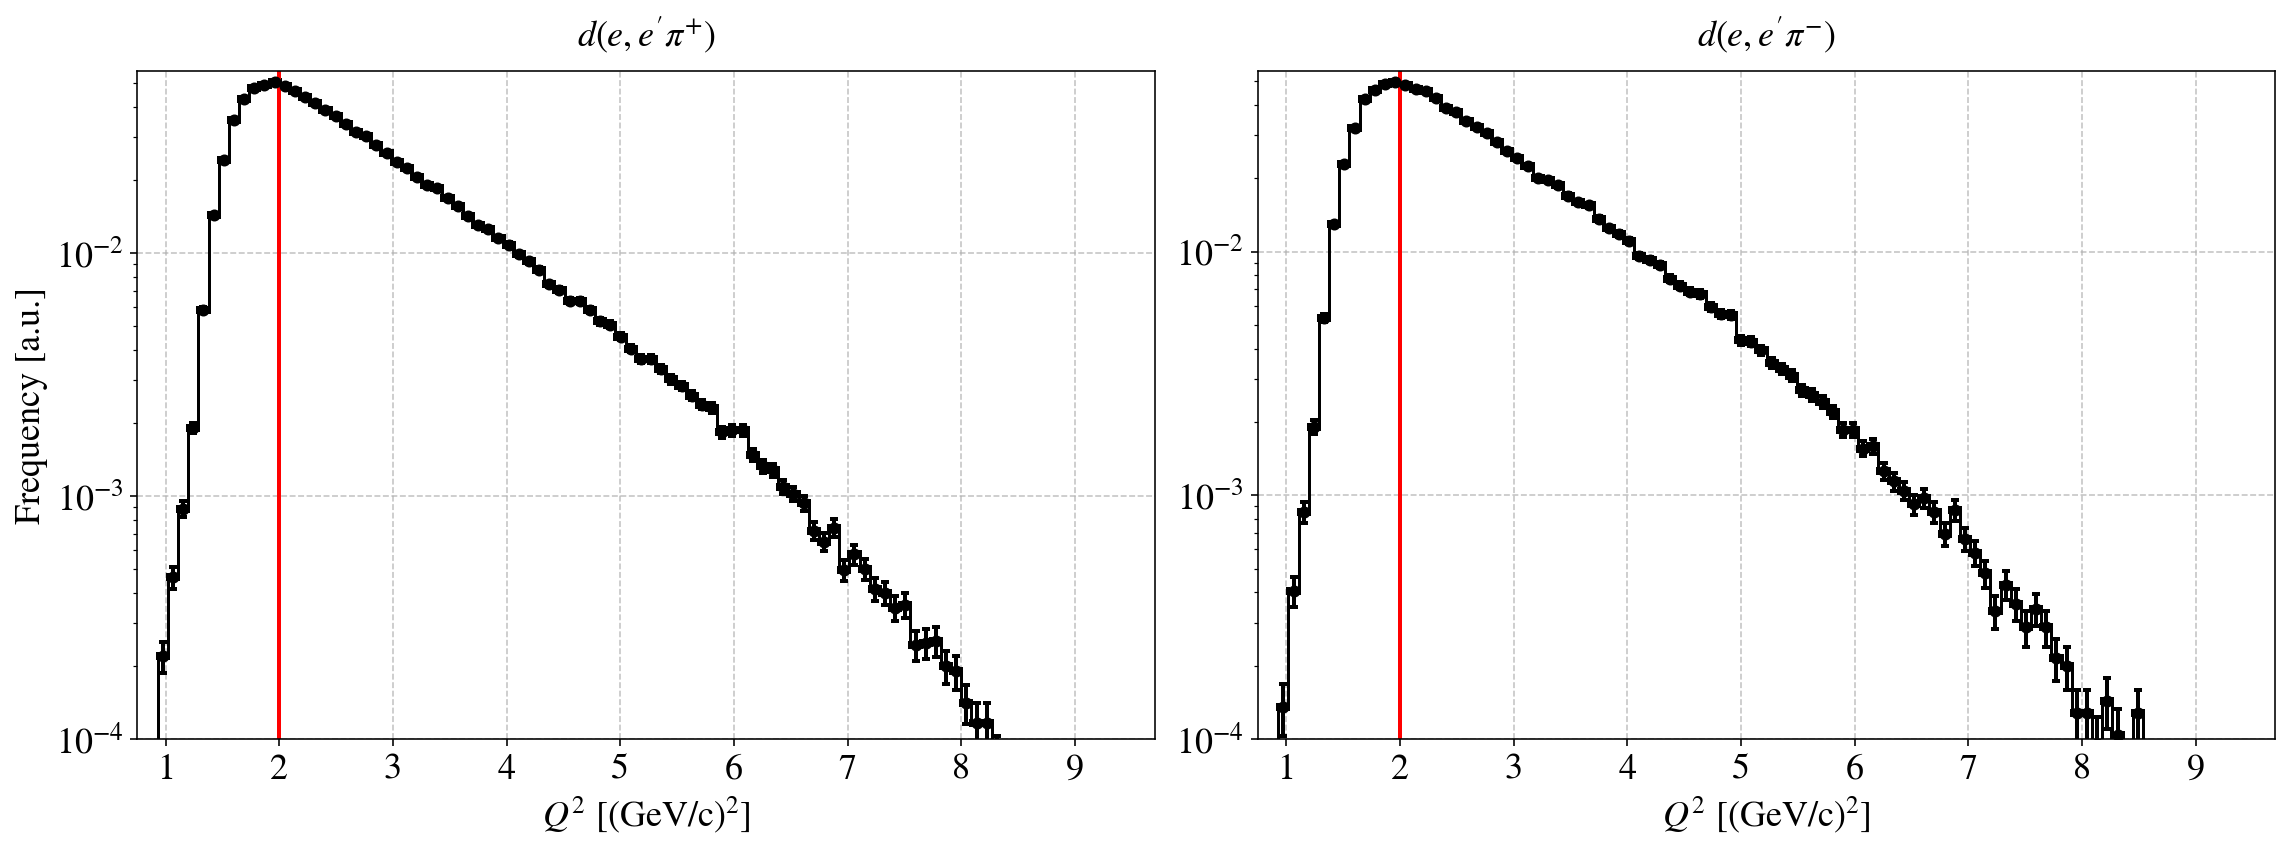

In [47]:
xmin,xmax,Nbins = 0.75,9.7,101

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].Q2
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$Q^2$ [(GeV/c)$^2$]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([Q2_min,Q2_min],[1e-7,ymax],'-r',linewidth=2);

save_figure(filename = figures_path + 'Q2' + '.pdf')

### 2.11 Suppress QE contribution $y < 0.75$  

In [48]:
previous_cut_label = '$Q^2 > %.1f$ GeV/c$^2$'%Q2_min
Events_previous_cuts = dict()

cut_idx = 11
y_max = float(cuts[cuts.parameter=='y_max'].value)
cut_label = '$y < %.2f$'%y_max

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (Events_previous_cuts[pi_ch].y < y_max)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                    No cut     1000000     1000000   
1                          PCAL 19<V & 19<W      569181      559388   
2                        70 MeV < PCAL Edep      568644      558978   
3        $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4   $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                    $-13.0< v^e_z < +12.0$      517404      510703   
6           $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                     Cut on $\chi^2_{PID}$      304425      213501   
8                          DC fiducial cuts      235817      147488   
9                       $W > 2.5$ GeV/c$^2$      205215      125430   
10                    $Q^2 > 2.0$ GeV/c$^2$      149529       92699   
11                               $y < 0.75$       93611       60756   

    $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0             100.0                 1.4e-01            100.0   
1              56.9                 9.5e-02             55.9   
2              56.9                 9.4e-02             55.9   
3              55.9                 9.3e-02             55.1   
4              52.1                 8.9e-02             51.4   
5              51.7                 8.9e-02             51.1   
6              48.8                 8.5e-02             49.1   
7              30.4                 6.3e-02             21.4   
8              23.6                 5.4e-02             14.7   
9              20.5                 5.0e-02             12.5   
10             15.0                 4.1e-02              9.3   
11              9.4                 3.2e-02              6.1   

    $\Delta f_{\pi^-}$ [%]  
0                  1.4e-01  
1                  9.3e-02  
2                  9.3e-02  
3                  9.2e-02  
4                  8.8e-02  
5                  8.8e-02  
6                  8.6e-02  
7                  5.1e-02  
8                  4.1e-02  
9                  3.8e-02  
10                 3.2e-02  
11                 2.5e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/y.pdf


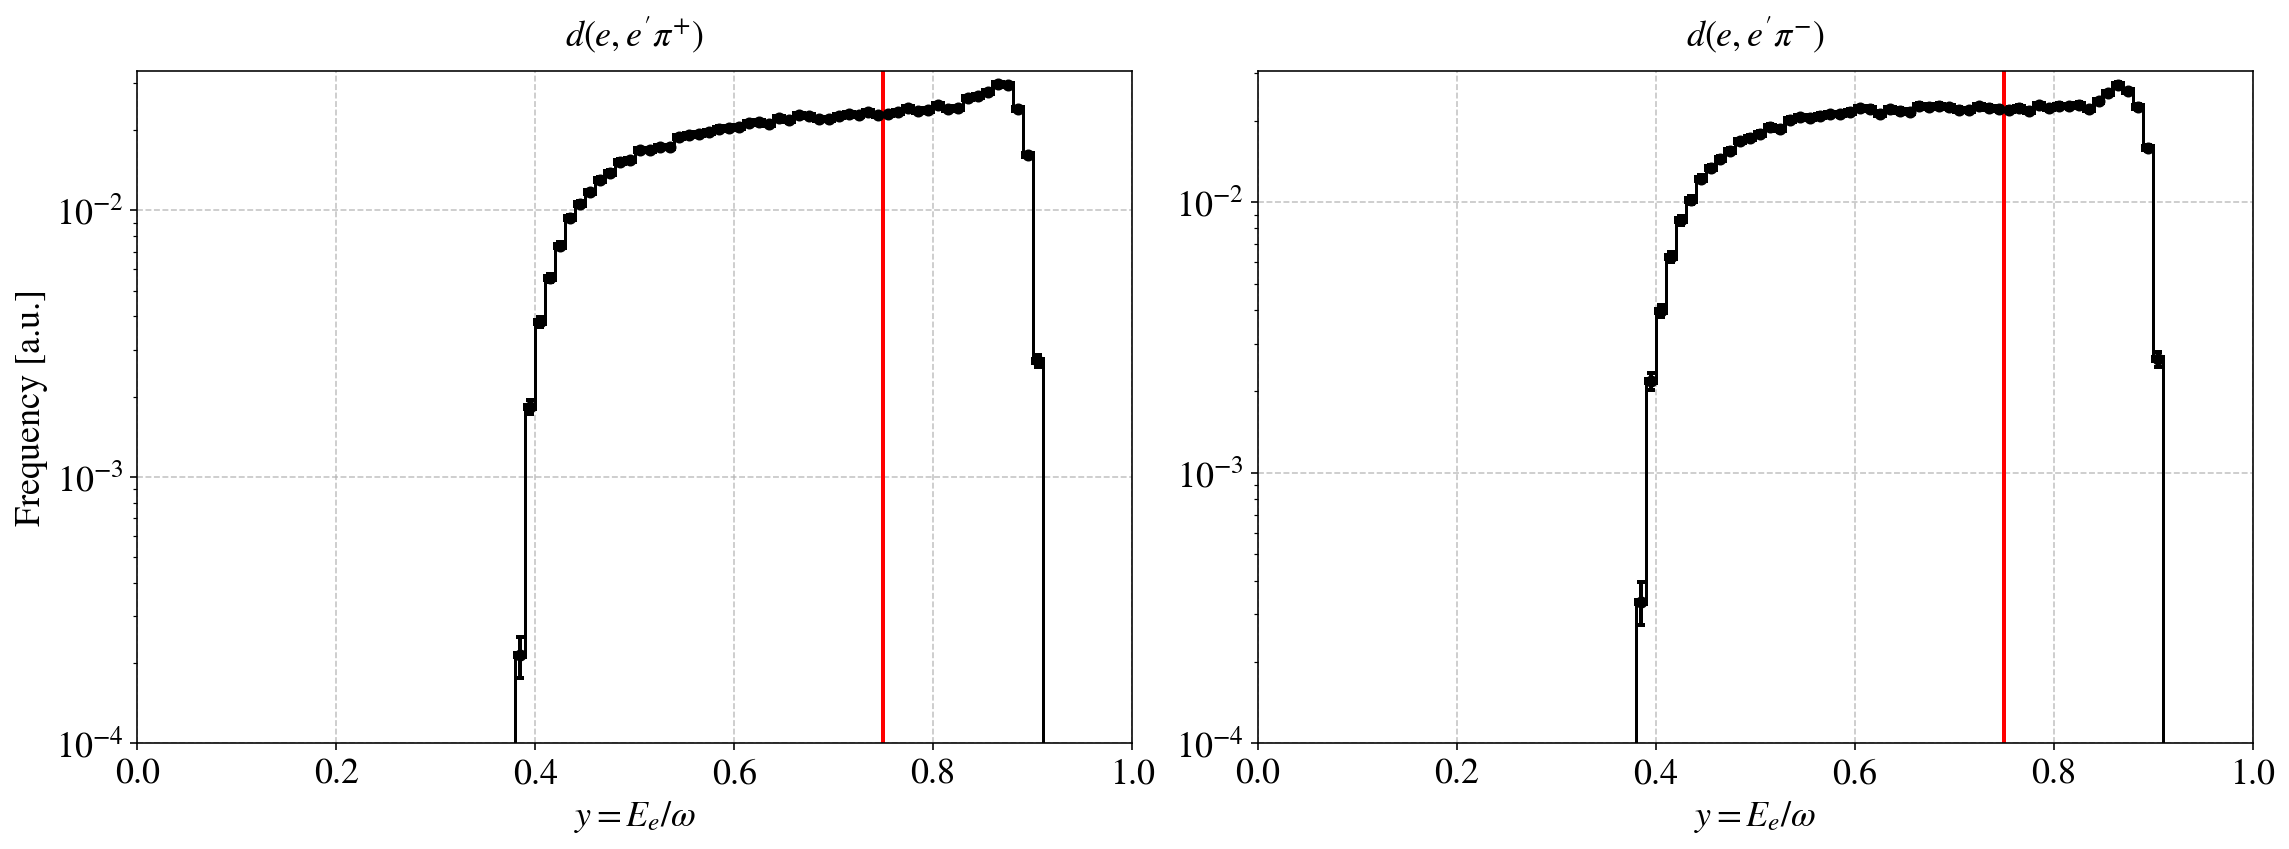

In [49]:
xmin,xmax,Nbins = 0.,1.,101

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].y
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$y = E_e/\omega$','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([y_max,y_max],[1e-7,ymax],'-r',linewidth=2);

save_figure(filename = figures_path + 'y' + '.pdf')

### 2.12 Reduce the contamination from exclusive processes $M_x > 1.7$ GeV/c$^2$

In [50]:
previous_cut_label = '$y < %.2f$'%y_max
Events_previous_cuts = dict()

cut_idx = 12
Mx_min = 1.7
cut_label = '$%.1f < M_x$'%Mx_min

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (Mx_min < Events_previous_cuts[pi_ch].Mx)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                    No cut     1000000     1000000   
1                          PCAL 19<V & 19<W      569181      559388   
2                        70 MeV < PCAL Edep      568644      558978   
3        $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4   $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                    $-13.0< v^e_z < +12.0$      517404      510703   
6           $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                     Cut on $\chi^2_{PID}$      304425      213501   
8                          DC fiducial cuts      235817      147488   
9                       $W > 2.5$ GeV/c$^2$      205215      125430   
10                    $Q^2 > 2.0$ GeV/c$^2$      149529       92699   
11                               $y < 0.75$       93611       60756   
12                              $1.7 < M_x$       87995       57521   

    $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0             100.0                 1.4e-01            100.0   
1              56.9                 9.5e-02             55.9   
2              56.9                 9.4e-02             55.9   
3              55.9                 9.3e-02             55.1   
4              52.1                 8.9e-02             51.4   
5              51.7                 8.9e-02             51.1   
6              48.8                 8.5e-02             49.1   
7              30.4                 6.3e-02             21.4   
8              23.6                 5.4e-02             14.7   
9              20.5                 5.0e-02             12.5   
10             15.0                 4.1e-02              9.3   
11              9.4                 3.2e-02              6.1   
12              8.8                 3.1e-02              5.8   

    $\Delta f_{\pi^-}$ [%]  
0                  1.4e-01  
1                  9.3e-02  
2                  9.3e-02  
3                  9.2e-02  
4                  8.8e-02  
5                  8.8e-02  
6                  8.6e-02  
7                  5.1e-02  
8                  4.1e-02  
9                  3.8e-02  
10                 3.2e-02  
11                 2.5e-02  
12                 2.5e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/M_x.pdf


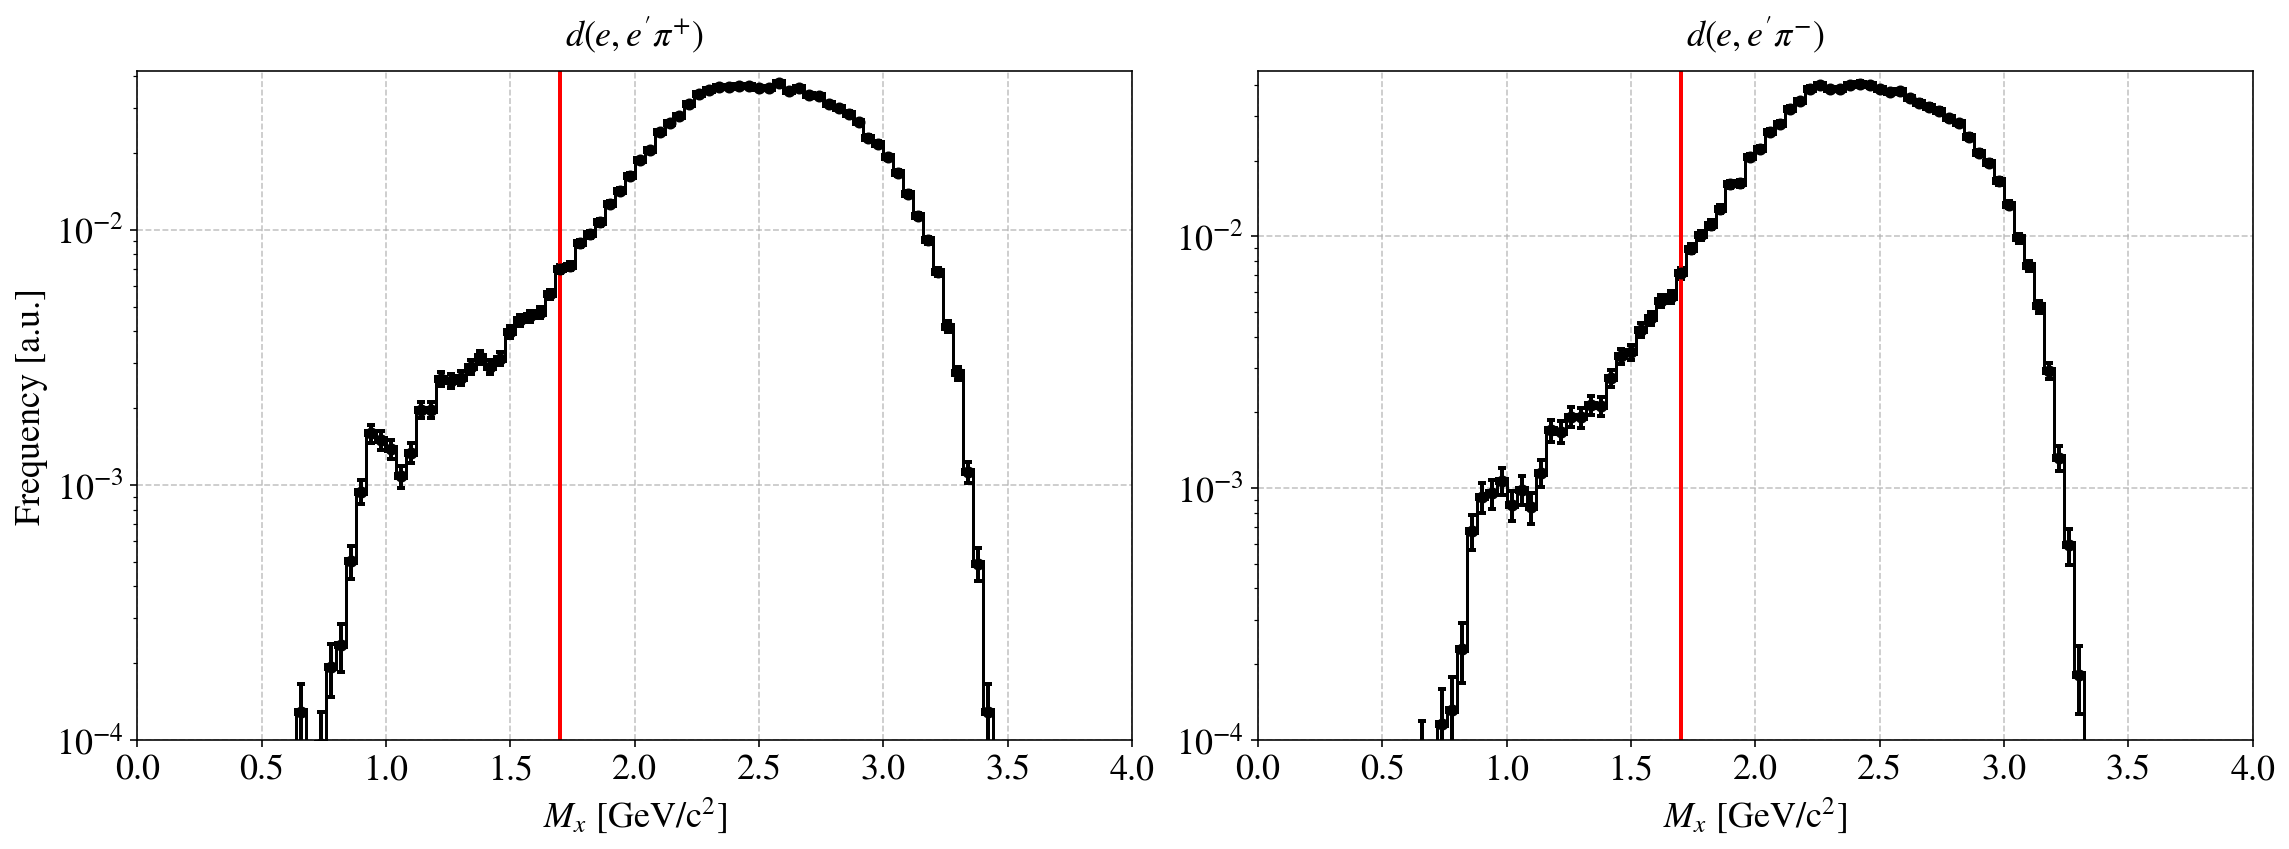

In [51]:
xmin,xmax,Nbins = 0.,4.,101

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].Mx
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$M_x$ [GeV/c$^2$]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([Mx_min,Mx_min],[1e-5,0.6],'-r',linewidth=2);

save_figure(filename = figures_path + 'M_x' + '.pdf')

### 2.13 Suppress Kaon contamination in the pion sample $1.25 < p_\pi < 5$ GeV/c  

In [52]:
previous_cut_label = '$%.1f < M_x$'%Mx_min
Events_previous_cuts = dict()

cut_idx = 13
Ppi_min, Ppi_max = 1.25,5
cut_label = '$%.2f < p_\pi < %.2f$'%(Ppi_min,Ppi_max)

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][ (Ppi_min < Events_previous_cuts[pi_ch].pi_P) & (Events_previous_cuts[pi_ch].pi_P < Ppi_max)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                    No cut     1000000     1000000   
1                          PCAL 19<V & 19<W      569181      559388   
2                        70 MeV < PCAL Edep      568644      558978   
3        $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4   $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                    $-13.0< v^e_z < +12.0$      517404      510703   
6           $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                     Cut on $\chi^2_{PID}$      304425      213501   
8                          DC fiducial cuts      235817      147488   
9                       $W > 2.5$ GeV/c$^2$      205215      125430   
10                    $Q^2 > 2.0$ GeV/c$^2$      149529       92699   
11                               $y < 0.75$       93611       60756   
12                              $1.7 < M_x$       87995       57521   
13                    $1.25 < p_\pi < 5.00$       47569       30748   

    $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0             100.0                 1.4e-01            100.0   
1              56.9                 9.5e-02             55.9   
2              56.9                 9.4e-02             55.9   
3              55.9                 9.3e-02             55.1   
4              52.1                 8.9e-02             51.4   
5              51.7                 8.9e-02             51.1   
6              48.8                 8.5e-02             49.1   
7              30.4                 6.3e-02             21.4   
8              23.6                 5.4e-02             14.7   
9              20.5                 5.0e-02             12.5   
10             15.0                 4.1e-02              9.3   
11              9.4                 3.2e-02              6.1   
12              8.8                 3.1e-02              5.8   
13              4.8                 2.2e-02              3.1   

    $\Delta f_{\pi^-}$ [%]  
0                  1.4e-01  
1                  9.3e-02  
2                  9.3e-02  
3                  9.2e-02  
4                  8.8e-02  
5                  8.8e-02  
6                  8.6e-02  
7                  5.1e-02  
8                  4.1e-02  
9                  3.8e-02  
10                 3.2e-02  
11                 2.5e-02  
12                 2.5e-02  
13                 1.8e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Ppi.pdf


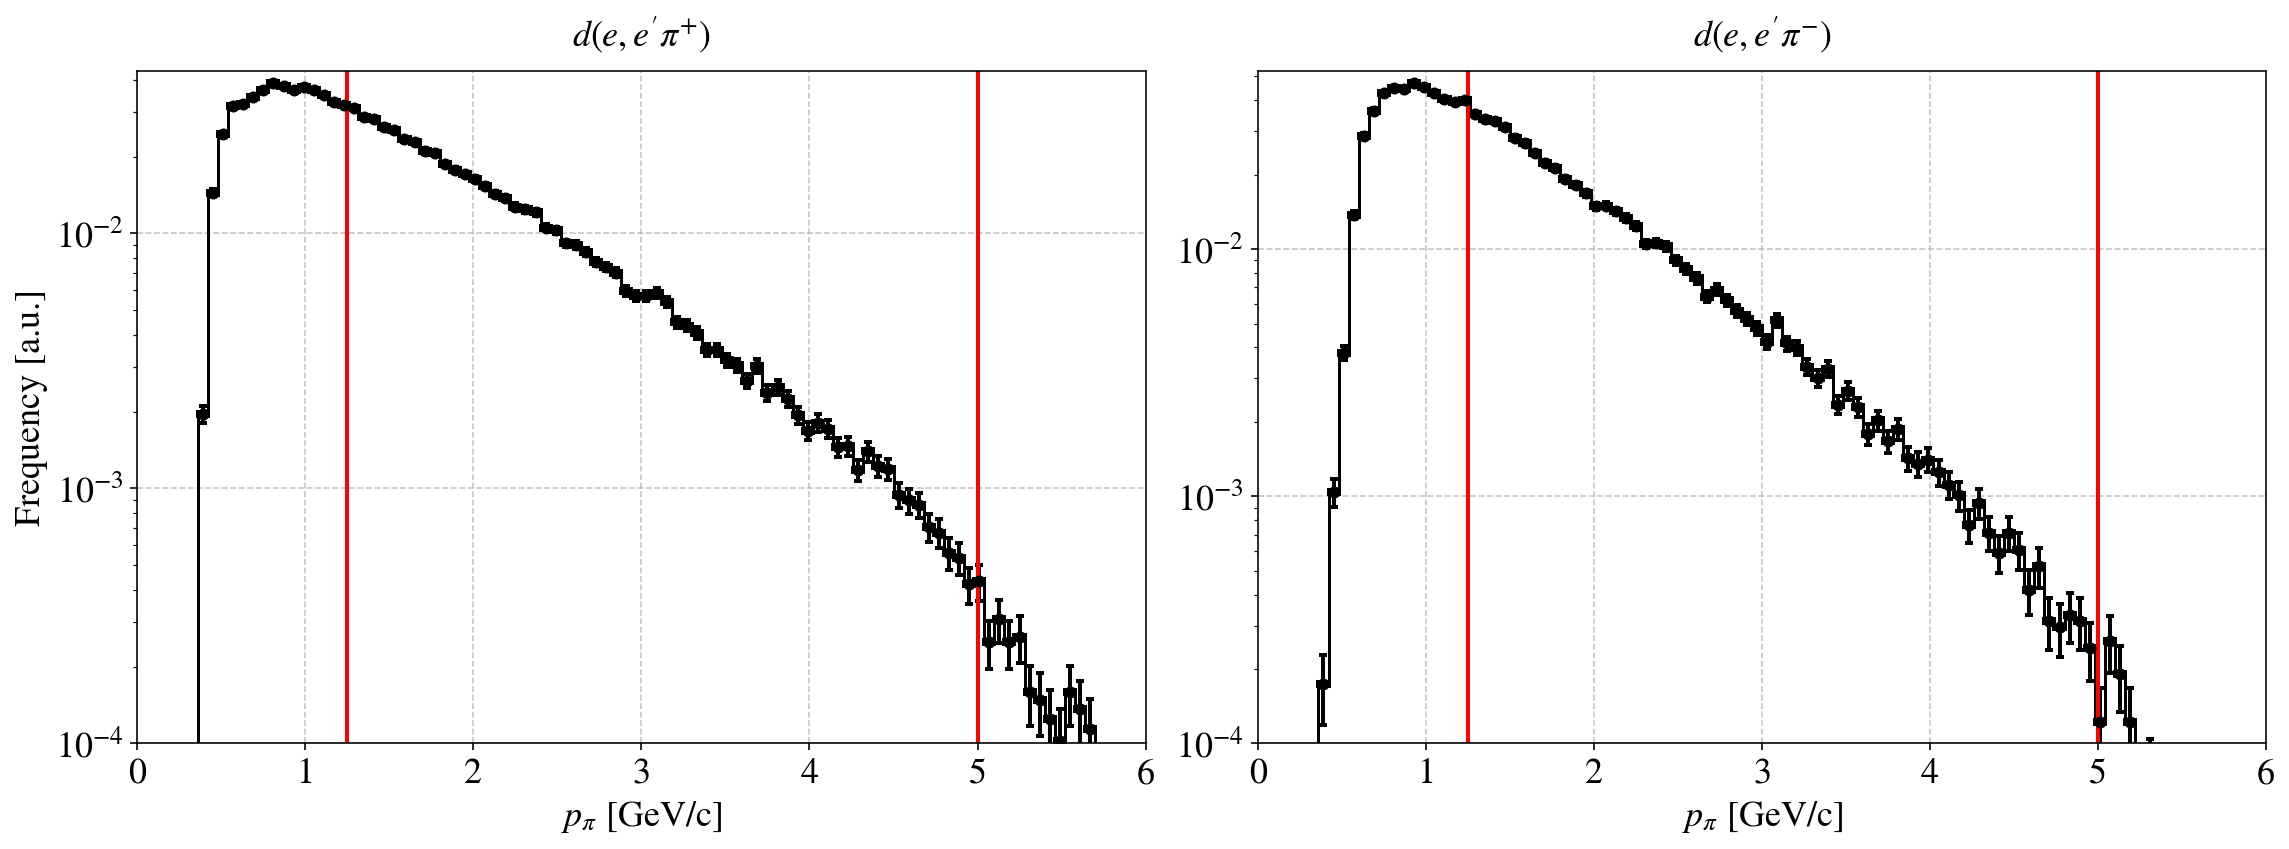

In [53]:
xmin,xmax,Nbins = 0.,6.,101

fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].pi_P
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$p_\pi$ [GeV/c]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([Ppi_min,Ppi_min],[1e-5,ymax],'-r',[Ppi_max,Ppi_max],[1e-5,ymax],'-r',linewidth=2);

save_figure(filename = figures_path + 'Ppi' + '.pdf')

### 2.14 Focus on high acceptance the HTCC $5^\circ < \theta_e < 35^\circ$ and $5^\circ < \theta_\pi < 35^\circ$  

In [54]:
previous_cut_label = '$%.2f < p_\pi < %.2f$'%(Ppi_min,Ppi_max)
Events_previous_cuts = dict()

cut_idx = 14
theta_min, theta_max = 5*3.14/180., 35*3.14/180.
cut_label = '$%.0f < \theta_e < %.0f, %.0f < \theta_\pi < %.0f$'%(theta_min*180./3.14, theta_max*180./3.14,theta_min*180./3.14, theta_max*180./3.14)

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][  (theta_min < Events_previous_cuts[pi_ch].e_Theta) 
                                                              & (Events_previous_cuts[pi_ch].e_Theta < theta_max)
                                                              & (theta_min < Events_previous_cuts[pi_ch].pi_Theta) 
                                                              & (Events_previous_cuts[pi_ch].pi_Theta < theta_max)]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                     No cut     1000000     1000000   
1                           PCAL 19<V & 19<W      569181      559388   
2                         70 MeV < PCAL Edep      568644      558978   
3         $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4    $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                     $-13.0< v^e_z < +12.0$      517404      510703   
6            $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                      Cut on $\chi^2_{PID}$      304425      213501   
8                           DC fiducial cuts      235817      147488   
9                        $W > 2.5$ GeV/c$^2$      205215      125430   
10                     $Q^2 > 2.0$ GeV/c$^2$      149529       92699   
11                                $y < 0.75$       93611       60756   
12                               $1.7 < M_x$       87995       57521   
13                     $1.25 < p_\pi < 5.00$       47569       30748   
14  $5 < \theta_e < 35, 5 < \theta_\pi < 35$       47140       30077   

    $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0             100.0                 1.4e-01            100.0   
1              56.9                 9.5e-02             55.9   
2              56.9                 9.4e-02             55.9   
3              55.9                 9.3e-02             55.1   
4              52.1                 8.9e-02             51.4   
5              51.7                 8.9e-02             51.1   
6              48.8                 8.5e-02             49.1   
7              30.4                 6.3e-02             21.4   
8              23.6                 5.4e-02             14.7   
9              20.5                 5.0e-02             12.5   
10             15.0                 4.1e-02              9.3   
11              9.4                 3.2e-02              6.1   
12              8.8                 3.1e-02              5.8   
13              4.8                 2.2e-02              3.1   
14              4.7                 2.2e-02              3.0   

    $\Delta f_{\pi^-}$ [%]  
0                  1.4e-01  
1                  9.3e-02  
2                  9.3e-02  
3                  9.2e-02  
4                  8.8e-02  
5                  8.8e-02  
6                  8.6e-02  
7                  5.1e-02  
8                  4.1e-02  
9                  3.8e-02  
10                 3.2e-02  
11                 2.5e-02  
12                 2.5e-02  
13                 1.8e-02  
14                 1.8e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/e_Theta.pdf


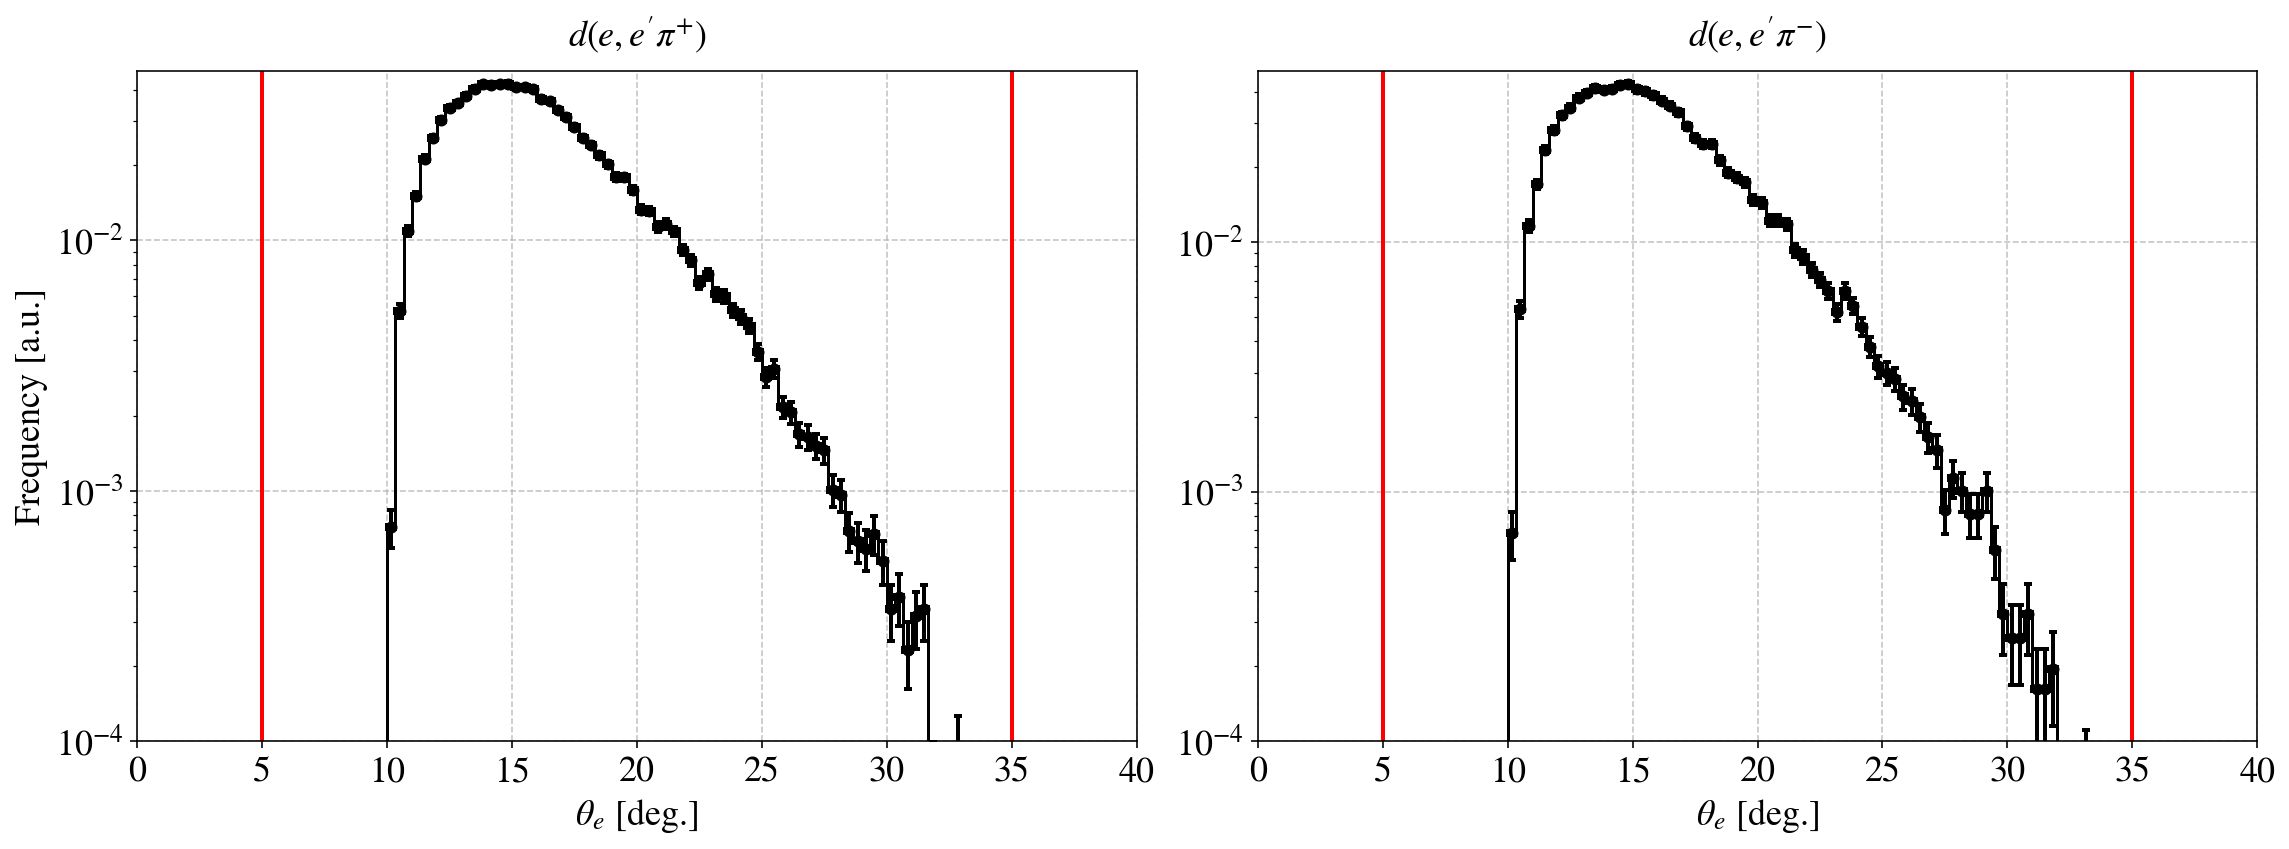

In [55]:
xmin,xmax,Nbins = 0,40.,121
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].e_Theta*180./3.14
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$\\theta_e$ [deg.]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([theta_min*180./3.14, theta_min*180./3.14],[1e-5,ymax],'-r',[theta_max*180./3.14, theta_max*180./3.14],[1e-5,ymax],'-r',linewidth=2);
save_figure(filename = figures_path + 'e_Theta' + '.pdf')

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/pi_Theta.pdf


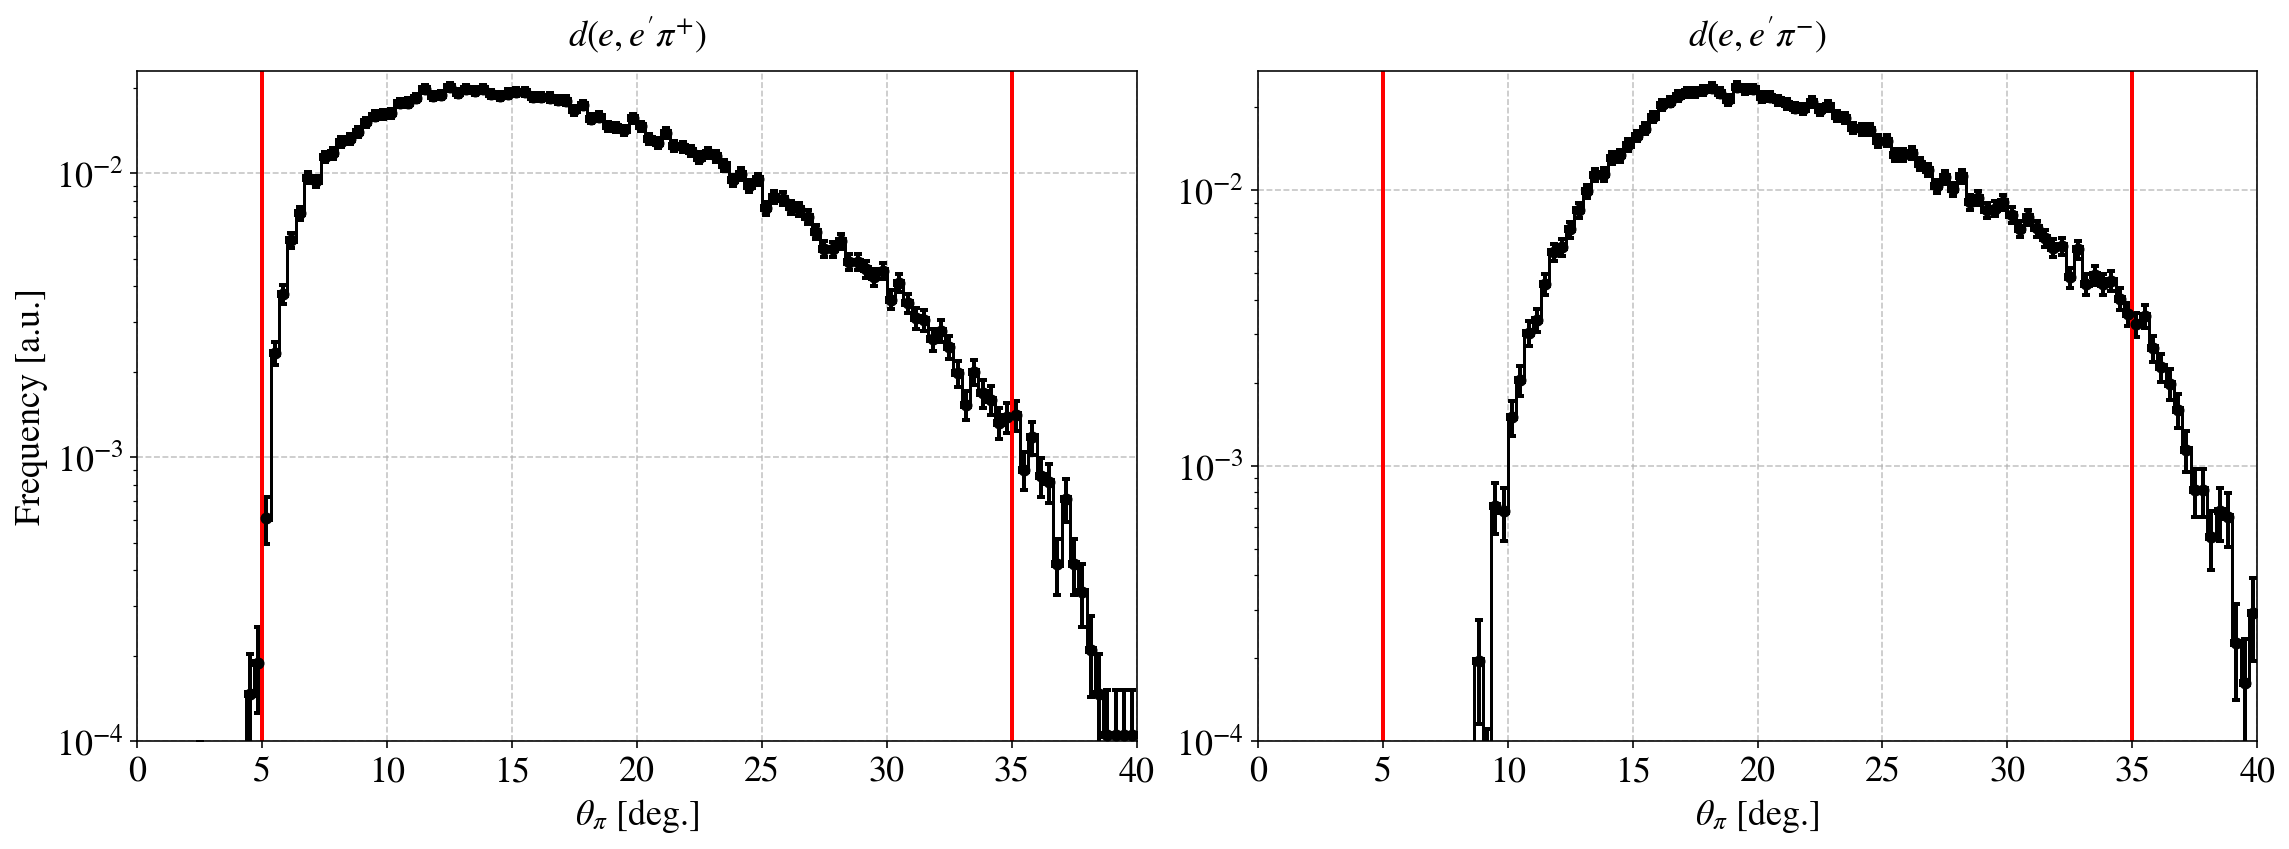

In [56]:
xmin,xmax,Nbins = 0,40.,121
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].pi_Theta*180./3.14
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$\\theta_\pi$ [deg.]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([theta_min*180./3.14, theta_min*180./3.14],[1e-5,ymax],'-r',[theta_max*180./3.14, theta_max*180./3.14],[1e-5,ymax],'-r',linewidth=2);
save_figure(filename = figures_path + 'pi_Theta' + '.pdf')

### 2.15 Leading outgoing pions $z_\pi>0.3$ 

In [57]:
previous_cut_label = '$%.0f < \theta_e < %.0f, %.0f < \theta_\pi < %.0f$'%(theta_min*180./3.14, theta_max*180./3.14,theta_min*180./3.14, theta_max*180./3.14)
Events_previous_cuts = dict()

cut_idx = 15
z_min = 0.3
cut_label = '$%.1f < z$'%z_min

for pi_ch in pi_charge_names:
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][  (z_min < Events_previous_cuts[pi_ch].Zpi) ]
    
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
                                               cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
                                              index=[cut_idx])])
Nevents

Cut $N_{\pi^+}$ $N_{\pi^-}$  \
0                                     No cut     1000000     1000000   
1                           PCAL 19<V & 19<W      569181      559388   
2                         70 MeV < PCAL Edep      568644      558978   
3         $(PCAL + ECIN + ECOUT)/p_e > 0.17$      558964      550865   
4    $\frac{ECIN}{p} > 0.2 - \frac{PCAL}{p}$      520966      514389   
5                     $-13.0< v^e_z < +12.0$      517404      510703   
6            $|v_z(e) - v_z(\pi)| < 20.0$ cm      487743      490555   
7                      Cut on $\chi^2_{PID}$      304425      213501   
8                           DC fiducial cuts      235817      147488   
9                        $W > 2.5$ GeV/c$^2$      205215      125430   
10                     $Q^2 > 2.0$ GeV/c$^2$      149529       92699   
11                                $y < 0.75$       93611       60756   
12                               $1.7 < M_x$       87995       57521   
13                     $1.25 < p_\pi < 5.00$       47569       30748   
14  $5 < \theta_e < 35, 5 < \theta_\pi < 35$       47140       30077   
15                                 $0.3 < z$       27018       15919   

    $f_{\pi^+}$ [%]  $\Delta f_{\pi^+}$ [%]  $f_{\pi^-}$ [%]  \
0             100.0                 1.4e-01            100.0   
1              56.9                 9.5e-02             55.9   
2              56.9                 9.4e-02             55.9   
3              55.9                 9.3e-02             55.1   
4              52.1                 8.9e-02             51.4   
5              51.7                 8.9e-02             51.1   
6              48.8                 8.5e-02             49.1   
7              30.4                 6.3e-02             21.4   
8              23.6                 5.4e-02             14.7   
9              20.5                 5.0e-02             12.5   
10             15.0                 4.1e-02              9.3   
11              9.4                 3.2e-02              6.1   
12              8.8                 3.1e-02              5.8   
13              4.8                 2.2e-02              3.1   
14              4.7                 2.2e-02              3.0   
15              2.7                 1.7e-02              1.6   

    $\Delta f_{\pi^-}$ [%]  
0                  1.4e-01  
1                  9.3e-02  
2                  9.3e-02  
3                  9.2e-02  
4                  8.8e-02  
5                  8.8e-02  
6                  8.6e-02  
7                  5.1e-02  
8                  4.1e-02  
9                  3.8e-02  
10                 3.2e-02  
11                 2.5e-02  
12                 2.5e-02  
13                 1.8e-02  
14                 1.8e-02  
15                 1.3e-02

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/Zpi.pdf


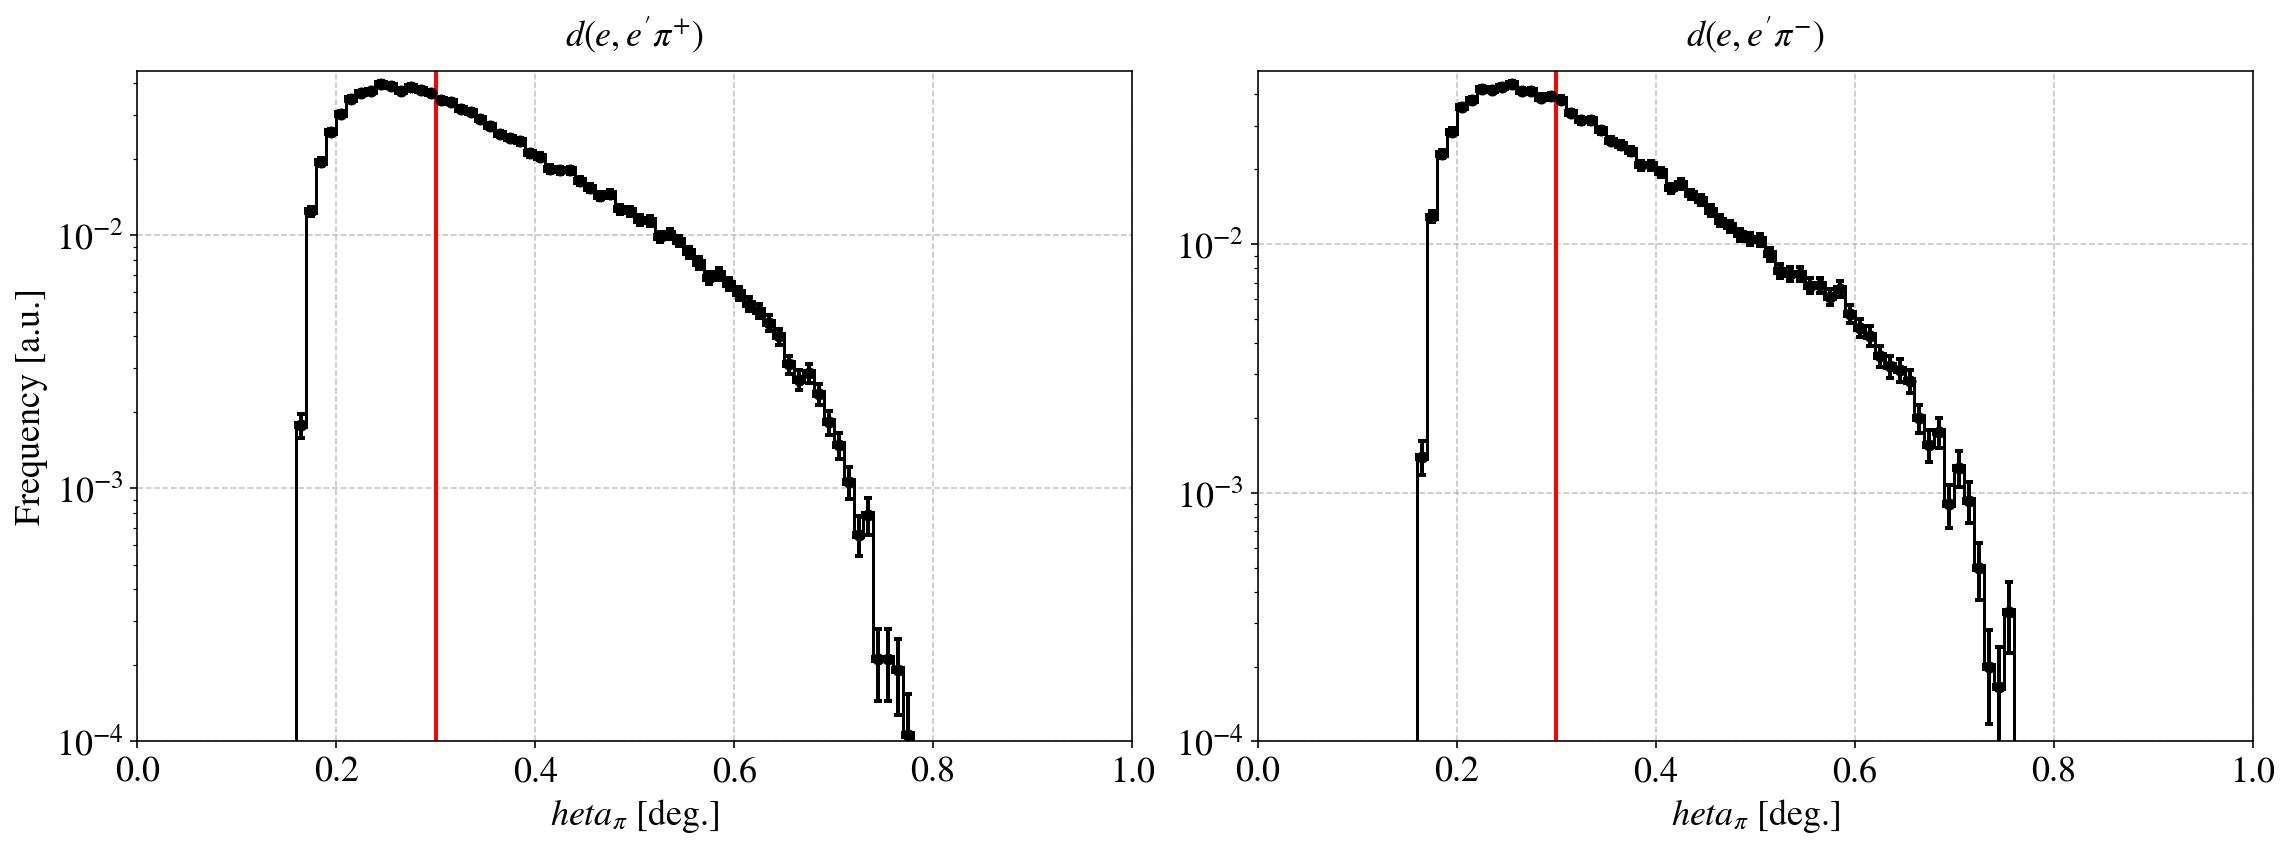

In [58]:
xmin,xmax,Nbins = 0,1.,101
fig = plt.figure(figsize=(16,6),tight_layout=True)
for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    ax = fig.add_subplot(1,2,pi_idx)
    x = Events_previous_cuts[pi_ch].Zpi
    x,h,x_err,h_err = plot_step_hist(x, bins=np.linspace(xmin,xmax,Nbins),density=True, color='k');
    ymax = 1.1*np.max(h + h_err)
    set_axes(ax,'$z_\pi$ [deg.]','Frequency [a.u.]' if pi_idx==1 else '',title="$d(e,e'"+pi_label+")$",fontsize=18, xlim=(xmin,xmax),ylim=(1e-4,ymax),do_add_grid=True)
    ax.set_yscale('log')
    plt.plot([z_min, z_min],[1e-5,ymax],'-r',linewidth=2);
save_figure(filename = figures_path + 'Zpi' + '.pdf')

### 2.16 $\pi^+$ and $\pi^-$ acceptance matching cut 

In [59]:
previous_cut_label = '$%.1f < z$'%z_min
Events_previous_cuts = dict()

cut_idx = 16
cut_label = '$\pi^\pm$ acceptance matching'

for pi_ch in pi_charge_names:
    # COMPLETE THIS!
    Events_previous_cuts[pi_ch] = Events[pi_ch+' '+previous_cut_label]
    # Events[pi_ch+' '+cut_label] = Events_previous_cuts[pi_ch][  (z_min < Events_previous_cuts[pi_ch].Zpi) ]
    
# Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus '+cut_label],Events['piminus '+cut_label], Npips_noCuts, Npims_noCuts)
# Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:cut_label,
#                                                cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},                                              
#                                               index=[cut_idx])])
# Nevents

In [60]:
phi_mid_arr = dict()
sectors     = [1,2,3,4,5,6]
phi_mid_arr = np.array([-1, 0, 60, 120, 180, -120, -60])
phi_min_arr = phi_mid_arr - 50
phi_max_arr = phi_mid_arr + 50

#### 2.16.1 Plot $\theta$ vs. $p$ for the pion

In [61]:
p_min_arr = [1.25, 2.00, 2.50, 3.50 ]
p_max_arr = [2.00, 2.50, 3.50, 5.00 ]
Np = len(p_min_arr)

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_p_sector_1.pdf
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_p_sector_2.pdf
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_p_sector_3.pdf
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_p_sector_4.pdf
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_p_sector_5.pdf
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_p_sector_6.pdf


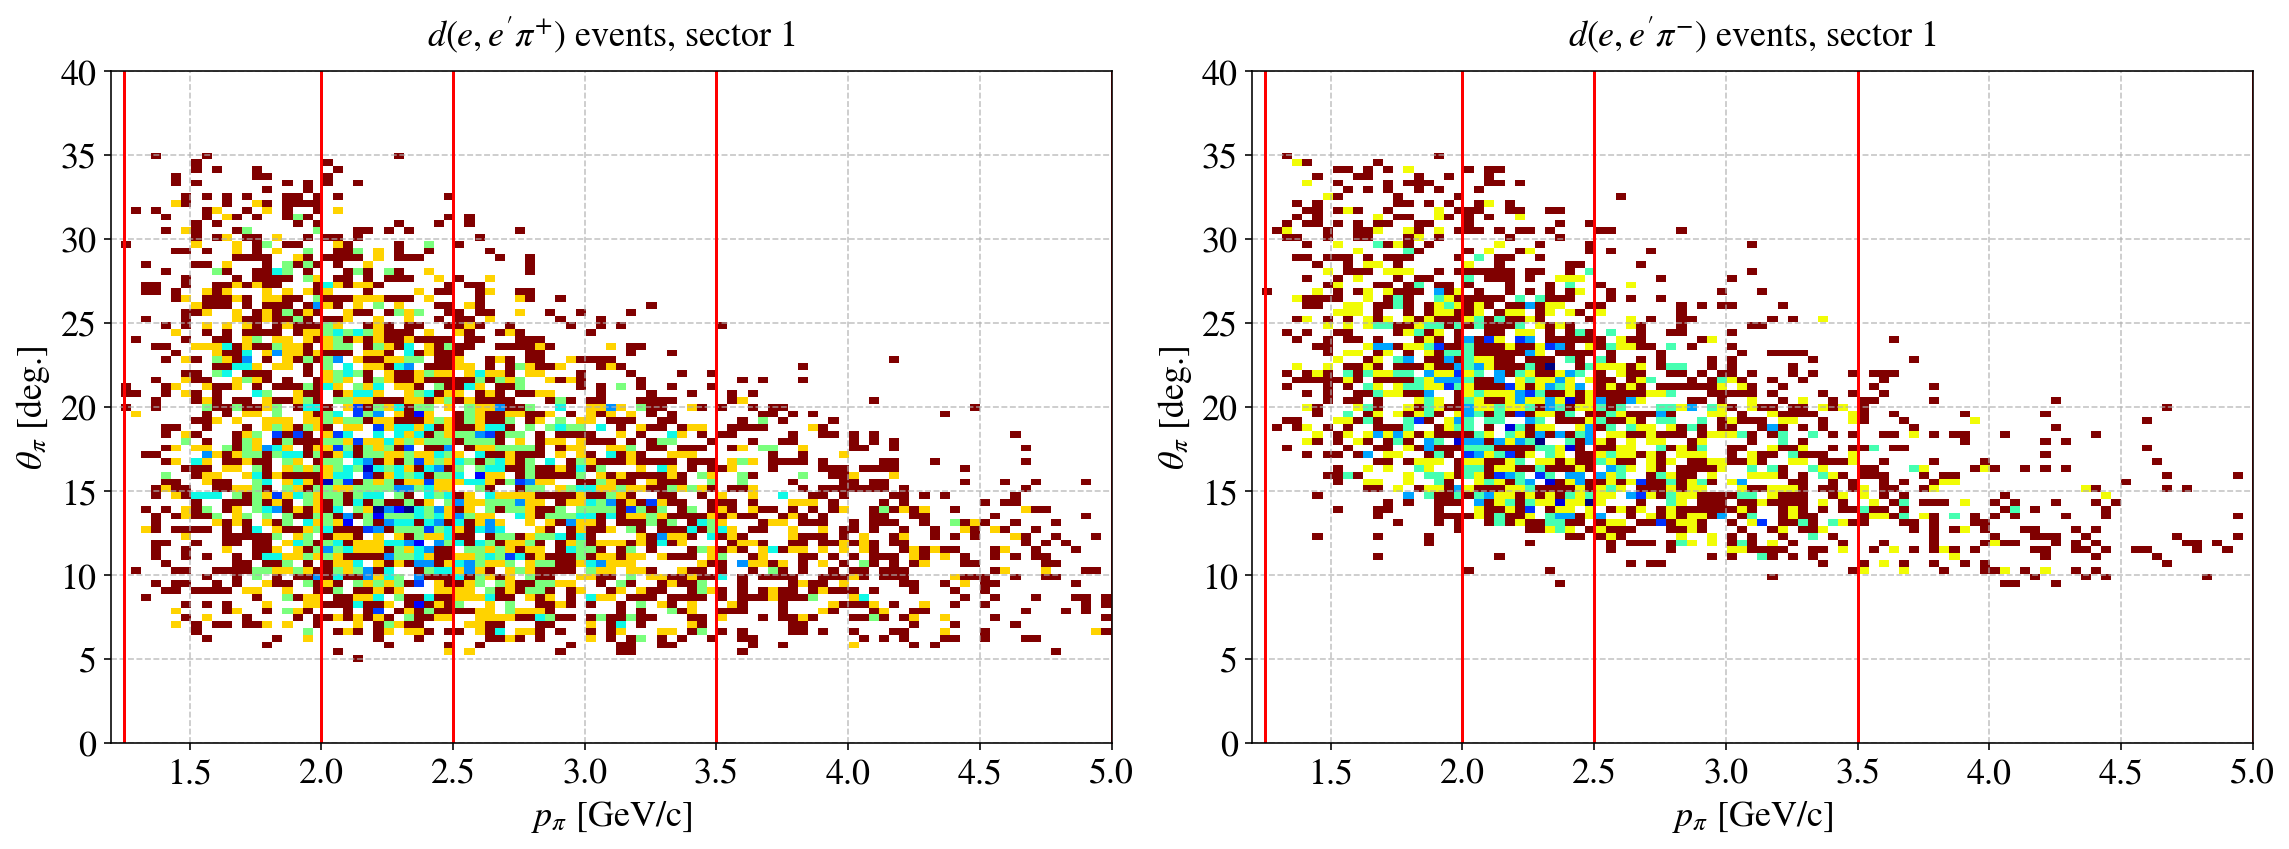

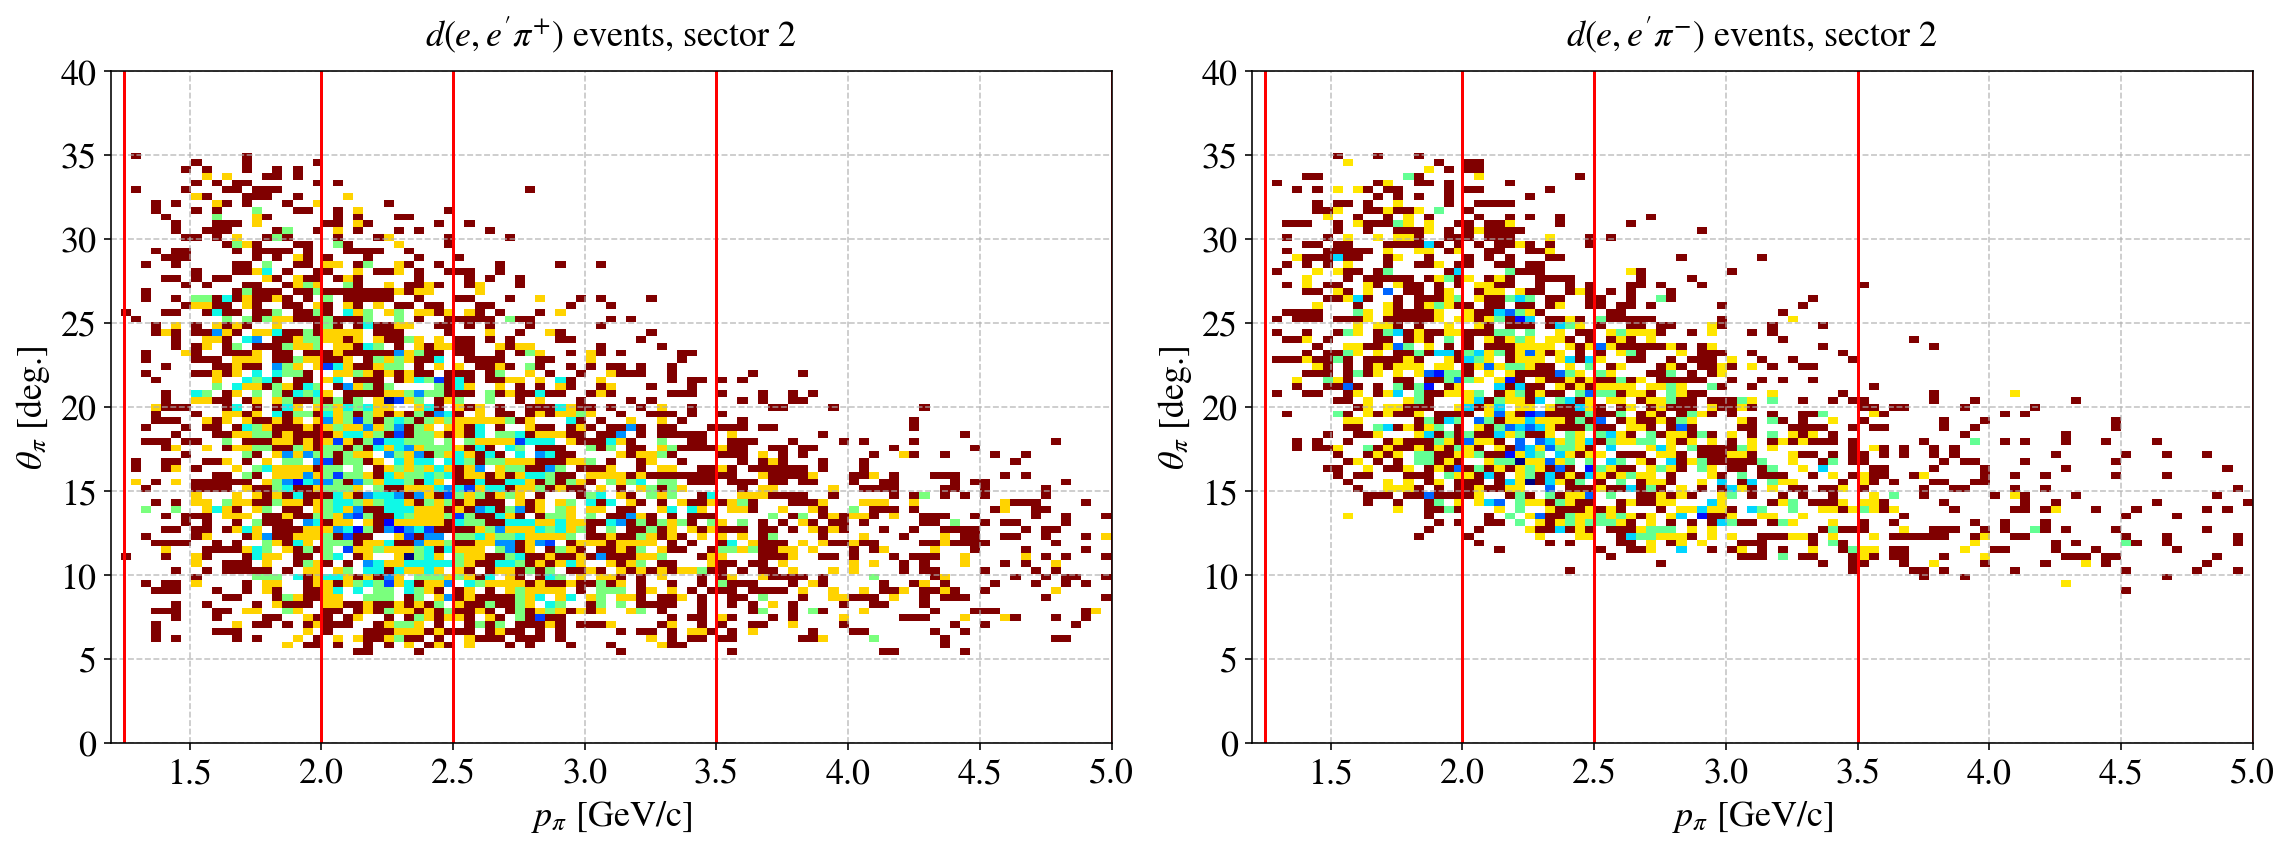

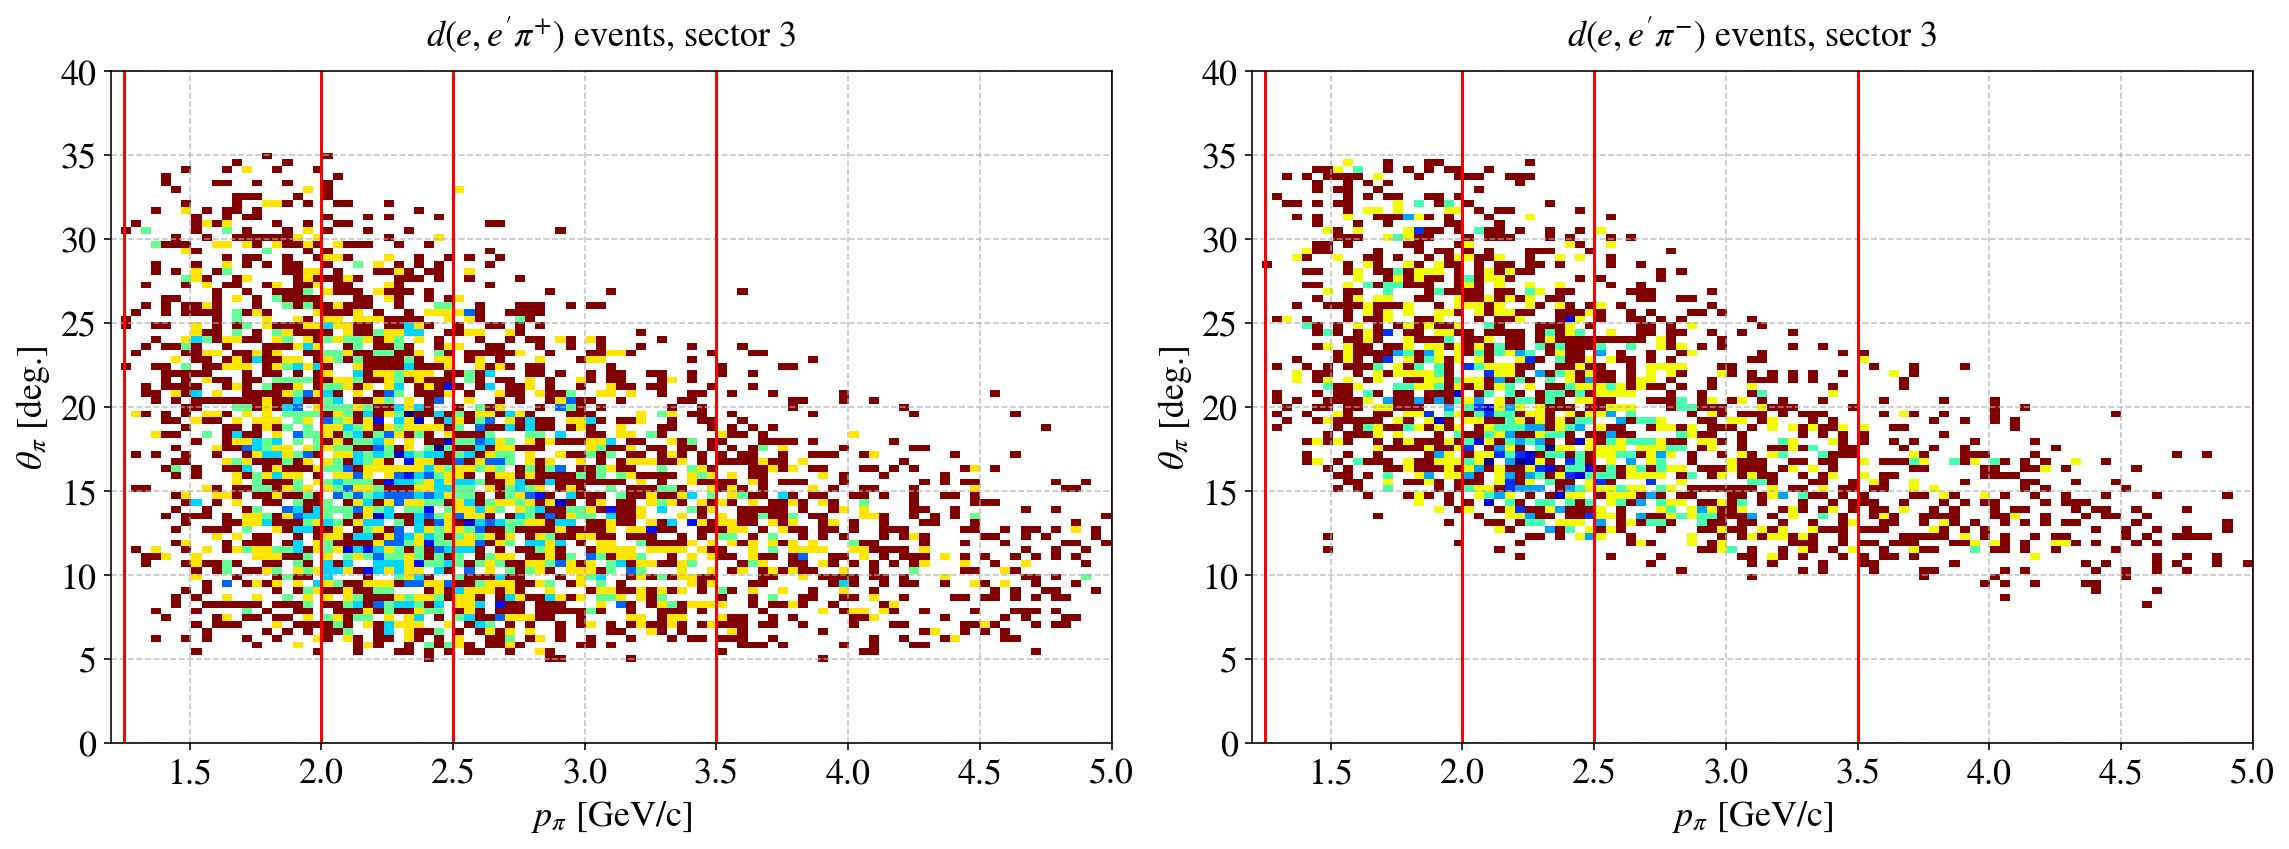

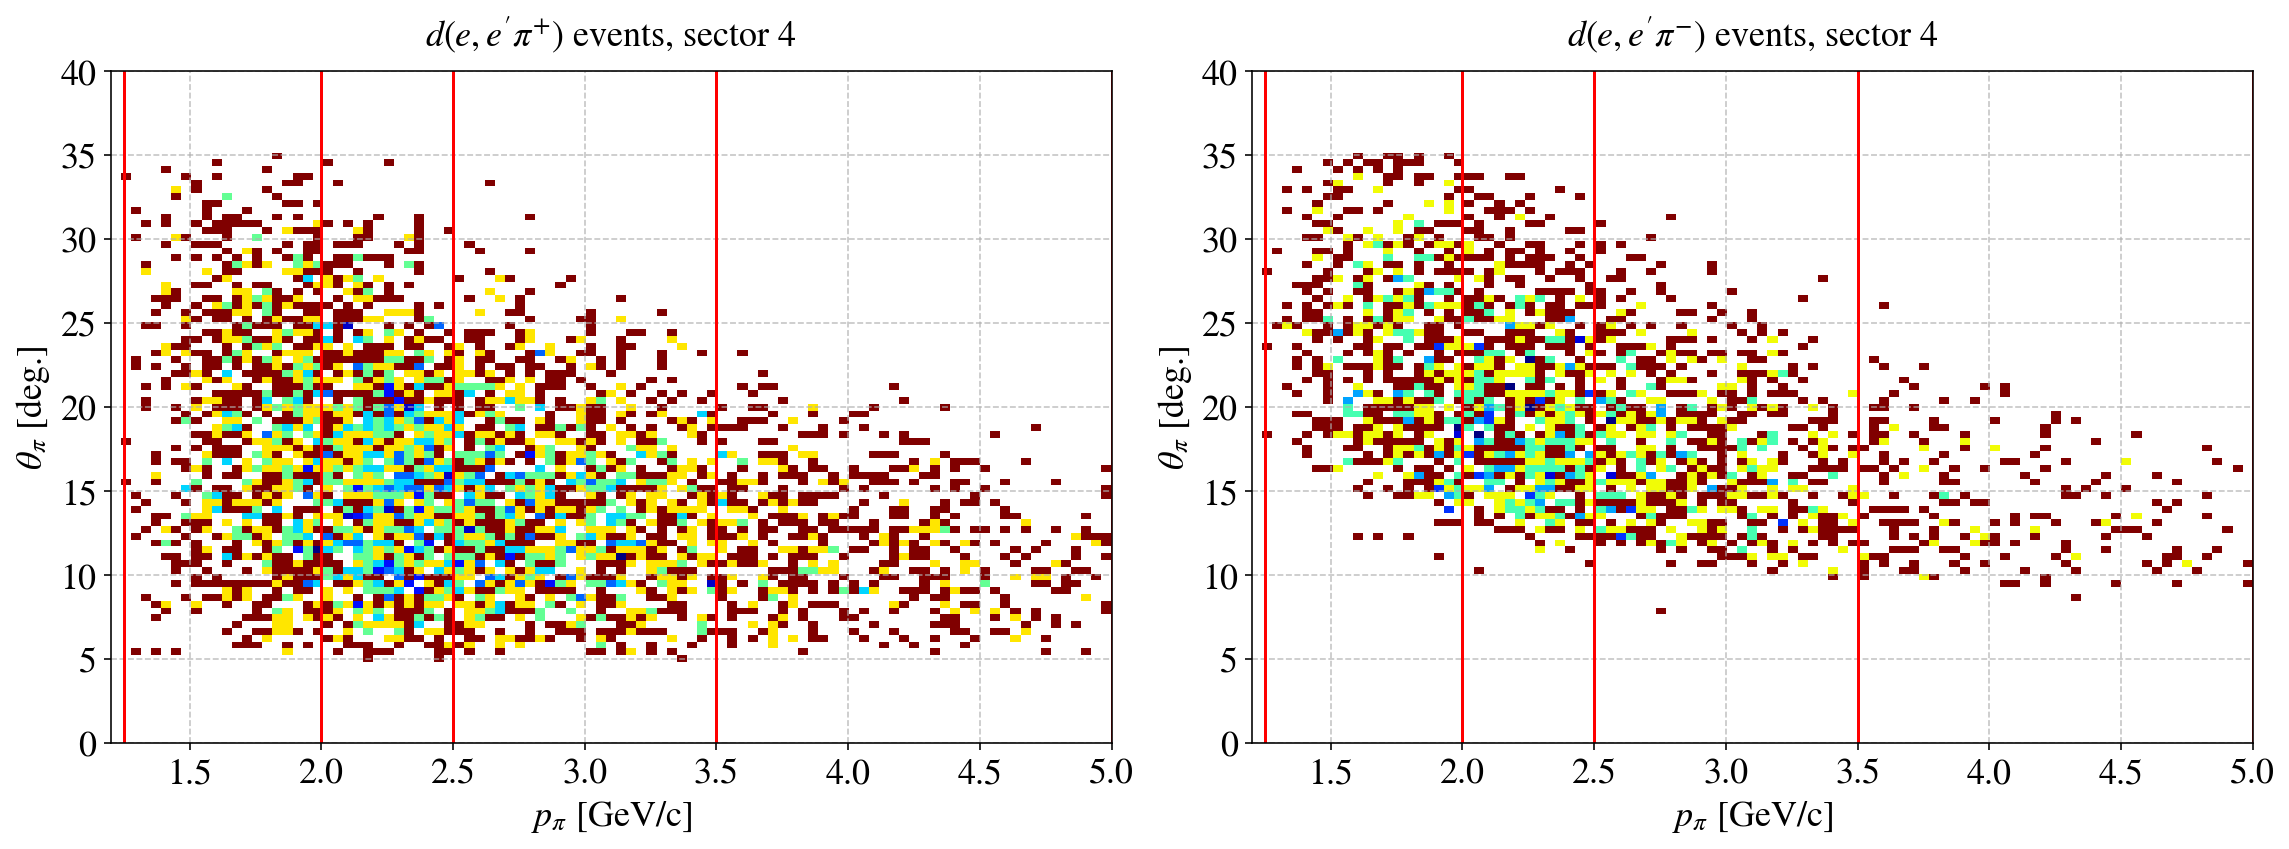

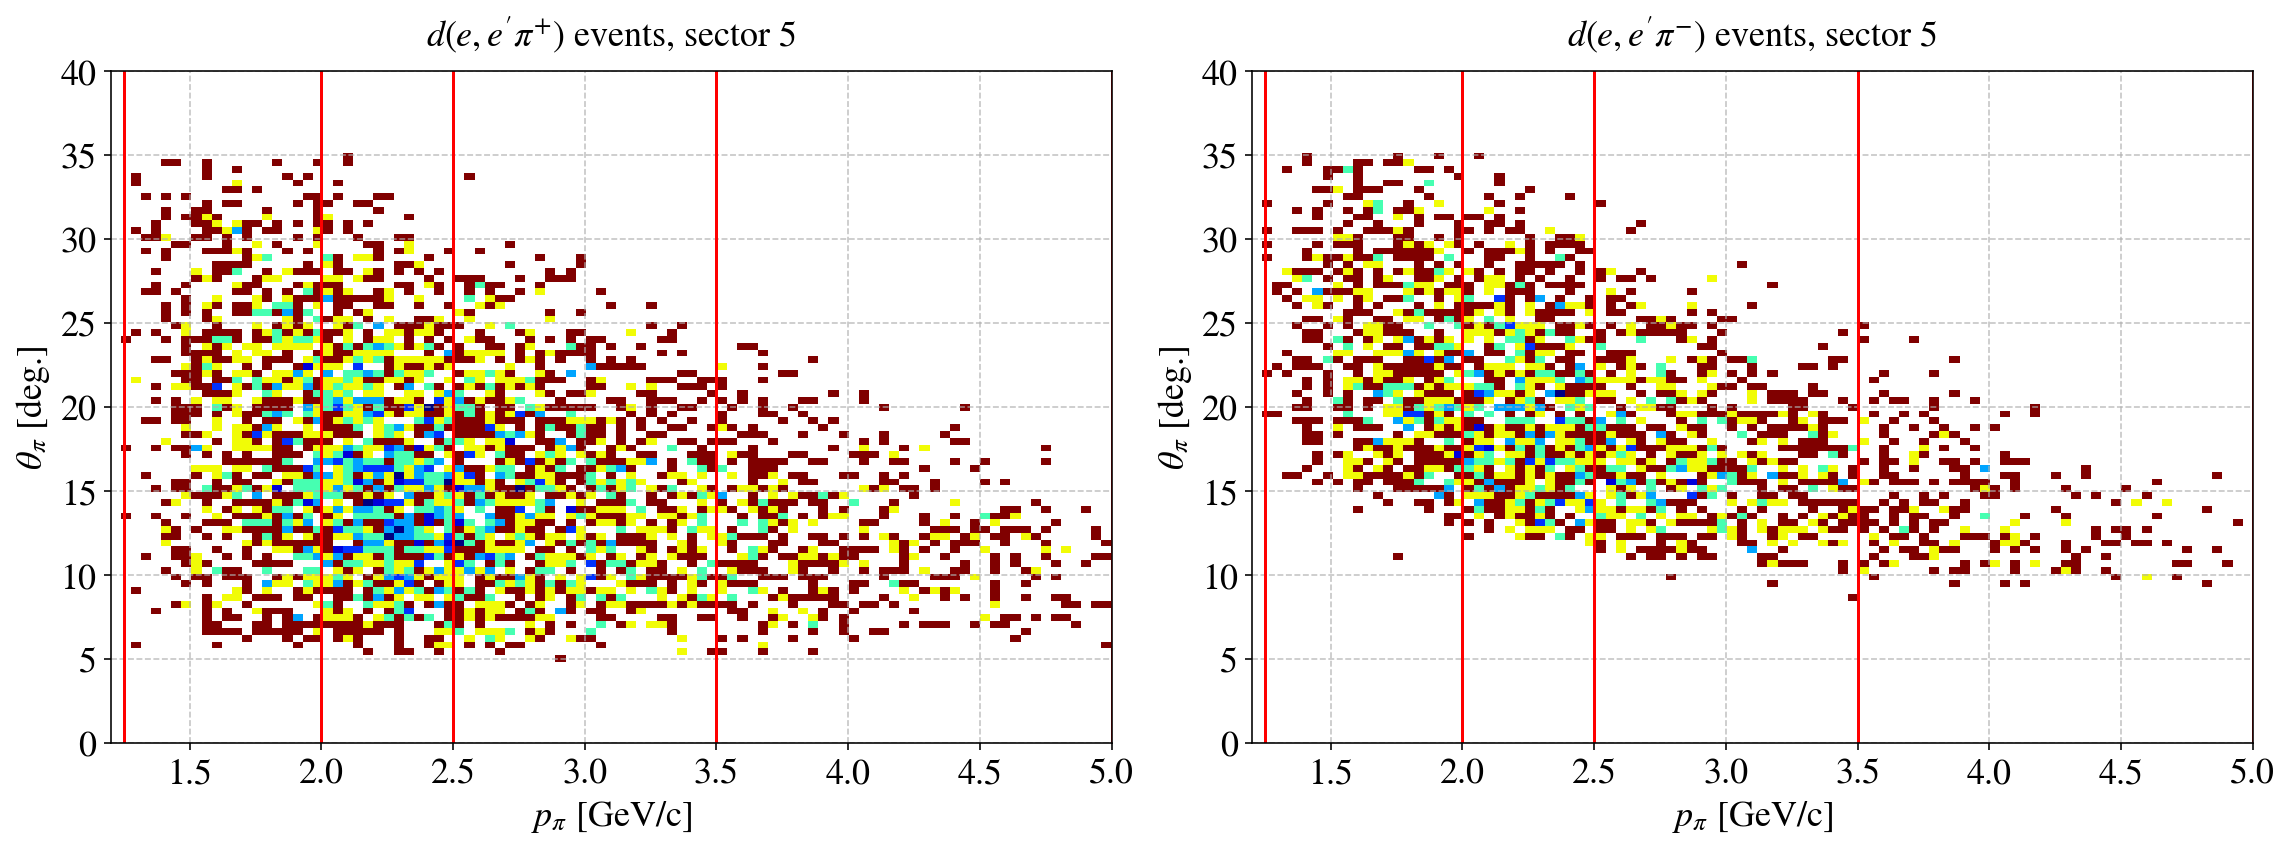

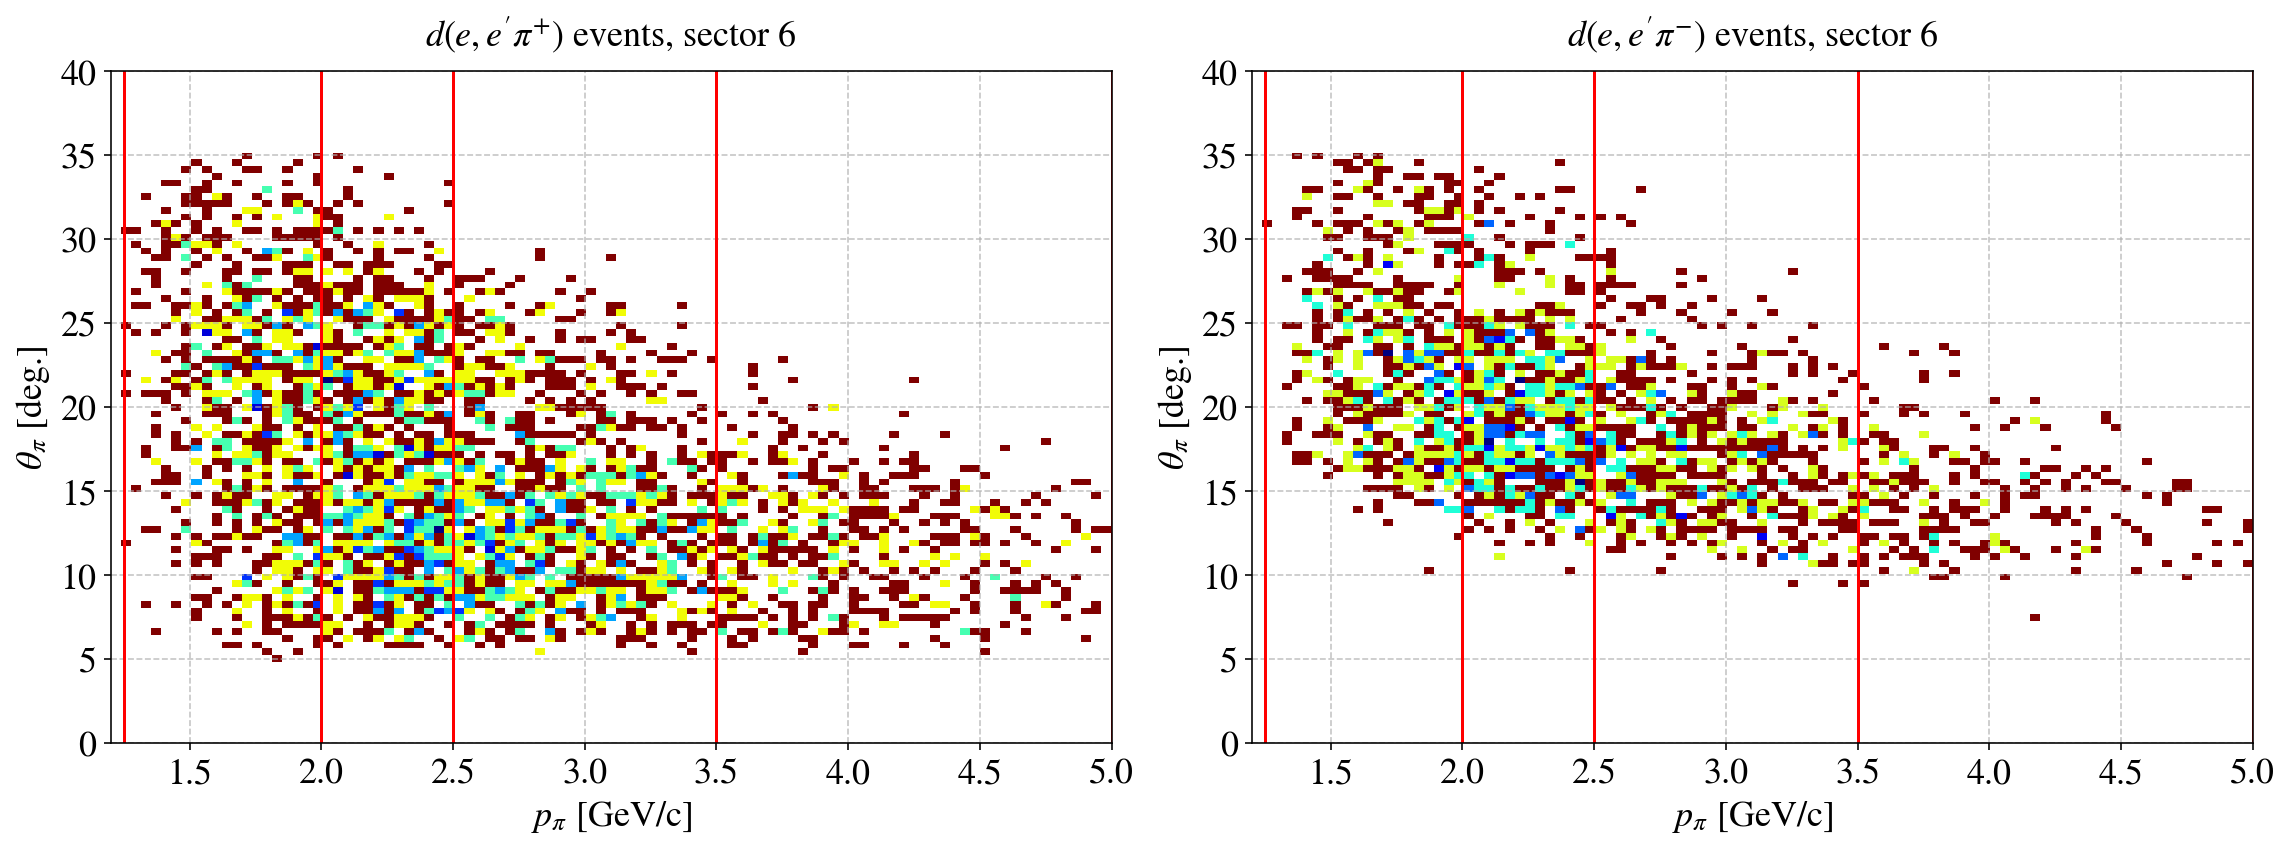

In [62]:

bins = (np.linspace(1.2,5,100),np.linspace(0,40,100))
for sector in sectors: 
    fig = plt.figure(figsize=(16,6),tight_layout=True)
    for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
        df = Events_previous_cuts[pi_ch]
        p         = df.pi_P
        theta     = df.pi_Theta*180./np.pi
        pi_sector = df.pi_Sector
    
        ax = fig.add_subplot(1,2,pi_idx)
        plt.hist2d( p[pi_sector==sector], theta[pi_sector==sector], bins , cmap='jet_r', norm=LogNorm())

        for p_min,p_max in zip(p_min_arr,p_max_arr):
            plt.plot([p_min,p_min],[0,40],'-r',[p_max,p_max],[0,40],'-r')
    
        set_axes(ax,'$p_\pi$ [GeV/c]','$\\theta_\pi$ [deg.]',
             title="$d(e,e'"+pi_label+")$ events, sector %d"%sector,
             fontsize=18,do_add_grid=True)
    
    save_figure(filename = figures_path + 'theta_vs_p_sector_%d'%sector + '.pdf')    

#### 2.16.2 Plot $\theta$ vs. $\phi$ for the pion for a specific bin in $p$

saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_phi_p_bins_sector_1.png
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_phi_p_bins_sector_2.png
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_phi_p_bins_sector_3.png
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_phi_p_bins_sector_4.png
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_phi_p_bins_sector_5.png
saved /Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/theta_vs_phi_p_bins_sector_6.png


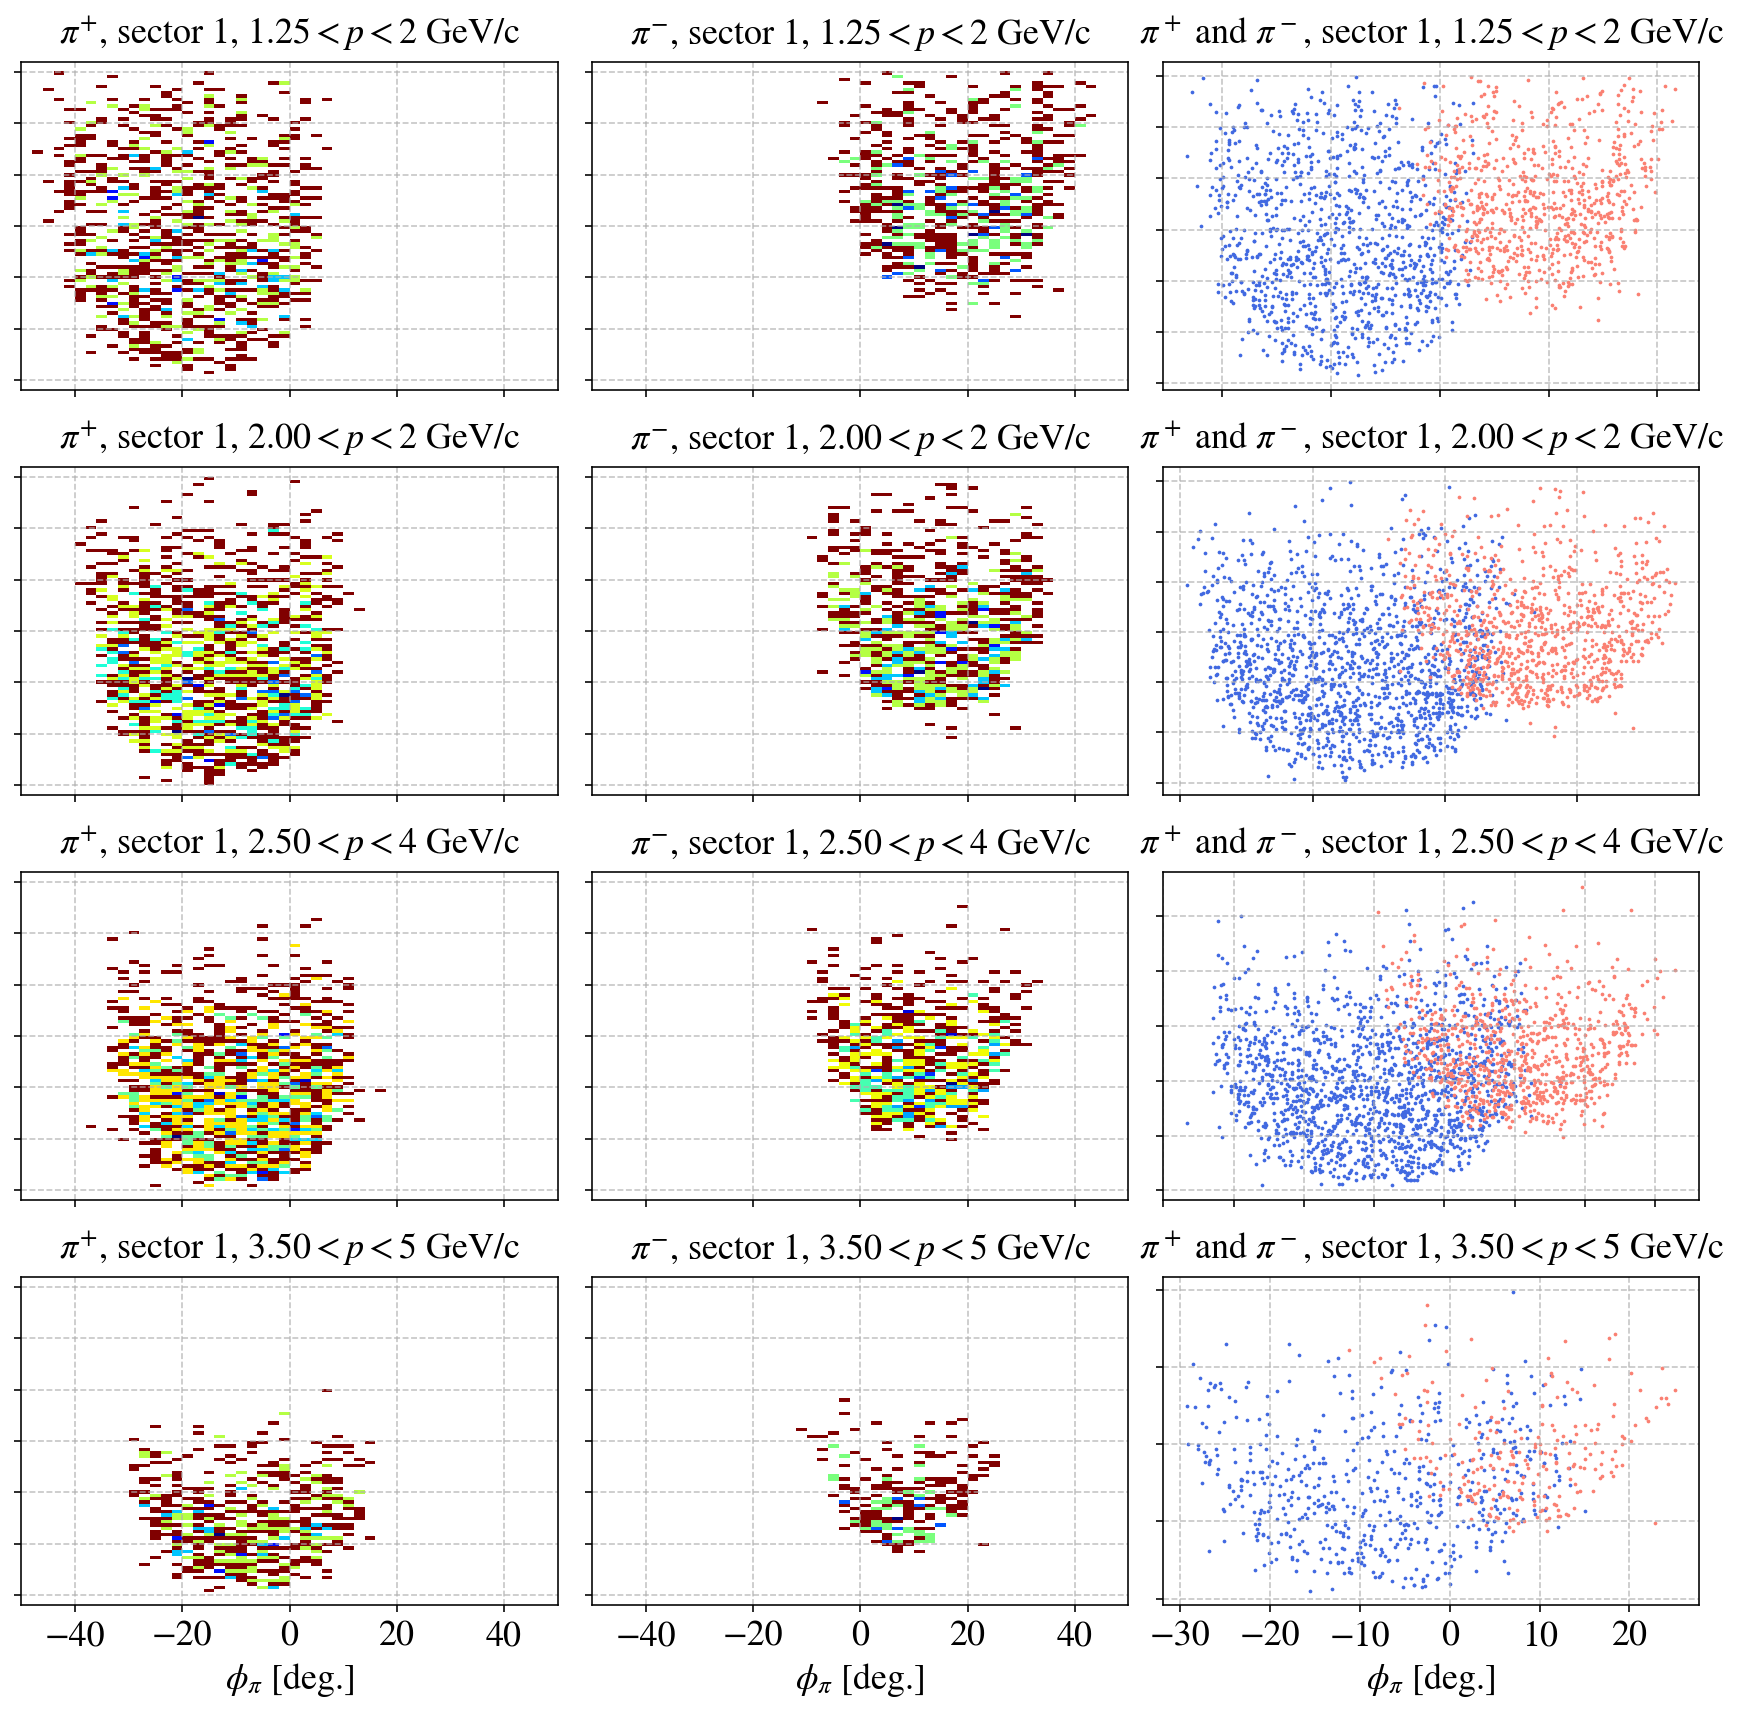

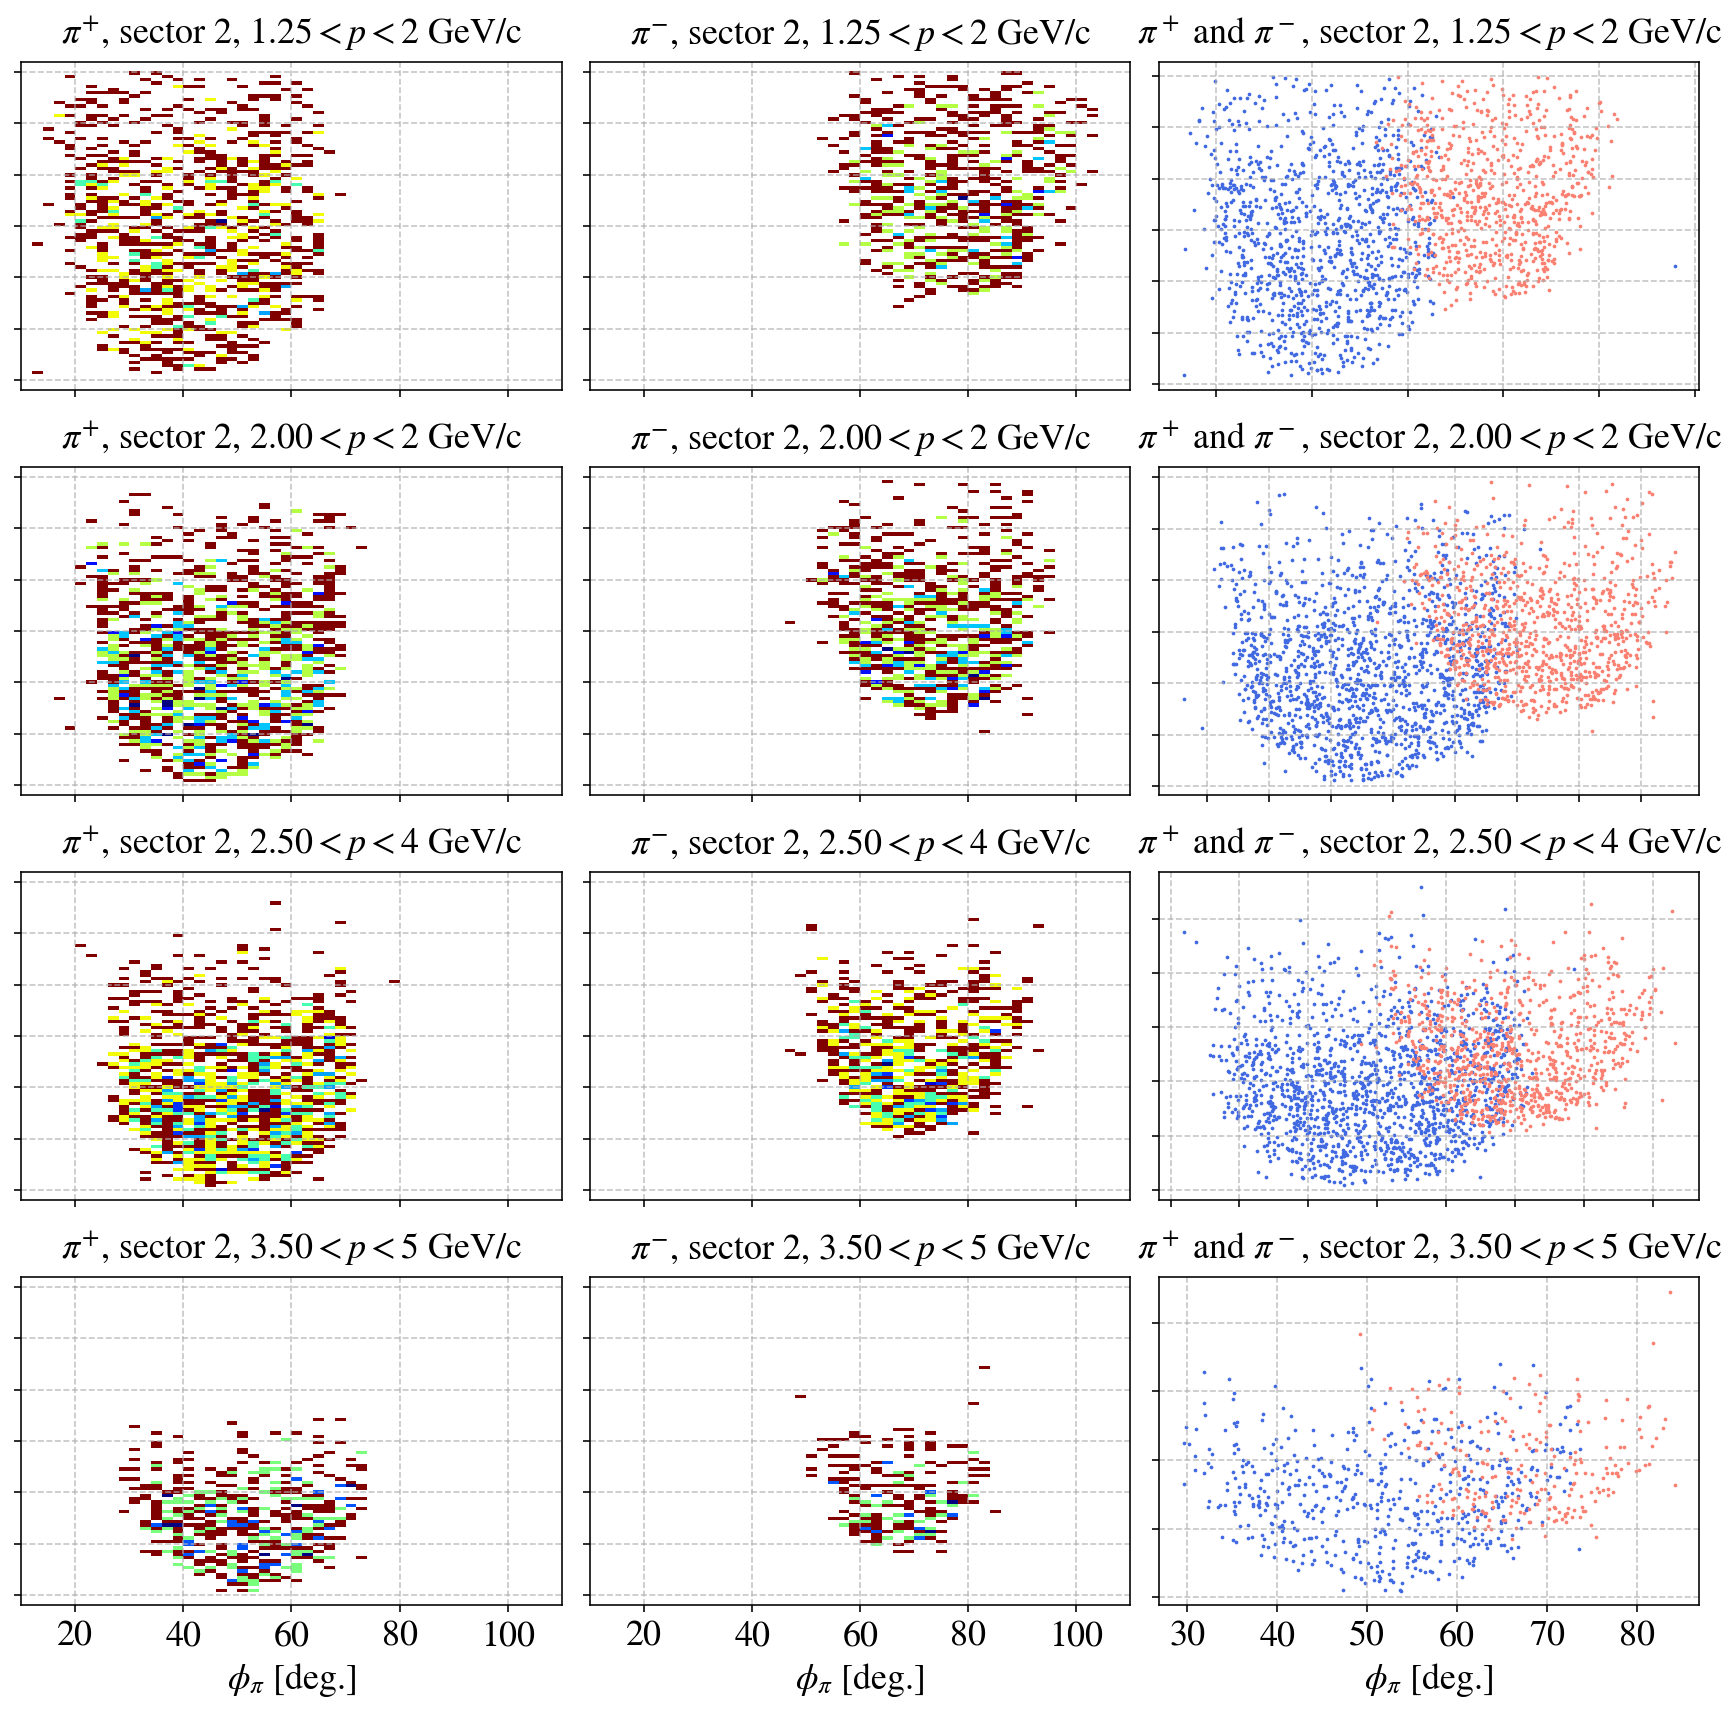

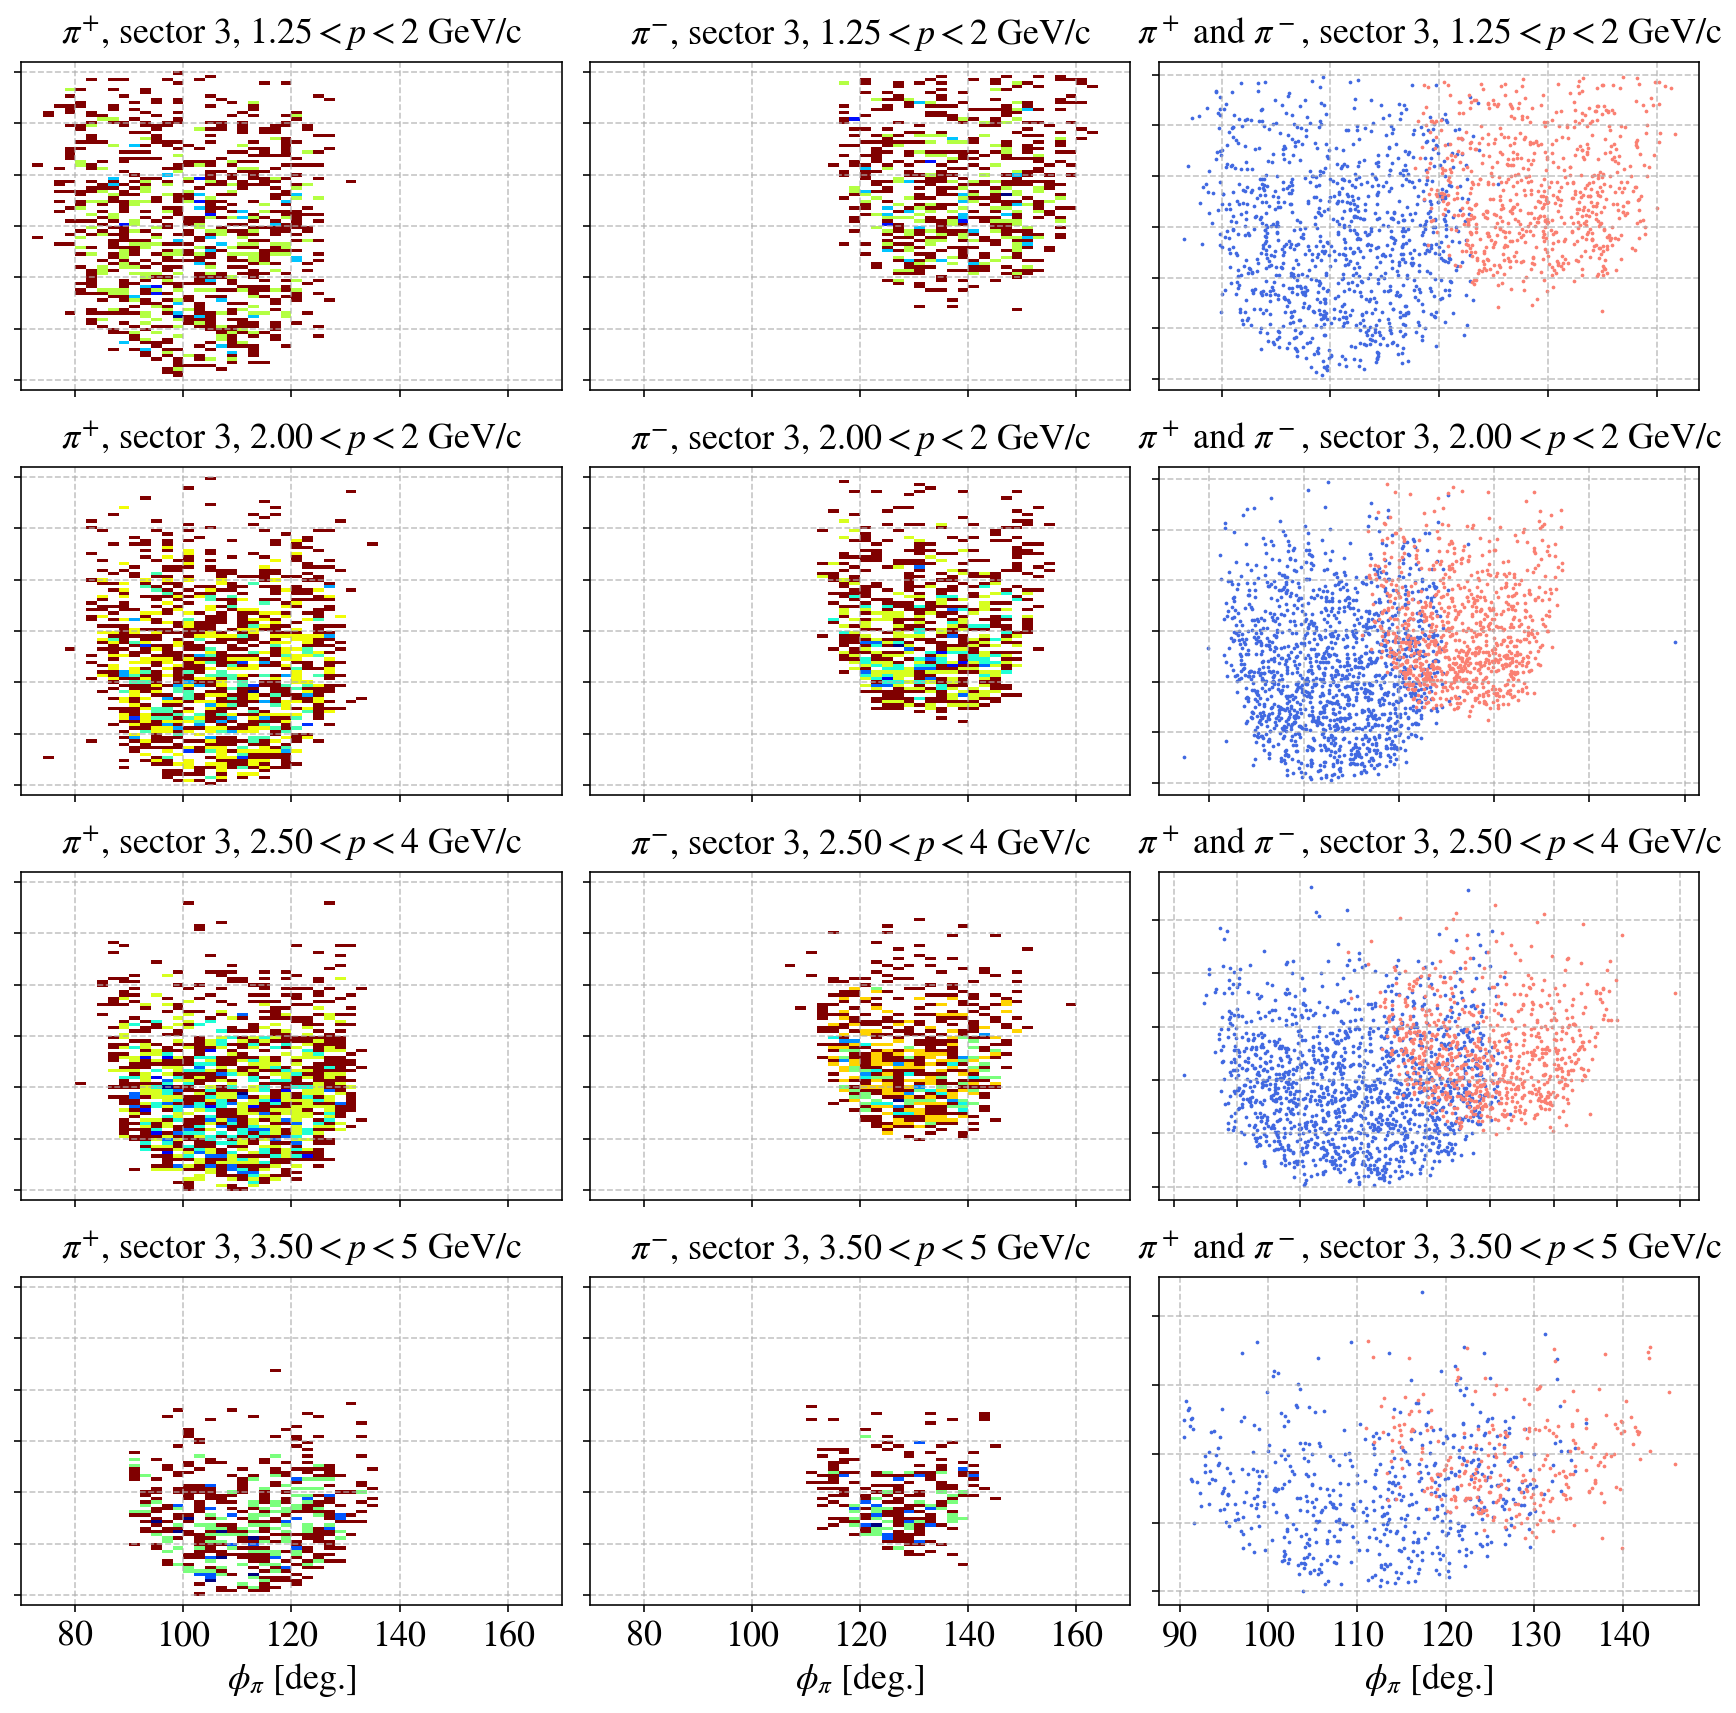

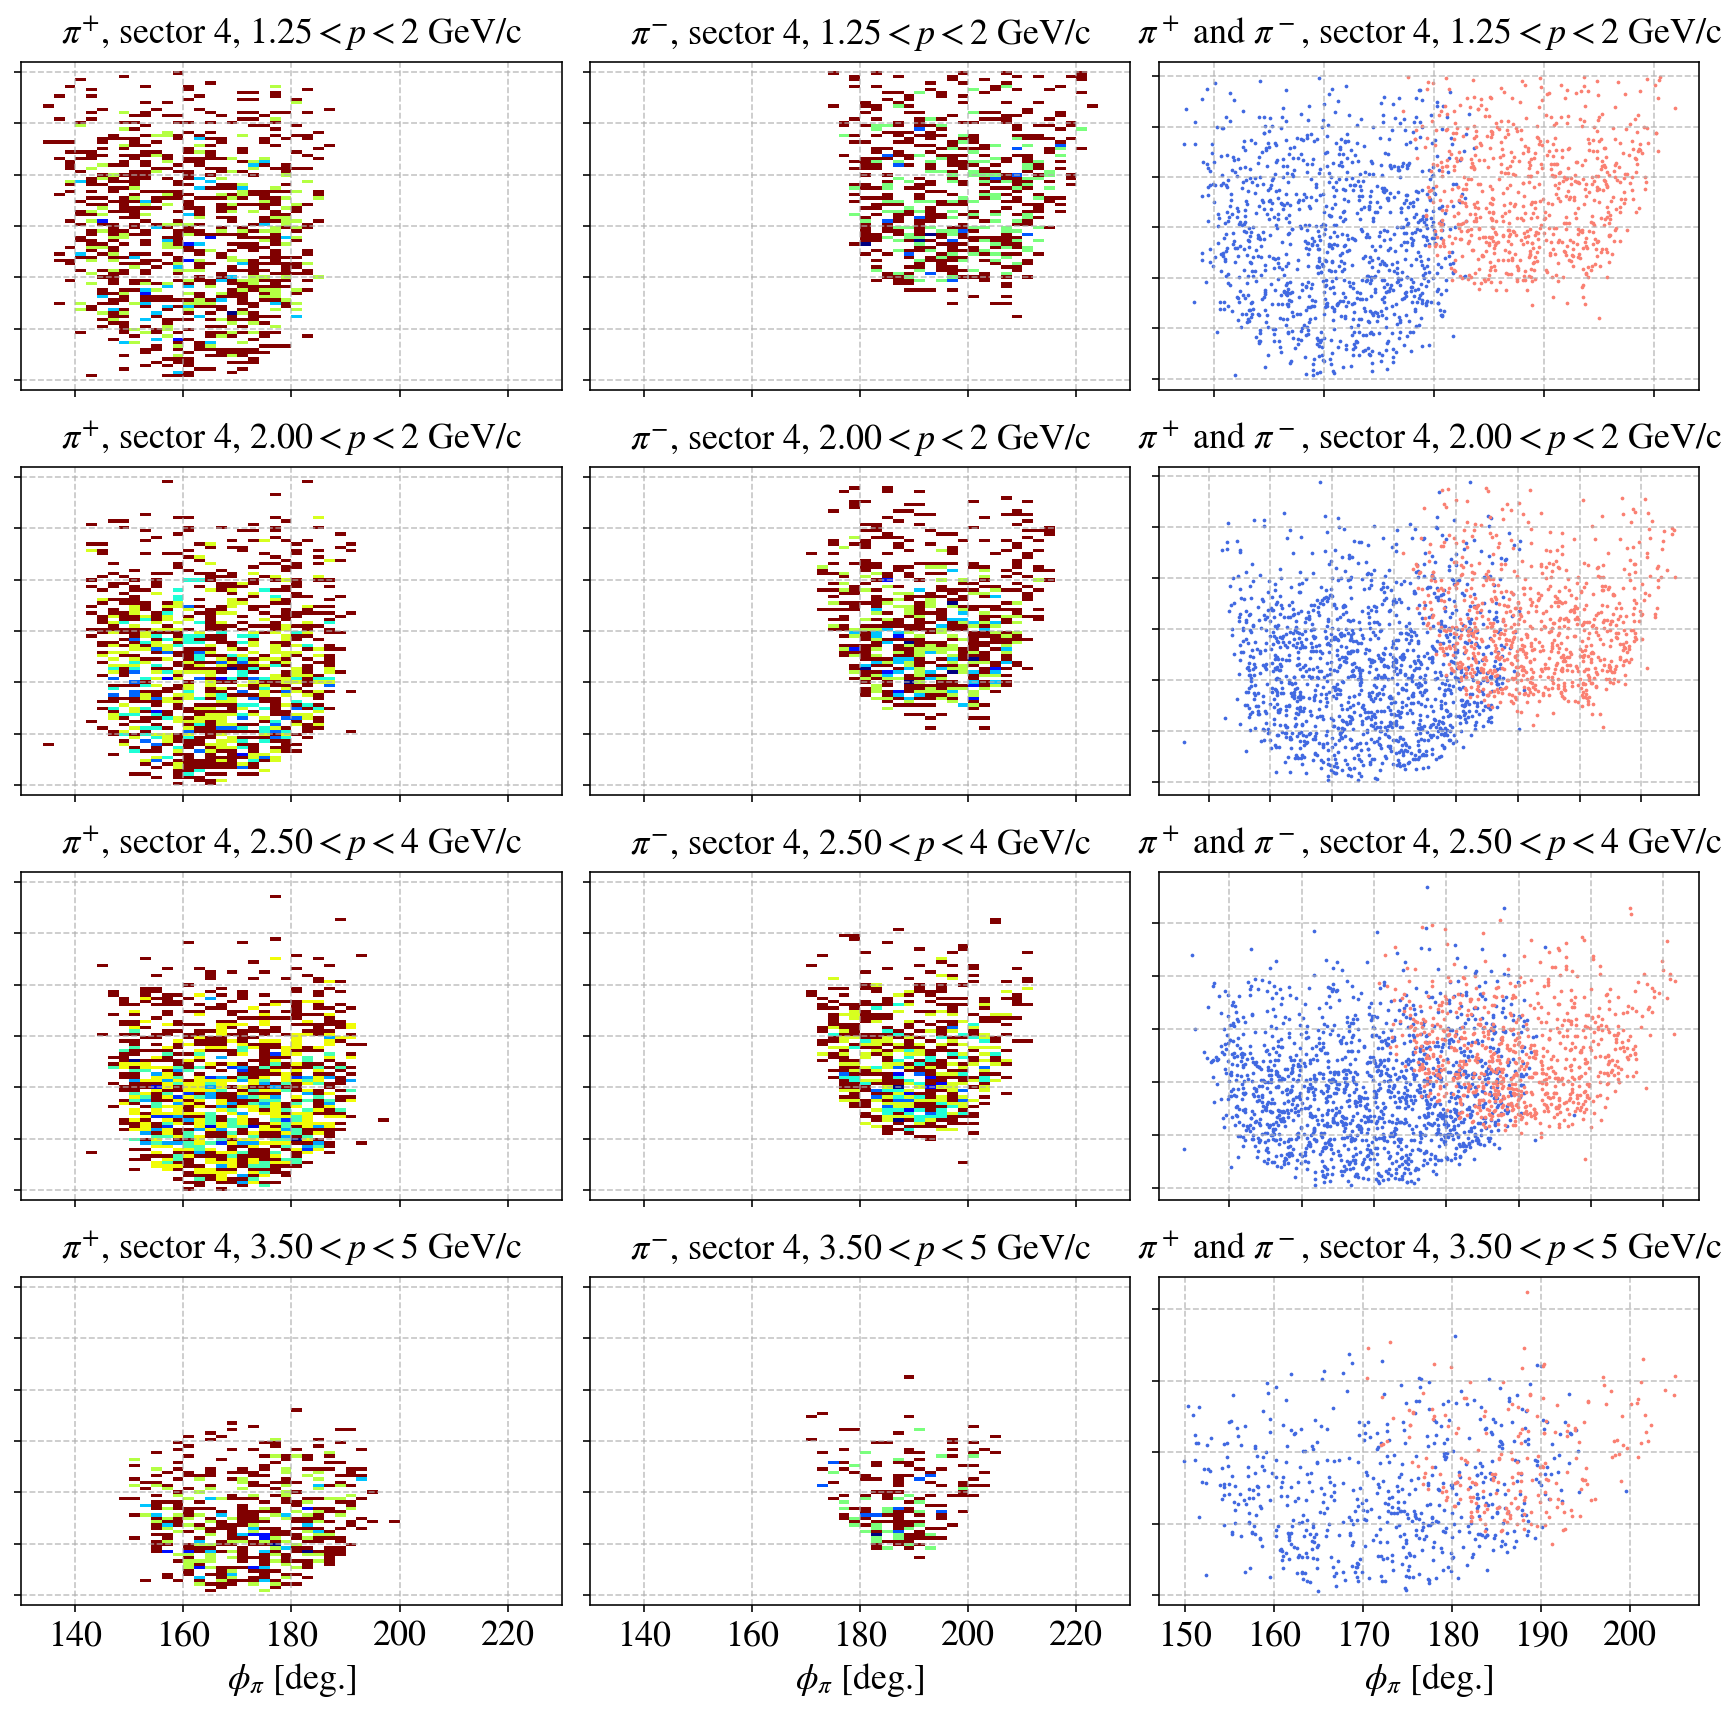

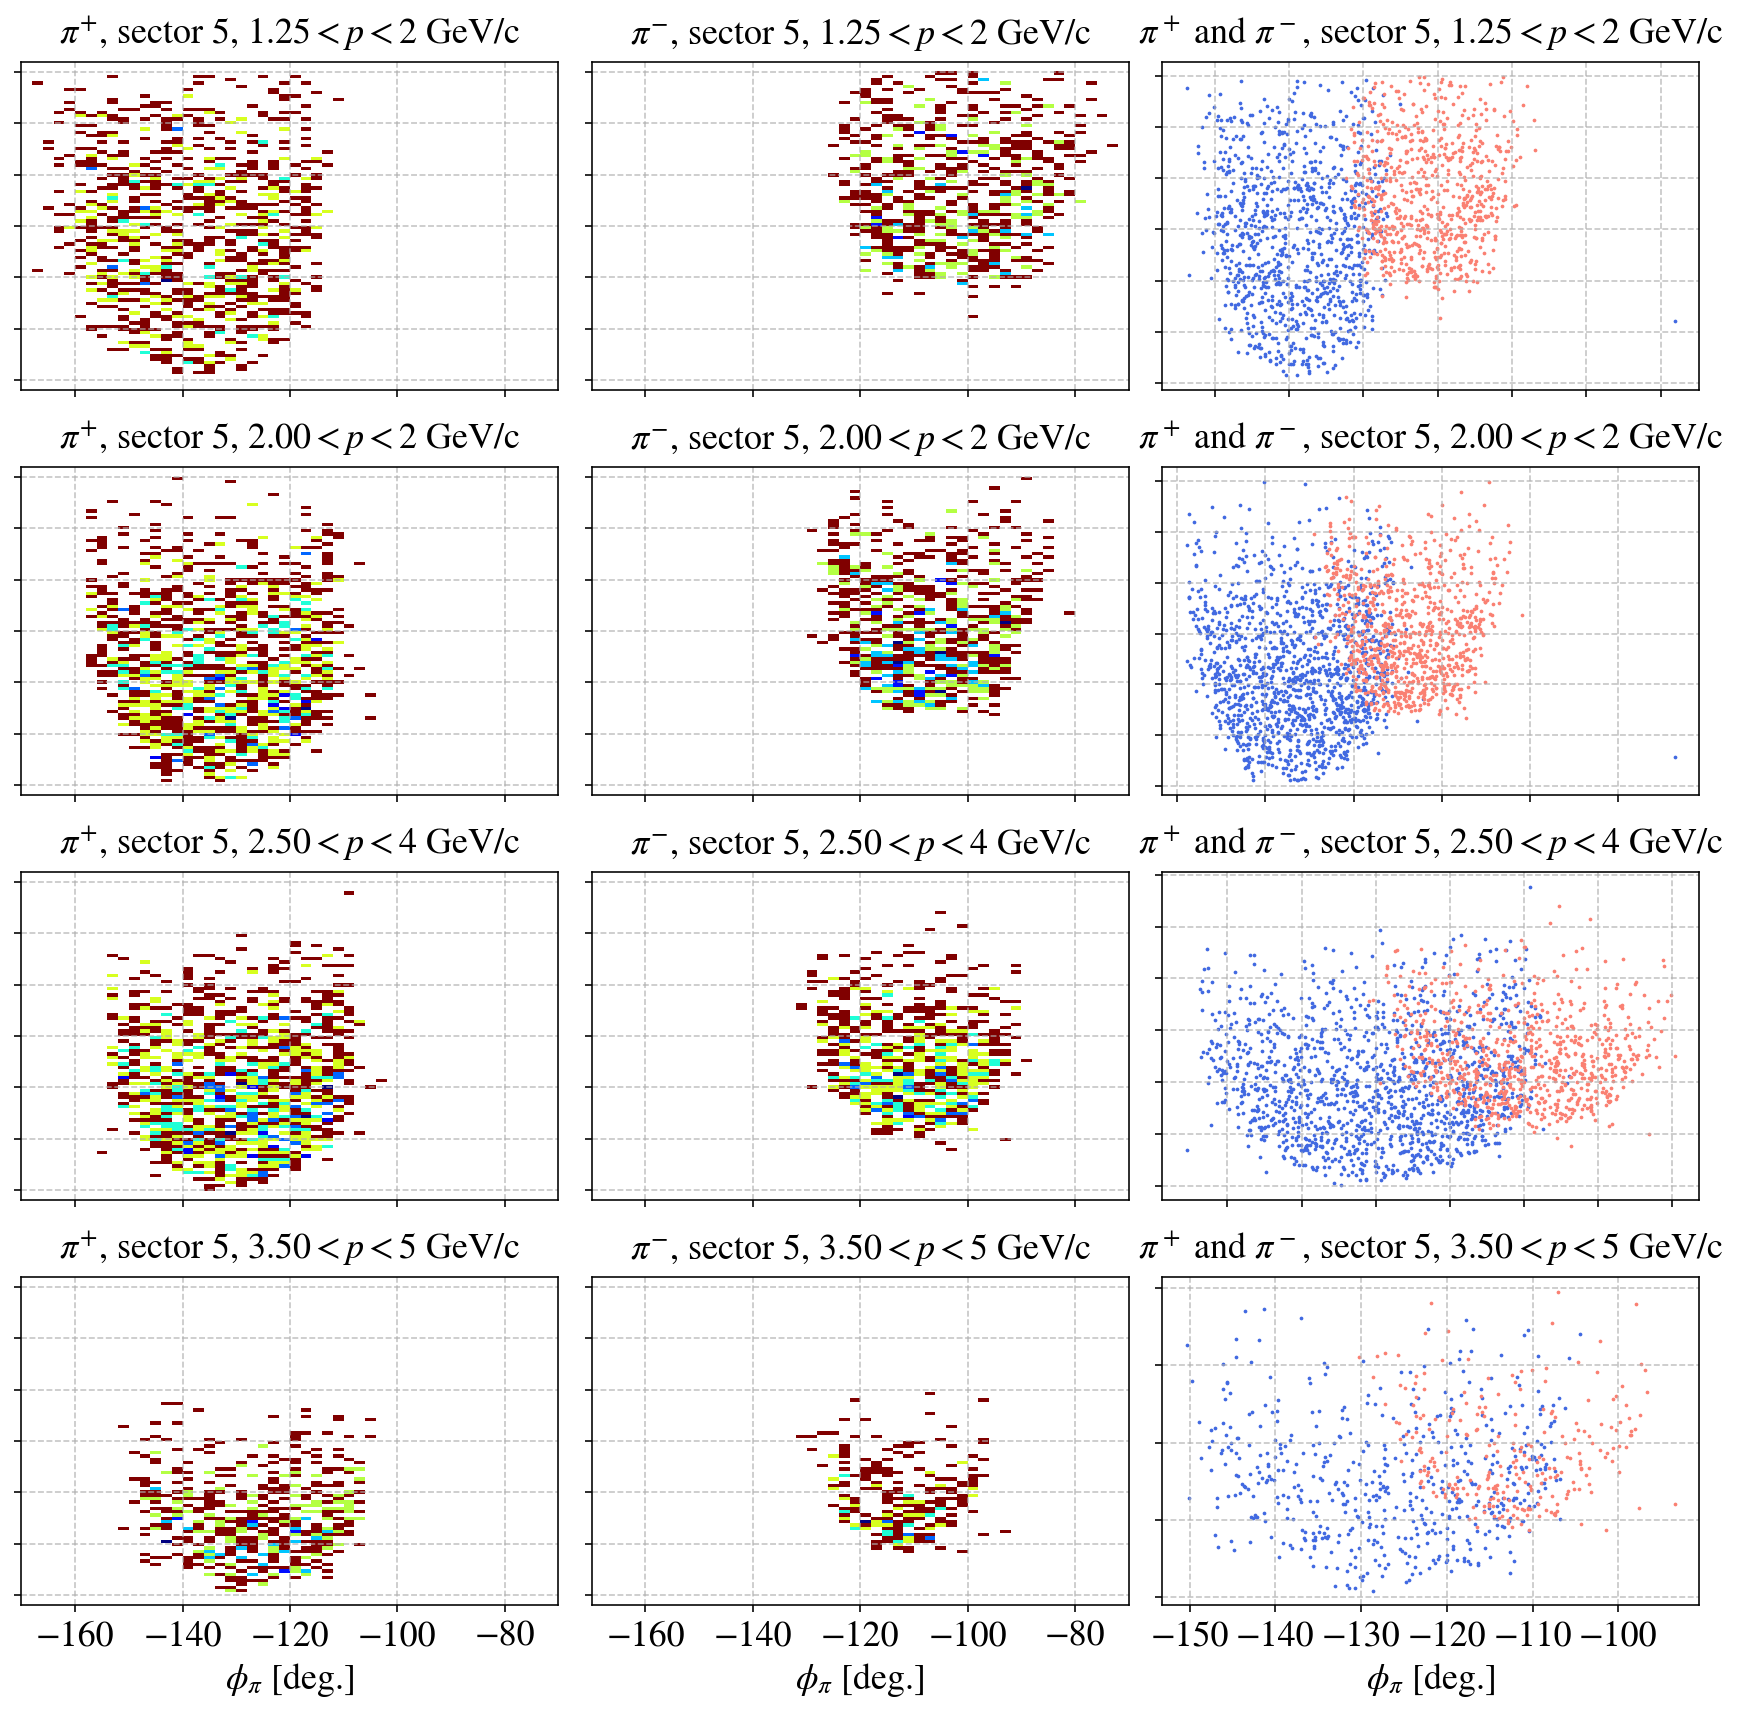

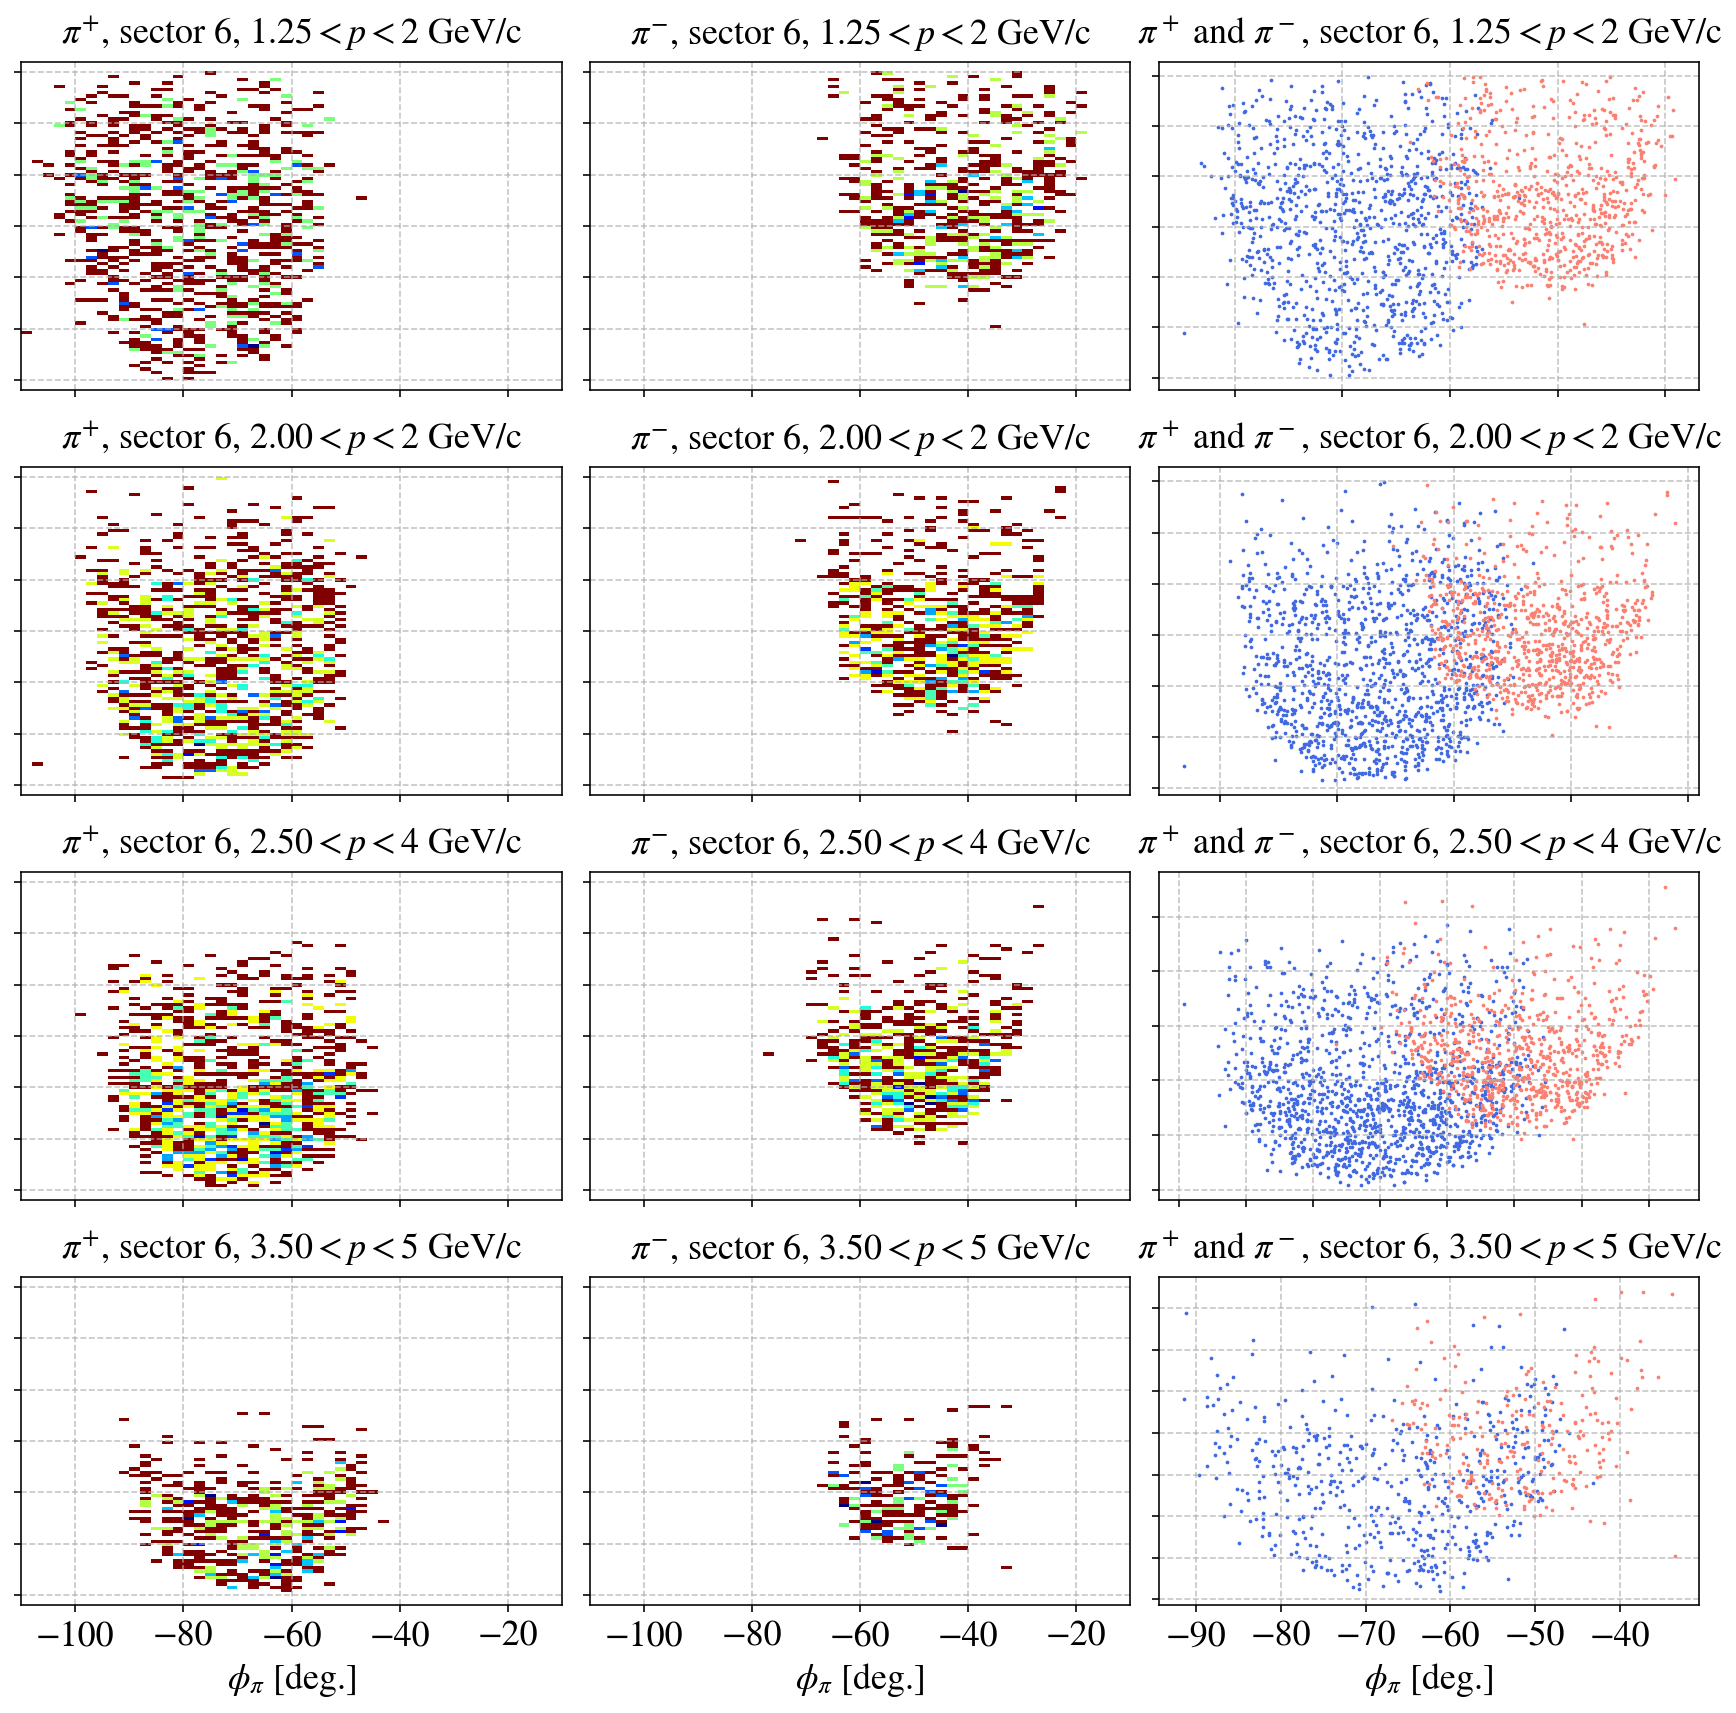

In [63]:
theta_bins = np.linspace(4,36,Nbins)
Nbins = 51
for sector in sectors:
    axes = dict()
    fig = plt.figure(figsize=(12,12),tight_layout=True)
    phi_bins = np.linspace(phi_min_arr[sector],phi_max_arr[sector],Nbins)

    
    for p_min,p_max,p_idx in zip(p_min_arr,p_max_arr,range(Np)):
        axes[3*p_idx + 3] = fig.add_subplot(Np, 3, 3*p_idx + 3)
        set_axes(axes[3*p_idx + 3],
                         '$\phi_\pi$ [deg.]' if p_idx==Np-1 else '',
                         '',
                         remove_ticks_x=False if p_idx==Np-1 else True,
                         remove_ticks_y=True,
                         title="$\pi^+$ and $\pi^-$, sector %d, $%.2f < p < %2.f$ GeV/c"%(sector,p_min,p_max),
                         fontsize=18,do_add_grid=True)

    
    for pi_ch,pi_label,pi_color,pi_idx in zip(pi_charge_names,pi_labels,pi_colors,[1,2]):
        df = Events_previous_cuts[pi_ch]
        df_in_sector = df[df.pi_Sector==sector]

        for p_min,p_max,p_idx in zip(p_min_arr,p_max_arr,range(Np)):
            # print(p_min,'< p(π) <',p_max)
            df_in_bin = df_in_sector[ (p_min < df_in_sector.pi_P) & (df_in_sector.pi_P < p_max) ]
            theta     = df_in_bin.pi_Theta*180./np.pi            
            phi       = df_in_bin.pi_Phi  *180./np.pi
            if sector==4:#{
                phi_shifted = [];
                for _phi_ in phi:
                    if _phi_ < 100: phi_shifted.append(_phi_+360)
                    else: phi_shifted.append(_phi_)
                phi = phi_shifted;
            #} 
            ax = fig.add_subplot(Np, 3, 3*p_idx + pi_idx)
            plt.hist2d( phi, theta, bins=(phi_bins,theta_bins) , cmap='jet_r', norm=LogNorm())

            set_axes(ax,
                     '$\phi_\pi$ [deg.]' if p_idx==Np-1 else '',
                     '$\\theta_\pi$ [deg.]' if pi_idx==0 else '',
                     remove_ticks_x=False if p_idx==Np-1 else True,
                     remove_ticks_y=False if pi_idx==0 else True,
                     title="$"+pi_label+"$, sector %d, $%.2f < p < %2.f$ GeV/c"%(sector,p_min,p_max),
                     fontsize=18,do_add_grid=True)

            axes[3*p_idx + 3].scatter( phi, theta,s=3 ,marker='.', color=pi_color, label="$"+pi_label+"$")
            
    save_figure(filename = figures_path + 'theta_vs_phi_p_bins_sector_%d'%sector + '.png')

# (3) Reproduce Alex' acceptance matching cut

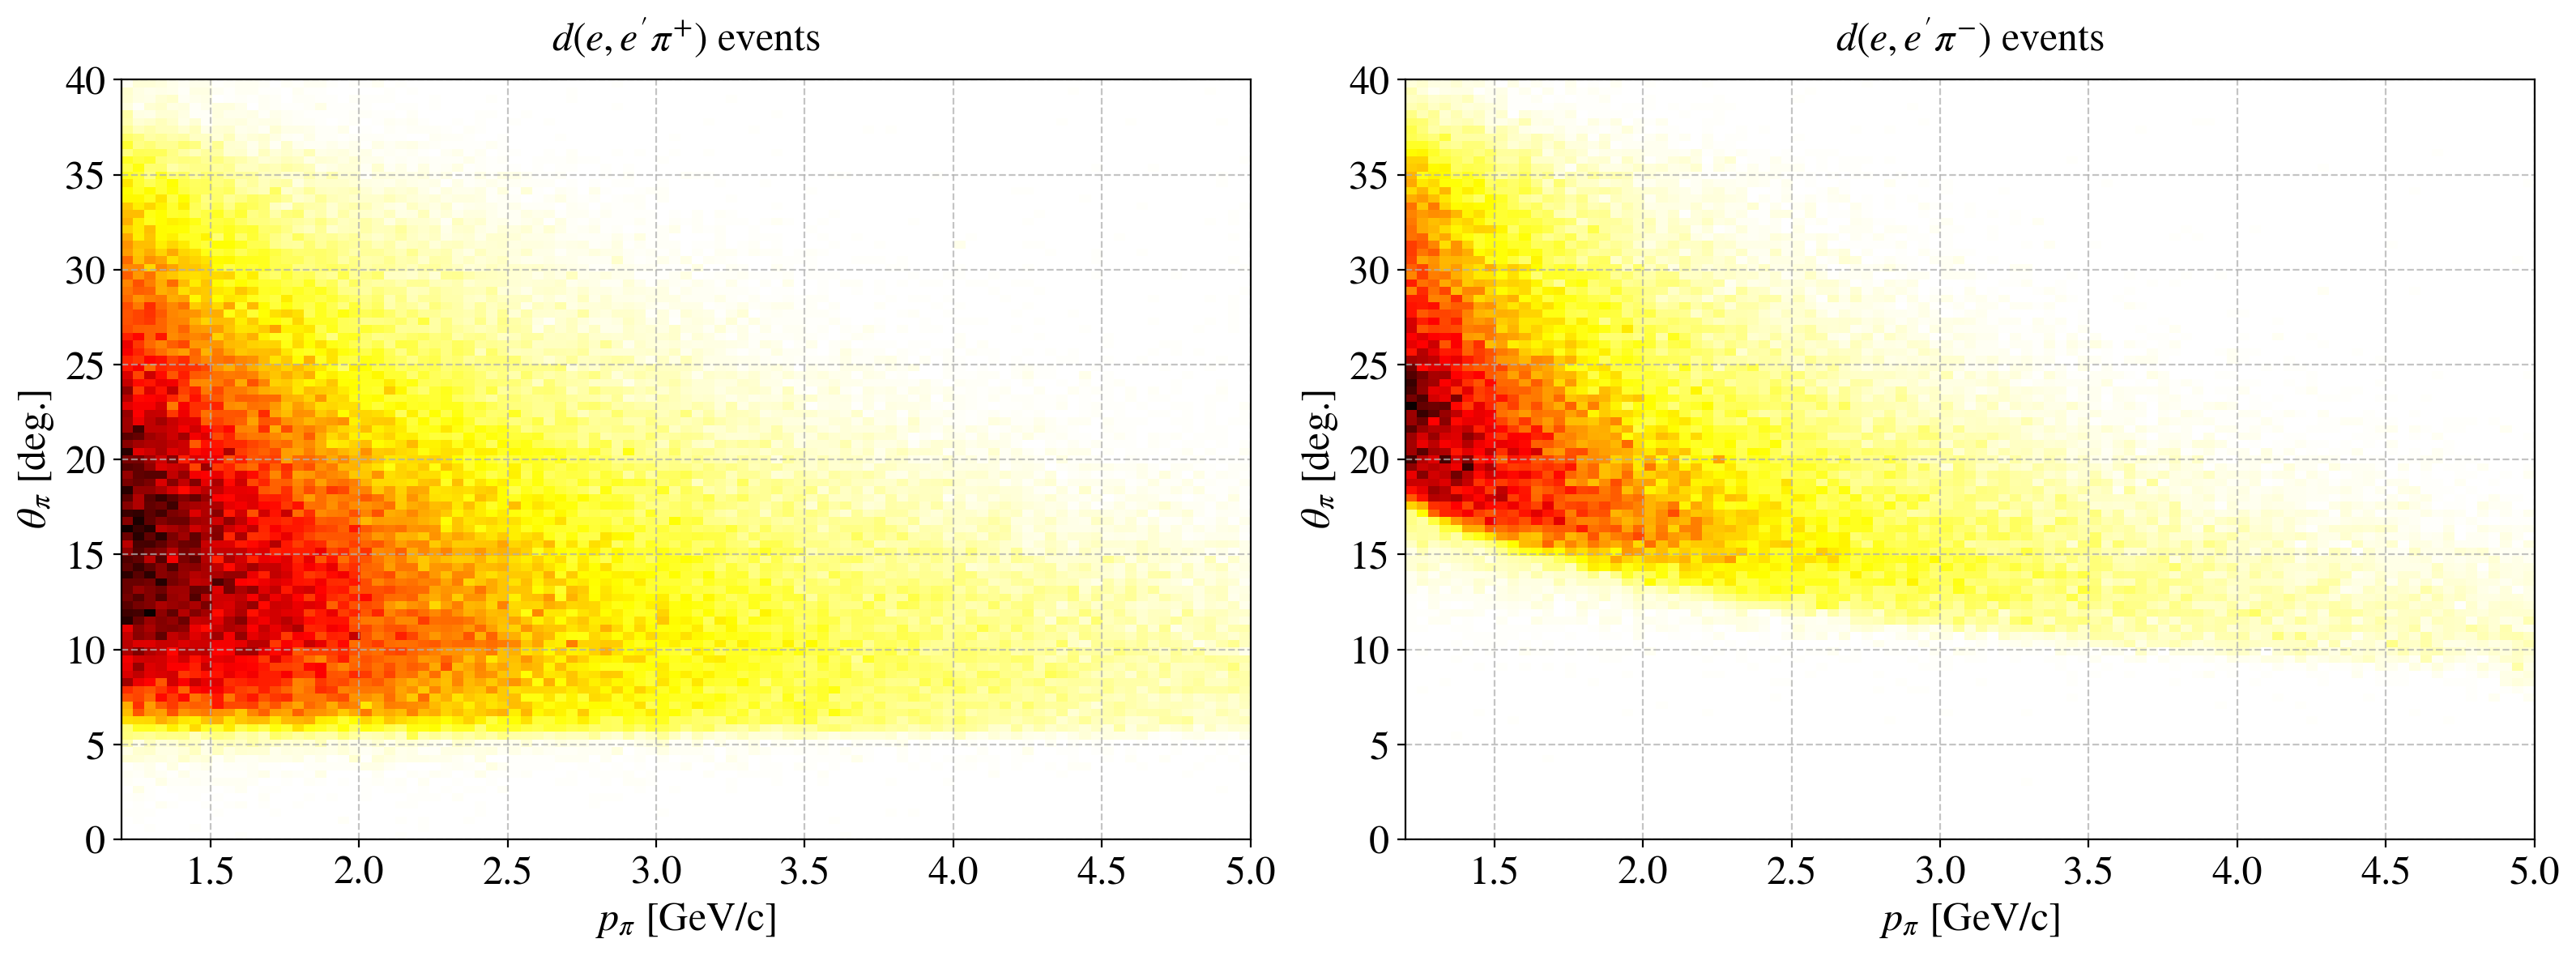

In [56]:
# theta_Pi vs. p_Pi
fig = plt.figure(figsize=(16,6),tight_layout=True)
bins = (np.linspace(1.2,5,100),np.linspace(0,40,100))
sector = 1

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    p = np.array(pi_P[pi_ch])
    theta = np.array(pi_Theta[pi_ch])*180./np.pi
    pi_sector = np.array(pi_Sector[pi_ch])
    
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist2d( p[pi_sector==sector], theta[pi_sector==sector], bins , cmap='hot_r')

    
    
    # plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$p_\pi$ [GeV/c]','$\\theta_\pi$ [deg.]',
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18,do_add_grid=True)

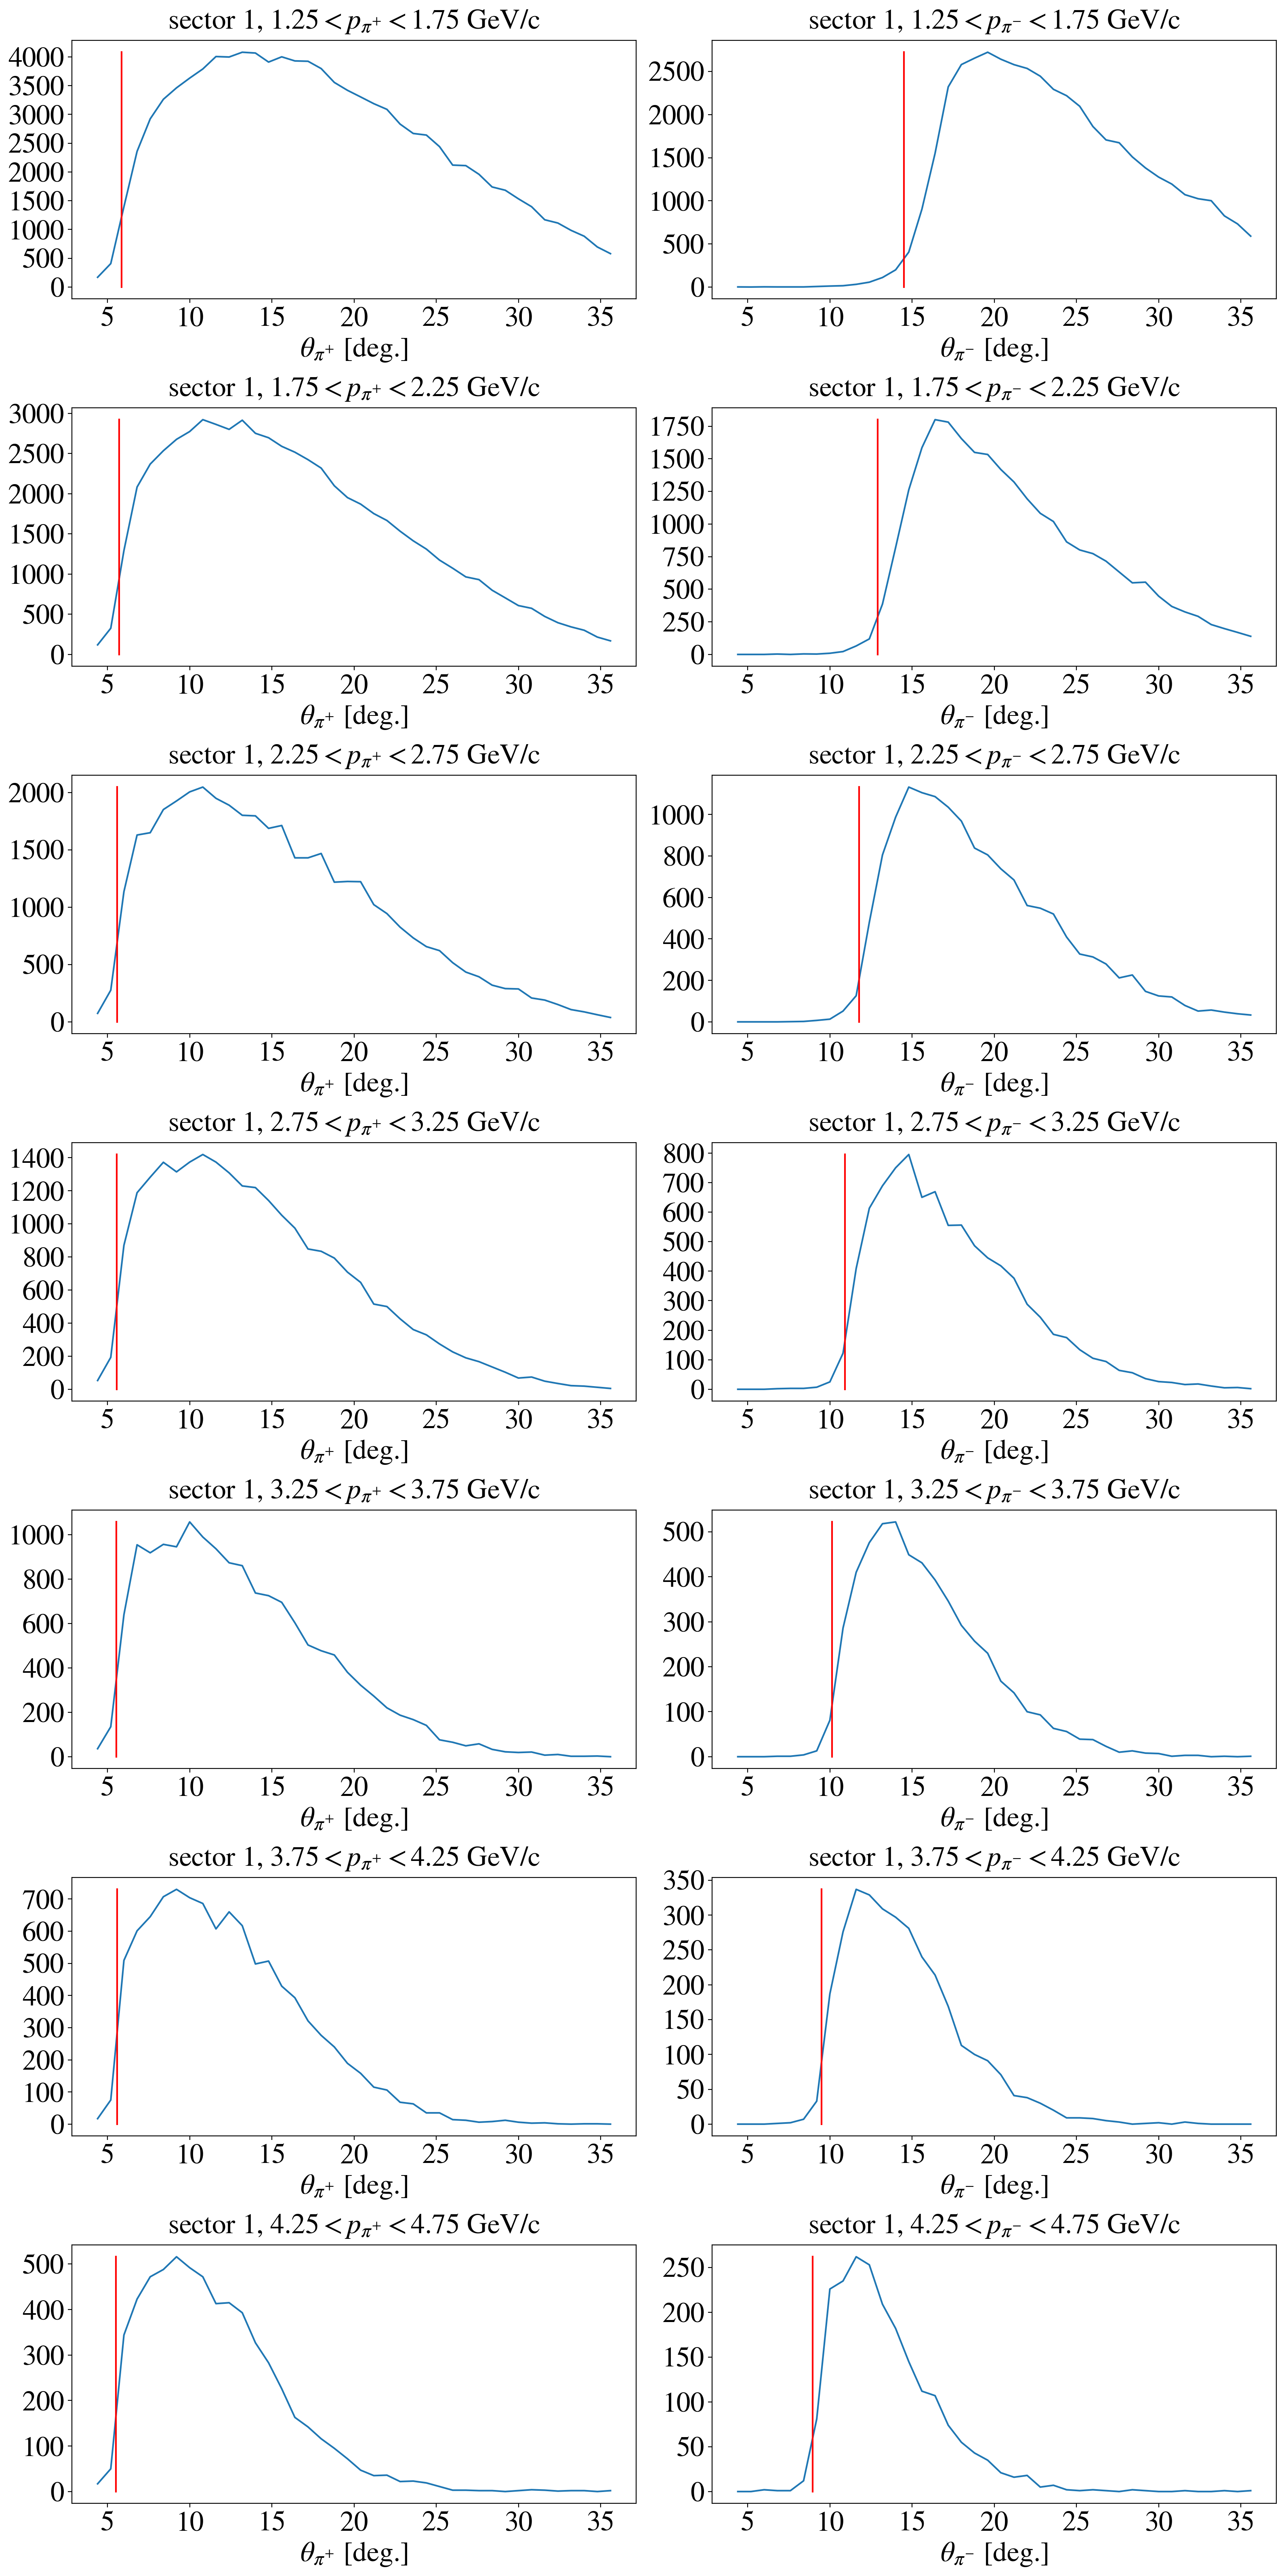

In [57]:
fig = plt.figure(figsize=(16,32),tight_layout=True)
delta_p   = 0.5
p_min_arr = np.arange(1.25,5,delta_p)
p_max_arr = p_min_arr + delta_p

theta_bins = np.linspace(4,36,41)
sector = 1
Np = 7

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    p = np.array(pi_P[pi_ch])
    theta = np.array(pi_Theta[pi_ch])*180./np.pi
    pi_sector = np.array(pi_Sector[pi_ch])


    for p_min,p_max,p_idx in zip(p_min_arr,p_max_arr,range(Np)):
        theta_in_bin = theta[ (pi_sector==sector) & (p_min < p) & (p < p_max) ]
        ax = fig.add_subplot( Np, 2, 2*p_idx + pi_idx )
        h,edges = np.histogram( theta_in_bin, theta_bins )
        # h,edges,_ = ax.hist(theta_in_bin, theta_bins, histtype='step')
        x = (edges[1:]+edges[:-1])/2
        plt.plot(x, h)
        set_axes(ax,'$\\theta_{%s}$ [deg.]'%pi_label,'',
                 title="sector %d, $%.2f < p_{%s} < %.2f$ GeV/c"%(sector,p_min,pi_label,p_max))
        
        # find the theta value for X% of the distribution
        theta_prctl = np.percentile( theta_in_bin, 1 )
        plt.plot([theta_prctl,theta_prctl],[0,np.max(h)],'-r')
        if p_idx>=Np: break

